In [166]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Load the Parquet files from the 2024 folder
a = pd.read_parquet('2024/ammonium_2024.parquet')
n = pd.read_parquet('2024/nitrate_2024.parquet')
oa = pd.read_parquet('2024/oxygen_a_2024.parquet')
ob = pd.read_parquet('2024/oxygen_b_2024.parquet')
p = pd.read_parquet('2024/phosphate_2024.parquet')
ifd = pd.read_parquet('2024/Influent_Flow_2023.parquet')
edf = pd.read_csv('2024/ExternalDataFinal.csv')


In [167]:


def format_datetime_columns(df, date_cols=['datumBeginMeting', 'datumEindeMeting']):
    """
    Convert specified columns in df to format 'D-M-YYYY HH:MM', dropping leading zeros 
    in day and month. Modifies df in place.
    """
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S', errors='coerce')
        df[col] = df[col].apply(lambda ts: 
            f"{ts.day}-{ts.month}-{ts.year} {ts.hour:02d}:{ts.minute:02d}"
            if pd.notnull(ts) else None
        )
    return df

# Apply formatting and drop columns if they exist
for df in [a, n, oa, ob, p, ifd]:
    format_datetime_columns(df)
    for col in ['historianTagnummer', 'waardebewerkingsmethodeCode']:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)



In [168]:
# rename columns
a.rename(columns={'hstWaarde': 'Ammonium mg/L'}, inplace=True)
n.rename(columns={'hstWaarde': 'Nitrate mg/L'}, inplace=True)
p.rename(columns={'hstWaarde': 'Phosphate mgP/L'}, inplace=True)
oa.rename(columns={'hstWaarde': 'Oxygen_A mg/L'}, inplace=True)
ob.rename(columns={'hstWaarde': 'Oxygen_B mg/L'}, inplace=True)
ifd.rename(columns={'hstWaarde': 'influentFlow'}, inplace=True)

In [169]:
# The datumEindeMeting column in each DataFrame is renamed to include a suffix that identifies the DataFrame:

a = a.rename(columns={'datumEindeMeting': 'datumEindeMeting_A'})
n = n.rename(columns={'datumEindeMeting': 'datumEindeMeting_N'})
p = p.rename(columns={'datumEindeMeting': 'datumEindeMeting_P'})
oa = oa.rename(columns={'datumEindeMeting': 'datumEindeMeting_Oa'})
ob = ob.rename(columns={'datumEindeMeting': 'datumEindeMeting_Ob'})

# Duplicates are removed based on the newly renamed datumEindeMeting columns in each DataFrame. This ensures that each timestamp is unique within each DataFrame.
a = a.drop_duplicates(subset='datumEindeMeting_A')
n = n.drop_duplicates(subset='datumEindeMeting_N')
p = p.drop_duplicates(subset='datumEindeMeting_P')
oa = oa.drop_duplicates(subset='datumEindeMeting_Oa')
ob = ob.drop_duplicates(subset='datumEindeMeting_Ob')

In [170]:
# merges the ifd DataFrame with each of the other DataFrames (a, n, p, oa, ob) based on the datumEindeMeting column.

ifd = ifd.merge(a[['datumEindeMeting_A', 'Ammonium mg/L']], left_on='datumEindeMeting', right_on='datumEindeMeting_A', how='left')
ifd = ifd.merge(n[['datumEindeMeting_N', 'Nitrate mg/L']], left_on='datumEindeMeting', right_on='datumEindeMeting_N', how='left')
ifd = ifd.merge(p[['datumEindeMeting_P', 'Phosphate mgP/L']], left_on='datumEindeMeting', right_on='datumEindeMeting_P', how='left')
ifd = ifd.merge(oa[['datumEindeMeting_Oa', 'Oxygen_A mg/L']], left_on='datumEindeMeting', right_on='datumEindeMeting_Oa', how='left')
ifd = ifd.merge(ob[['datumEindeMeting_Ob', 'Oxygen_B mg/L']], left_on='datumEindeMeting', right_on='datumEindeMeting_Ob', how='left')


In [171]:

ifd

,influentFlow,datumBeginMeting,datumEindeMeting,datumEindeMeting_A,Ammonium mg/L,datumEindeMeting_N,Nitrate mg/L,datumEindeMeting_P,Phosphate mgP/L,datumEindeMeting_Oa,Oxygen_A mg/L,datumEindeMeting_Ob,Oxygen_B mg/L
0,3330.199,1-1-2023 00:00,1-1-2023 00:01,1-1-2023 00:01,1.31,1-1-2023 00:01,4.73,1-1-2023 00:01,0.001,1-1-2023 00:01,1.663,1-1-2023 00:01,0.777
1,3288.798,1-1-2023 00:01,1-1-2023 00:02,1-1-2023 00:02,1.251,1-1-2023 00:02,4.73,1-1-2023 00:02,0.001,1-1-2023 00:02,1.789,1-1-2023 00:02,0.982
2,3260.545,1-1-2023 00:02,1-1-2023 00:03,1-1-2023 00:03,1.182,1-1-2023 00:03,4.73,1-1-2023 00:03,0,1-1-2023 00:03,2.105,1-1-2023 00:03,1.189
3,3253.279,1-1-2023 00:03,1-1-2023 00:04,1-1-2023 00:04,1.181,1-1-2023 00:04,4.675,1-1-2023 00:04,0,1-1-2023 00:04,2.271,1-1-2023 00:04,1.266
4,3263.276,1-1-2023 00:04,1-1-2023 00:05,1-1-2023 00:05,1.179,1-1-2023 00:05,4.605,1-1-2023 00:05,0,1-1-2023 00:05,2.168,1-1-2023 00:05,1.403
...,...,...,...,...,...,...,...,...,...,...,...,...,...
525234,627.162,31-12-2023 23:55,31-12-2023 23:56,31-12-2023 23:56,1.688,31-12-2023 23:56,8.916,31-12-2023 23:56,0.16,31-12-2023 23:56,1.635,31-12-2023 23:56,0.596
525235,1433.649,31-12-2023 23:56,31-12-2023 23:57,31-12-2023 23:57,1.665,31-12-2023 23:57,9.059,31-12-2023 23:57,0.139,31-12-2023 23:57,1.841,31-12-2023 23:57,0.726
525236,1637.519,31-12-2023 23:57,31-12-2023 23:58,31-12-2023 23:58,1.642,31-12-2023 23:58,9.073,31-12-2023 23:58,0.097,31-12-2023 23:58,1.816,31-12-2023 23:58,0.843
525237,1933.898,31-12-2023 23:58,31-12-2023 23:59,31-12-2023 23:59,1.619,31-12-2023 23:59,9.088,31-12-2023 23:59,0.096,31-12-2023 23:59,1.812,31-12-2023 23:59,0.88


In [172]:
 #removes the extra datumEindeMeting columns that were added during the merge process.
ifd = ifd.drop(columns=['datumEindeMeting_A', 'datumEindeMeting_N', 'datumEindeMeting_P', 'datumEindeMeting_Oa', 'datumEindeMeting_Ob'])

In [173]:
ifd = ifd.drop_duplicates()

ifd.reset_index(drop=True, inplace=True)

In [174]:

ifd

,influentFlow,datumBeginMeting,datumEindeMeting,Ammonium mg/L,Nitrate mg/L,Phosphate mgP/L,Oxygen_A mg/L,Oxygen_B mg/L
0,3330.199,1-1-2023 00:00,1-1-2023 00:01,1.31,4.73,0.001,1.663,0.777
1,3288.798,1-1-2023 00:01,1-1-2023 00:02,1.251,4.73,0.001,1.789,0.982
2,3260.545,1-1-2023 00:02,1-1-2023 00:03,1.182,4.73,0,2.105,1.189
3,3253.279,1-1-2023 00:03,1-1-2023 00:04,1.181,4.675,0,2.271,1.266
4,3263.276,1-1-2023 00:04,1-1-2023 00:05,1.179,4.605,0,2.168,1.403
...,...,...,...,...,...,...,...,...
525234,627.162,31-12-2023 23:55,31-12-2023 23:56,1.688,8.916,0.16,1.635,0.596
525235,1433.649,31-12-2023 23:56,31-12-2023 23:57,1.665,9.059,0.139,1.841,0.726
525236,1637.519,31-12-2023 23:57,31-12-2023 23:58,1.642,9.073,0.097,1.816,0.843
525237,1933.898,31-12-2023 23:58,31-12-2023 23:59,1.619,9.088,0.096,1.812,0.88


In [175]:
ifd

,influentFlow,datumBeginMeting,datumEindeMeting,Ammonium mg/L,Nitrate mg/L,Phosphate mgP/L,Oxygen_A mg/L,Oxygen_B mg/L
0,3330.199,1-1-2023 00:00,1-1-2023 00:01,1.31,4.73,0.001,1.663,0.777
1,3288.798,1-1-2023 00:01,1-1-2023 00:02,1.251,4.73,0.001,1.789,0.982
2,3260.545,1-1-2023 00:02,1-1-2023 00:03,1.182,4.73,0,2.105,1.189
3,3253.279,1-1-2023 00:03,1-1-2023 00:04,1.181,4.675,0,2.271,1.266
4,3263.276,1-1-2023 00:04,1-1-2023 00:05,1.179,4.605,0,2.168,1.403
...,...,...,...,...,...,...,...,...
525234,627.162,31-12-2023 23:55,31-12-2023 23:56,1.688,8.916,0.16,1.635,0.596
525235,1433.649,31-12-2023 23:56,31-12-2023 23:57,1.665,9.059,0.139,1.841,0.726
525236,1637.519,31-12-2023 23:57,31-12-2023 23:58,1.642,9.073,0.097,1.816,0.843
525237,1933.898,31-12-2023 23:58,31-12-2023 23:59,1.619,9.088,0.096,1.812,0.88


In [176]:
 for df in [ifd]:
       print(df.isnull().sum())  # Check for missing values
  

influentFlow          0
datumBeginMeting      0
datumEindeMeting      0
Ammonium mg/L       192
Nitrate mg/L        192
Phosphate mgP/L     192
Oxygen_A mg/L       192
Oxygen_B mg/L       192
dtype: int64


In [177]:
# Convert columns to numeric if not
for col in ['Ammonium mg/L', 'Nitrate mg/L', 'Phosphate mgP/L', 'Oxygen_A mg/L', 'Oxygen_B mg/L']:
    ifd[col] = pd.to_numeric(ifd[col], errors='coerce')

In [178]:
 ifd['Oxygen_Mean'] = ifd[['Oxygen_A mg/L', 'Oxygen_B mg/L']].mean(axis=1) #mean of the oxygen a and b
 ifd.drop(['Oxygen_A mg/L', 'Oxygen_B mg/L'], axis=1, inplace=True)  #removes oxygen a and b

In [179]:
print(ifd[['Ammonium mg/L', 'Nitrate mg/L', 'Phosphate mgP/L', 'Oxygen_Mean']].head())

   Ammonium mg/L  Nitrate mg/L  Phosphate mgP/L  Oxygen_Mean
0          1.310         4.730            0.001       1.2200
1          1.251         4.730            0.001       1.3855
2          1.182         4.730            0.000       1.6470
3          1.181         4.675            0.000       1.7685
4          1.179         4.605            0.000       1.7855


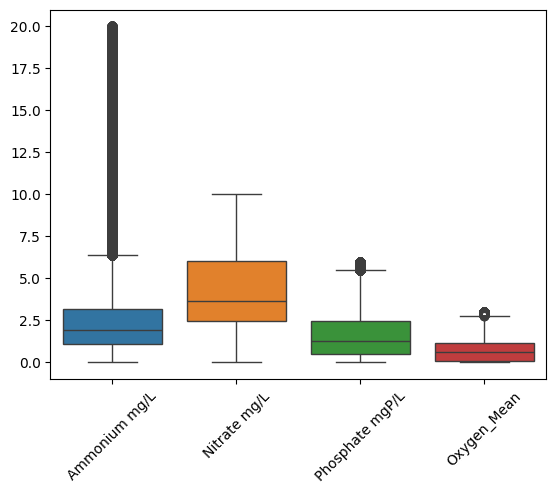

In [180]:
     #check for outliers with boxplot
     sns.boxplot(data=ifd[['Ammonium mg/L', 'Nitrate mg/L', 'Phosphate mgP/L', 'Oxygen_Mean']])
     plt.xticks(rotation=45)
     plt.show()

In [181]:

ifd['Phosphate mgP/L'] = ifd['Phosphate mgP/L'].ffill()#When the data doesn't change rapidly and the last known value is a good estimate for missing values.
#imputation


In [182]:
   print(ifd.isnull().sum())

influentFlow          0
datumBeginMeting      0
datumEindeMeting      0
Ammonium mg/L       192
Nitrate mg/L        192
Phosphate mgP/L       0
Oxygen_Mean         192
dtype: int64


In [183]:
for col in ['Ammonium mg/L','Nitrate mg/L']: #his loop iterates over the specified columns and fills any missing values with the median of each column.
    ifd[col] = ifd[col].fillna(ifd[col].median()) #also robust to outliers

In [184]:
   print(ifd.isnull().sum())

influentFlow          0
datumBeginMeting      0
datumEindeMeting      0
Ammonium mg/L         0
Nitrate mg/L          0
Phosphate mgP/L       0
Oxygen_Mean         192
dtype: int64


In [185]:
ifd['Oxygen_Mean'] = ifd['Oxygen_Mean'].interpolate(method='spline', order=3)## Use spline interpolation  to fill missing values in the 'Nitrate mg/L' column
                                                                                # This method provides a smooth curve that can better capture fluctuations in the data



In [186]:
# Filter the DataFrame for the specific timestamp
specific_row = ifd[ifd['datumBeginMeting'] == '2023-03-01 10:00']

# Print the row
print("Row with timestamp 1-3-2023 10:00 in ifd:")
print(specific_row)

Row with timestamp 1-3-2023 10:00 in ifd:
Empty DataFrame
Columns: [influentFlow, datumBeginMeting, datumEindeMeting, Ammonium mg/L, Nitrate mg/L, Phosphate mgP/L, Oxygen_Mean]
Index: []


In [187]:
#EXTERNAL DATA

In [188]:
edf= edf.drop(columns=['station_code'])
edf = edf.drop(columns=['date'])

In [189]:
def smart_fill(series):
    # Step 1: Fill with mean of forward and backward neighbors where possible
    series = series.copy()
    is_na = series.isna()
    fwd = series.ffill()
    bwd = series.bfill()
    
    # Where both fwd and bwd are available, take the average
    both_available = fwd.notna() & bwd.notna()
    series[is_na & both_available] = (fwd + bwd)[is_na & both_available] / 2

    # Step 2: Fill remaining NaNs with whichever is available (fwd or bwd)
    series = series.ffill().bfill()
    
    return series

# Apply to T10N
edf['T10N'] = smart_fill(edf['T10N'])

In [190]:
# Convert 'datumBeginMeting' to datetime
edf['datumBeginMeting'] = pd.to_datetime(edf['datumBeginMeting'])

edf = format_datetime_columns(edf, date_cols=['datumBeginMeting'])



In [191]:
edf

,hour,T,T10N,TD,DR,RH,N,M,R,S,O,Y,datumBeginMeting
0,1,142,114.0,84,0,0,8.0,0,0,0,0,0,1-1-2023 01:00
1,2,144,114.0,85,0,0,8.0,0,0,0,0,0,1-1-2023 02:00
2,3,139,114.0,82,0,0,8.0,0,0,0,0,0,1-1-2023 03:00
3,4,127,114.0,83,0,-1,8.0,0,1,0,0,0,1-1-2023 04:00
4,5,121,114.0,83,0,0,8.0,0,0,0,0,0,1-1-2023 05:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,20,91,72.0,36,0,0,8.0,0,0,0,0,0,31-12-2023 20:00
17516,21,88,72.0,39,0,-1,8.0,0,1,0,0,0,31-12-2023 21:00
17517,22,81,72.0,46,5,2,8.0,0,1,0,0,0,31-12-2023 22:00
17518,23,77,72.0,48,3,2,8.0,0,1,0,0,0,31-12-2023 23:00


In [192]:
#COMBINED DATASET

#Main Dataset: Minute-level data.
#External Dataset: Hourly data.
#Impact
#Many Unmatched Rows: The minute-level data will not have corresponding hourly entries for most rows, leading to NaN values in the merged DataFrame.

In [193]:
edf = edf[~edf.index.duplicated(keep='first')]
duplicates = edf.index[edf.index.duplicated(keep=False)]
print(duplicates)

Index([], dtype='int64')


In [194]:
edf

,hour,T,T10N,TD,DR,RH,N,M,R,S,O,Y,datumBeginMeting
0,1,142,114.0,84,0,0,8.0,0,0,0,0,0,1-1-2023 01:00
1,2,144,114.0,85,0,0,8.0,0,0,0,0,0,1-1-2023 02:00
2,3,139,114.0,82,0,0,8.0,0,0,0,0,0,1-1-2023 03:00
3,4,127,114.0,83,0,-1,8.0,0,1,0,0,0,1-1-2023 04:00
4,5,121,114.0,83,0,0,8.0,0,0,0,0,0,1-1-2023 05:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,20,91,72.0,36,0,0,8.0,0,0,0,0,0,31-12-2023 20:00
17516,21,88,72.0,39,0,-1,8.0,0,1,0,0,0,31-12-2023 21:00
17517,22,81,72.0,46,5,2,8.0,0,1,0,0,0,31-12-2023 22:00
17518,23,77,72.0,48,3,2,8.0,0,1,0,0,0,31-12-2023 23:00


In [195]:
#T: Temperature (in 0.1 degrees Celsius) at 1.50 m height during the observation

#T10N: Minimum temperature (in 0.1 degrees Celsius) at 10 cm height in the last 6 hours

#TD: Dew point temperature (in 0.1 degrees Celsius) at 1.50 m height during the observation

#DR: Duration of precipitation (in 0.1 hours) per hour period

#RH: Hourly sum of precipitation (in 0.1 mm) (-1 for <0.05 mm)

#N: Cloud cover (upper air coverage in eighths), during observation (9=upper air invisible)

#M: Fog 0=did not occur, 1=did occur in the previous hour and/or during the observation

#R: Rain 0=did not occur, 1=did occur in the previous hour and/or during the observation

#S: Snow 0=not occurred, 1=occurred in the previous hour and/or during the observation

#O: Thunderstorm 0=did not occur, 1=did occur in the previous hour and/or during the observation

#Y: Ice formation 0=not occurred, 1=occurred in the previous hour and/or during the observation

In [196]:
# merge ifd(2024 data) and external data
merged = pd.merge(ifd, edf, on='datumBeginMeting', how='outer')
merged_no_duplicates = merged.drop_duplicates(subset='datumBeginMeting', keep='first')

In [197]:
# Identify duplicates
duplicates = merged[merged.duplicated(subset='datumBeginMeting', keep=False)]
print("Duplicate rows before removal:")


# Remove duplicates from 'merged'
merged = merged.drop_duplicates(subset='datumBeginMeting', keep='first')

# Verify removal by checking for duplicates again
duplicates_after = merged[merged.duplicated(subset='datumBeginMeting', keep=False)]
print("Duplicate rows after removal (should be empty):")
print(duplicates_after)

Duplicate rows before removal:
Duplicate rows after removal (should be empty):
Empty DataFrame
Columns: [influentFlow, datumBeginMeting, datumEindeMeting, Ammonium mg/L, Nitrate mg/L, Phosphate mgP/L, Oxygen_Mean, hour, T, T10N, TD, DR, RH, N, M, R, S, O, Y]
Index: []


In [198]:
#pd.set_option('display.max_rows', 70)
print(merged.head(10))

  influentFlow datumBeginMeting datumEindeMeting  Ammonium mg/L  Nitrate mg/L  \
0     3330.199   1-1-2023 00:00   1-1-2023 00:01          1.310         4.730   
1     3288.798   1-1-2023 00:01   1-1-2023 00:02          1.251         4.730   
2     3260.545   1-1-2023 00:02   1-1-2023 00:03          1.182         4.730   
3     3253.279   1-1-2023 00:03   1-1-2023 00:04          1.181         4.675   
4     3263.276   1-1-2023 00:04   1-1-2023 00:05          1.179         4.605   
5     3274.232   1-1-2023 00:05   1-1-2023 00:06          1.175         4.595   
6     3272.209   1-1-2023 00:06   1-1-2023 00:07          1.172         4.585   
7     3263.931   1-1-2023 00:07   1-1-2023 00:08          1.169         4.576   
8     3274.222   1-1-2023 00:08   1-1-2023 00:09          1.166         4.524   
9      3314.12   1-1-2023 00:09   1-1-2023 00:10          1.162         4.476   

   Phosphate mgP/L  Oxygen_Mean  hour   T  T10N  TD  DR  RH   N   M   R   S  \
0            0.001       1.22

In [199]:
print(merged.isnull().sum())


influentFlow             8
datumBeginMeting         0
datumEindeMeting         8
Ammonium mg/L            8
Nitrate mg/L             8
Phosphate mgP/L          8
Oxygen_Mean              8
hour                516427
T                   516427
T10N                516427
TD                  516427
DR                  516427
RH                  516427
N                   516427
M                   516427
R                   516427
S                   516427
O                   516427
Y                   516427
dtype: int64


In [200]:
merged

,influentFlow,datumBeginMeting,datumEindeMeting,Ammonium mg/L,Nitrate mg/L,Phosphate mgP/L,Oxygen_Mean,hour,T,T10N,TD,DR,RH,N,M,R,S,O,Y
0,3330.199,1-1-2023 00:00,1-1-2023 00:01,1.310,4.730,0.001,1.2200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3288.798,1-1-2023 00:01,1-1-2023 00:02,1.251,4.730,0.001,1.3855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3260.545,1-1-2023 00:02,1-1-2023 00:03,1.182,4.730,0.000,1.6470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3253.279,1-1-2023 00:03,1-1-2023 00:04,1.181,4.675,0.000,1.7685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3263.276,1-1-2023 00:04,1-1-2023 00:05,1.179,4.605,0.000,1.7855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534003,1604.985,9-9-2023 23:55,9-9-2023 23:56,2.720,2.499,3.000,0.7780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
534004,1600.204,9-9-2023 23:56,9-9-2023 23:57,2.739,2.503,2.989,0.7370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
534005,1800.516,9-9-2023 23:57,9-9-2023 23:58,2.919,2.507,2.978,0.7335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
534006,2765.685,9-9-2023 23:58,9-9-2023 23:59,2.955,2.511,2.967,0.7675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [201]:
columns_to_ffill = [ 'hour', 'T', 'T10N', 'TD', 'DR', 'RH', 'N', 'M', 'R', 'S', 'O', 'Y']
merged[columns_to_ffill] = merged[columns_to_ffill].bfill()

In [202]:
merged

,influentFlow,datumBeginMeting,datumEindeMeting,Ammonium mg/L,Nitrate mg/L,Phosphate mgP/L,Oxygen_Mean,hour,T,T10N,TD,DR,RH,N,M,R,S,O,Y
0,3330.199,1-1-2023 00:00,1-1-2023 00:01,1.310,4.730,0.001,1.2200,1.0,142.0,114.0,84.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0
1,3288.798,1-1-2023 00:01,1-1-2023 00:02,1.251,4.730,0.001,1.3855,1.0,142.0,114.0,84.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0
2,3260.545,1-1-2023 00:02,1-1-2023 00:03,1.182,4.730,0.000,1.6470,1.0,142.0,114.0,84.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0
3,3253.279,1-1-2023 00:03,1-1-2023 00:04,1.181,4.675,0.000,1.7685,1.0,142.0,114.0,84.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0
4,3263.276,1-1-2023 00:04,1-1-2023 00:05,1.179,4.605,0.000,1.7855,1.0,142.0,114.0,84.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534003,1604.985,9-9-2023 23:55,9-9-2023 23:56,2.720,2.499,3.000,0.7780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
534004,1600.204,9-9-2023 23:56,9-9-2023 23:57,2.739,2.503,2.989,0.7370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
534005,1800.516,9-9-2023 23:57,9-9-2023 23:58,2.919,2.507,2.978,0.7335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
534006,2765.685,9-9-2023 23:58,9-9-2023 23:59,2.955,2.511,2.967,0.7675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [203]:
print(merged.isnull().sum())


influentFlow         8
datumBeginMeting     0
datumEindeMeting     8
Ammonium mg/L        8
Nitrate mg/L         8
Phosphate mgP/L      8
Oxygen_Mean          8
hour                59
T                   59
T10N                59
TD                  59
DR                  59
RH                  59
N                   59
M                   59
R                   59
S                   59
O                   59
Y                   59
dtype: int64


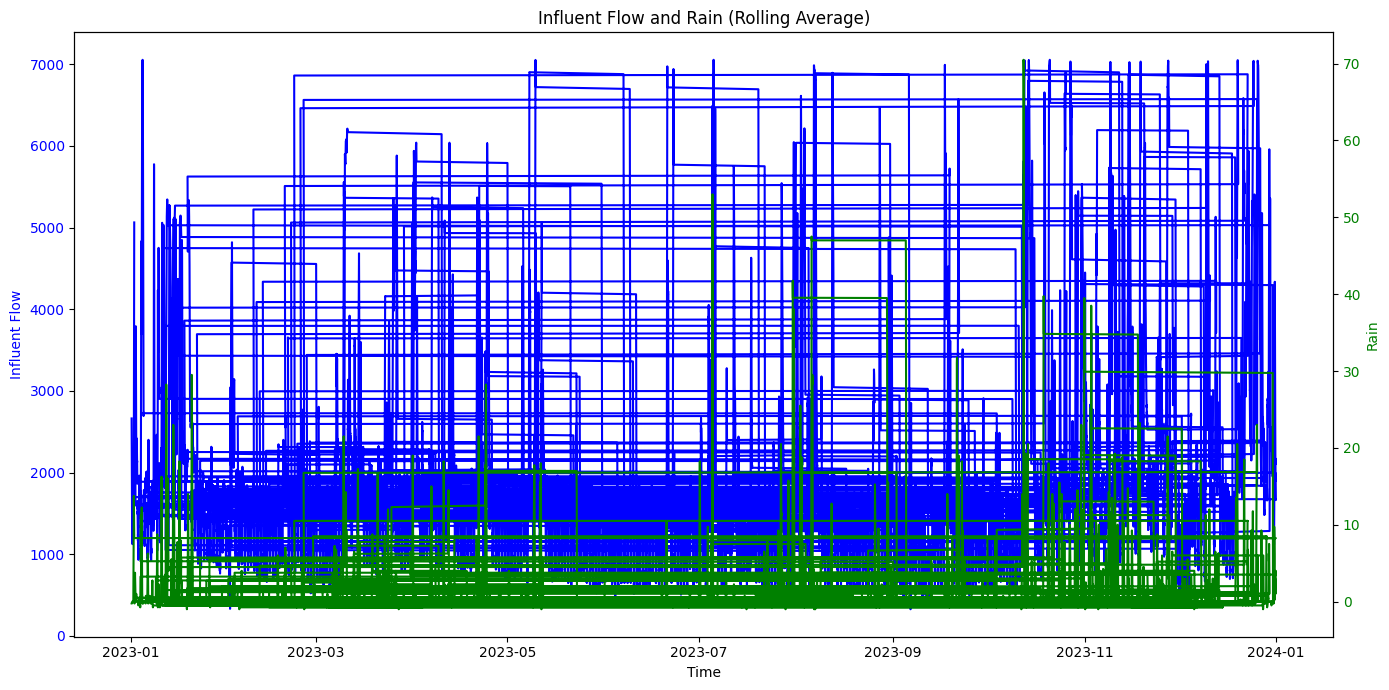

In [204]:

# Check if 'datumBeginMeting' is in the columns
if 'datumBeginMeting' not in merged.columns:
    # Reset index if 'datumBeginMeting' is already set as index
    merged.reset_index(inplace=True)

# Ensure 'datumBeginMeting' is in datetime format
merged['datumBeginMeting'] = pd.to_datetime(merged['datumBeginMeting'], format='%d-%m-%Y %H:%M', errors='coerce')

# Set 'datumBeginMeting' as the index
merged.set_index('datumBeginMeting', inplace=True)

# Calculate rolling averages
rolling_window = 240  # 60-minute window
merged['InfluentFlow_Rolling'] = merged['influentFlow'].rolling(window=rolling_window).mean()
merged['Rain_Rolling'] = merged['RH'].rolling(window=rolling_window).mean()  # Use 'RH' for rain

# Plot with dual axes
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot inflow
ax1.plot(merged.index, merged['InfluentFlow_Rolling'], label='Influent Flow (Rolling Avg)', color='b')
ax1.set_xlabel('Time')
ax1.set_ylabel('Influent Flow', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for rain
ax2 = ax1.twinx()
ax2.plot(merged.index, merged['Rain_Rolling'], label='Rain (Rolling Avg)', color='g')
ax2.set_ylabel('Rain', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Add title and layout
plt.title('Influent Flow and Rain (Rolling Average)')
fig.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_25552\2893675083.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_means = merged.groupby('inflow_bin').mean(numeric_only=True)


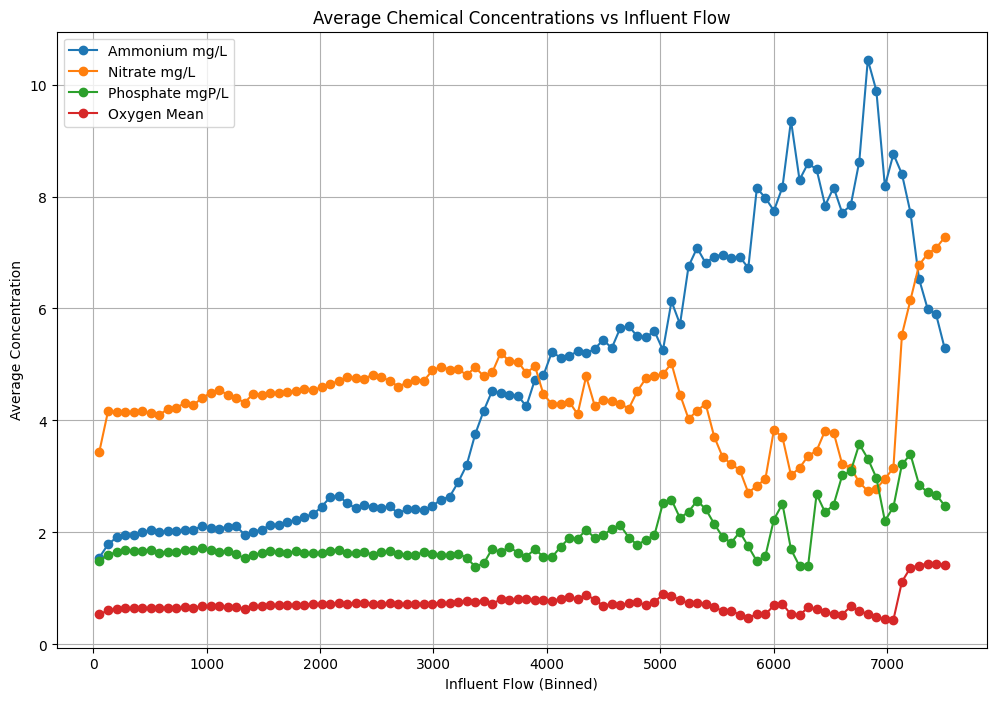

In [205]:

# Check if 'datumBeginMeting' is in the columns
if 'datumBeginMeting' not in merged.columns:
    # Reset index if 'datumBeginMeting' is already set as index
    merged.reset_index(inplace=True)



# Ensures 'datumBeginMeting' is in datetime format
merged['datumBeginMeting'] = pd.to_datetime(merged['datumBeginMeting'], format='%d-%m-%Y %H:%M', errors='coerce')

# Set 'datumBeginMeting' as the index
merged.set_index('datumBeginMeting', inplace=True)

# Convert relevant columns to numeric, coercing errors
columns_to_convert = ['influentFlow', 'Ammonium mg/L', 'Nitrate mg/L', 'Phosphate mgP/L', 'Oxygen_Mean']
for col in columns_to_convert:
    merged[col] = pd.to_numeric(merged[col], errors='coerce')

# Remove rows with NaN values in these columns
merged.dropna(subset=columns_to_convert, inplace=True)

# Bin the inflow data
merged['inflow_bin'] = pd.cut(merged['influentFlow'], bins=100)

# Calculate the mean for each bin
binned_means = merged.groupby('inflow_bin').mean(numeric_only=True)

# Plot the averages
plt.figure(figsize=(12, 8))
plt.plot(binned_means.index.categories.mid, binned_means['Ammonium mg/L'], label='Ammonium mg/L', marker='o')
plt.plot(binned_means.index.categories.mid, binned_means['Nitrate mg/L'], label='Nitrate mg/L', marker='o')
plt.plot(binned_means.index.categories.mid, binned_means['Phosphate mgP/L'], label='Phosphate mgP/L', marker='o')
plt.plot(binned_means.index.categories.mid, binned_means['Oxygen_Mean'], label='Oxygen Mean', marker='o')

# Add labels and legend
plt.xlabel('Influent Flow (Binned)')
plt.ylabel('Average Concentration')
plt.title('Average Chemical Concentrations vs Influent Flow')
plt.legend()
plt.grid(True)
plt.show()




#

In [206]:
merged['wet_day'] = merged['RH'] > 0
merged['dry_day'] = merged['RH'] < 0.05

Text(0.5, 1.0, 'Class Balance: Wet vs Dry Days')

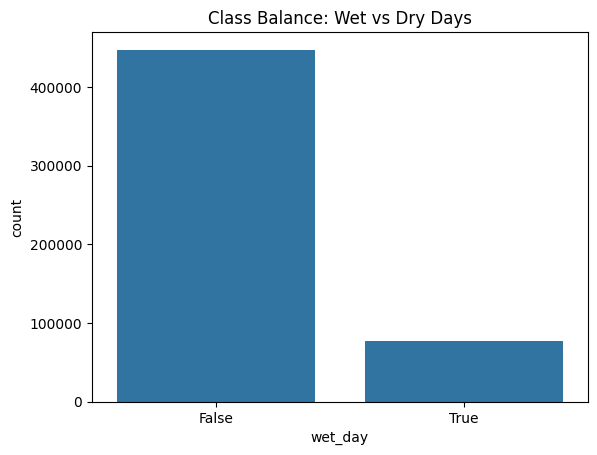

In [207]:
sns.countplot(data=merged, x='wet_day')
plt.title("Class Balance: Wet vs Dry Days")

<Figure size 1200x600 with 0 Axes>

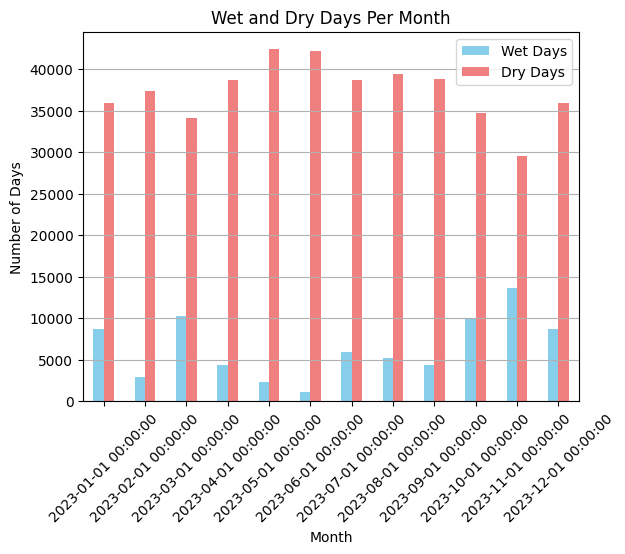

In [208]:

# Check if 'datumBeginMeting' is in the columns
if 'datumBeginMeting' not in merged.columns:
    # Reset index if 'datumBeginMeting' is already set as index
    merged.reset_index(inplace=True)

# Ensure 'datumBeginMeting' is in datetime format and set as index
merged['datumBeginMeting'] = pd.to_datetime(merged['datumBeginMeting'])
merged.set_index('datumBeginMeting', inplace=True)

# Calculate wet and dry days per month
monthly_data = merged.resample('MS').agg({'wet_day': 'sum', 'dry_day': 'sum'})

# Plot
plt.figure(figsize=(12, 6))
monthly_data.plot(kind='bar', stacked=False, color=['skyblue', 'lightcoral'])
plt.title("Wet and Dry Days Per Month")
plt.xlabel("Month")
plt.ylabel("Number of Days")
plt.xticks(rotation=45)
plt.legend(['Wet Days', 'Dry Days'])
plt.grid(axis='y')
plt.show()

Average phosphate concentration by day type:
day_type
Dry      1.688990
Other    2.173932
Wet      1.769761
Name: Phosphate mgP/L, dtype: float64


C:\Users\User\AppData\Local\Temp\ipykernel_25552\119896205.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


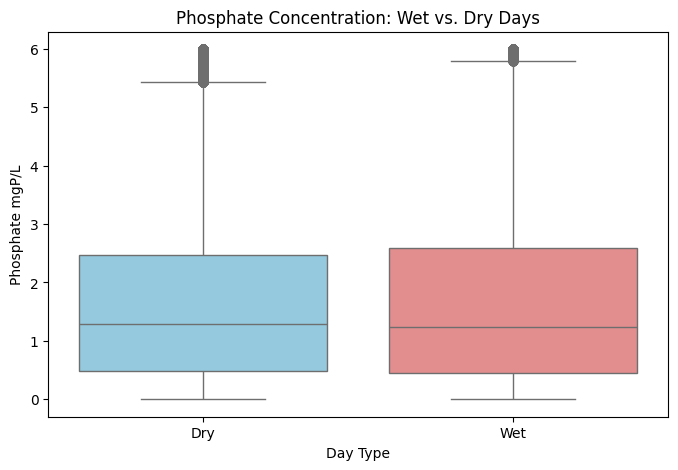

In [209]:
# Create a 'day_type' column: 'Wet' if wet_day==1, 'Dry' if dry_day==1, else 'Other'
merged['day_type'] = np.where(merged['wet_day'] == 1, 'Wet',
                      np.where(merged['dry_day'] == 1, 'Dry', 'Other'))

# Calculate mean phosphate for each day type
phosphate_by_daytype = merged.groupby('day_type')['Phosphate mgP/L'].mean()
print("Average phosphate concentration by day type:")
print(phosphate_by_daytype)

# Boxplot for visual comparison (only Wet and Dry days)
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=merged[merged['day_type'].isin(['Wet', 'Dry'])],
    x='day_type',
    y='Phosphate mgP/L',
    palette=['skyblue', 'lightcoral']
)
plt.title('Phosphate Concentration: Wet vs. Dry Days')
plt.xlabel('Day Type')
plt.ylabel('Phosphate mgP/L')
plt.show()

Text(0.5, 1.0, 'Feature Correlation with Wet Days')

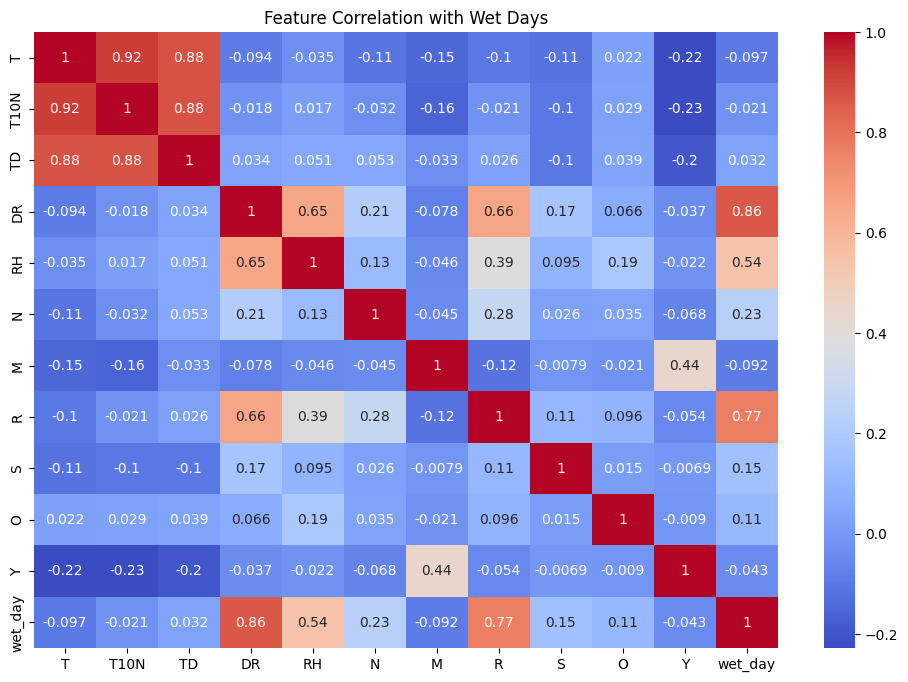

In [210]:
# Set the figure size
plt.figure(figsize=(12, 8))

cols = ['T', 'T10N', 'TD', 'DR', 'RH', 'N', 'M', 'R', 'S', 'O', 'Y', 'wet_day']
sns.heatmap(merged[cols].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Wet Days")

Text(0.5, 1.0, 'Feature Correlation with ammonium')

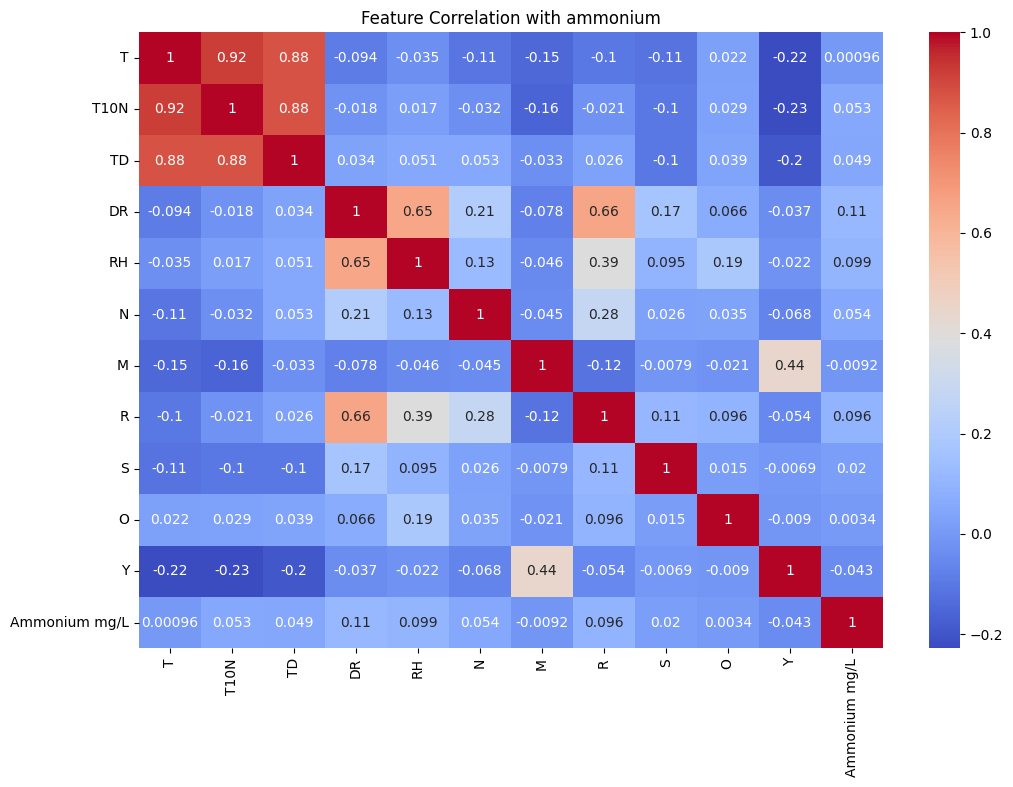

In [211]:
# Set the figure size
plt.figure(figsize=(12, 8))

cols = ['T', 'T10N', 'TD', 'DR', 'RH', 'N', 'M', 'R', 'S', 'O', 'Y', 'Ammonium mg/L']
sns.heatmap(merged[cols].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with ammonium")

Text(0.5, 1.0, 'Feature Correlation with Oxygen')

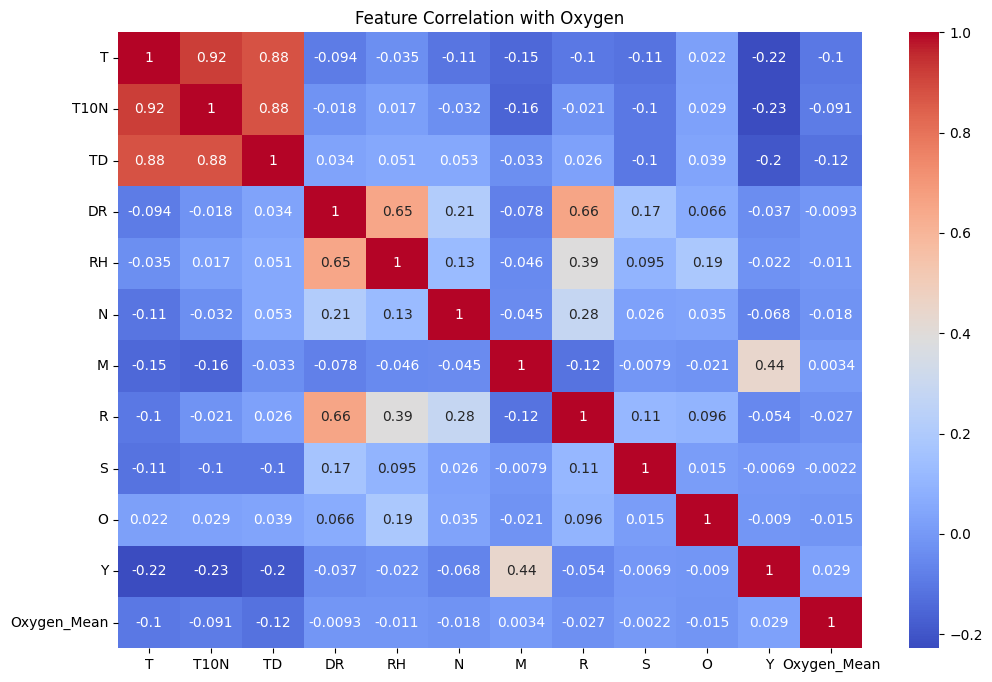

In [212]:
# Set the figure size
plt.figure(figsize=(12, 8))

cols = ['T', 'T10N', 'TD', 'DR', 'RH', 'N', 'M', 'R', 'S', 'O', 'Y', 'Oxygen_Mean']
sns.heatmap(merged[cols].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Oxygen")

T     0.039541
TD    0.029346
DR    0.027861
RH    0.018109
R     0.002724
Name: Phosphate mgP/L, dtype: float64


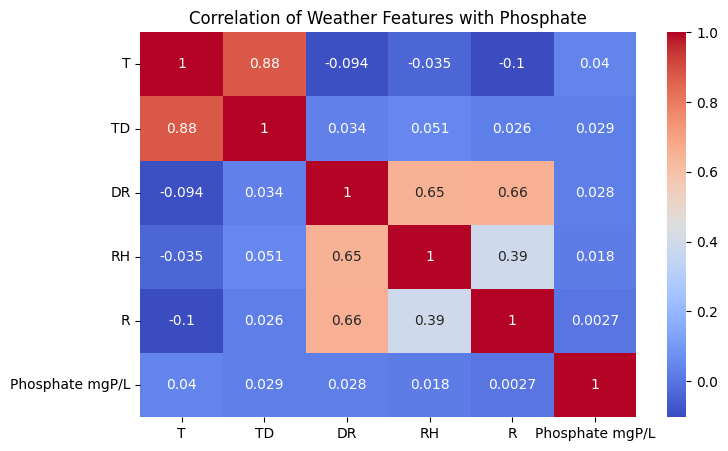

In [213]:
# List of most likely helpful features
cols = ['T', 'TD', 'DR', 'RH', 'R']

# Calculate correlation with phosphate
correlations = merged[cols + ['Phosphate mgP/L']].corr()['Phosphate mgP/L'].sort_values(ascending=False)

# Show only the weather features (not phosphate with itself)
print(correlations[cols])

corr_matrix = merged[cols + ['Phosphate mgP/L']].corr()
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation of Weather Features with Phosphate')
plt.show()

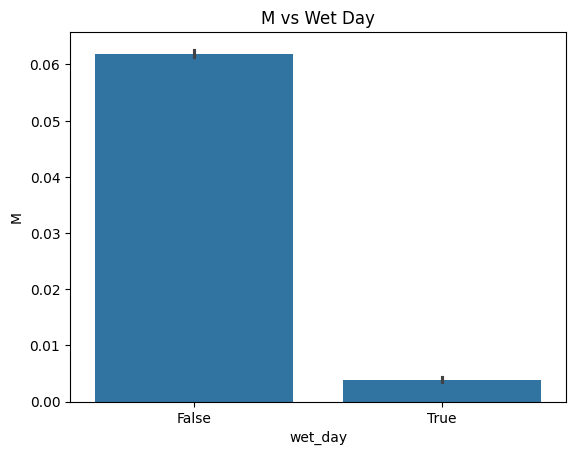

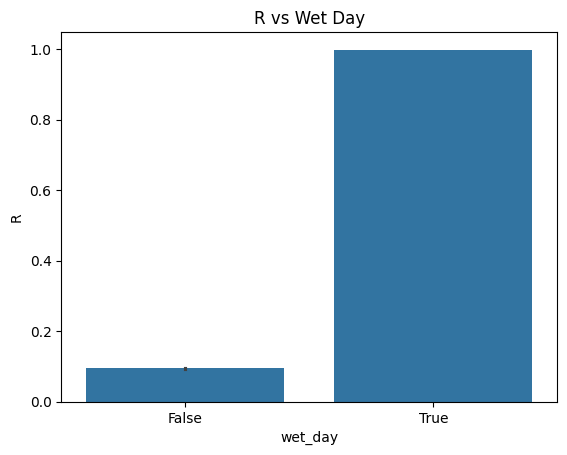

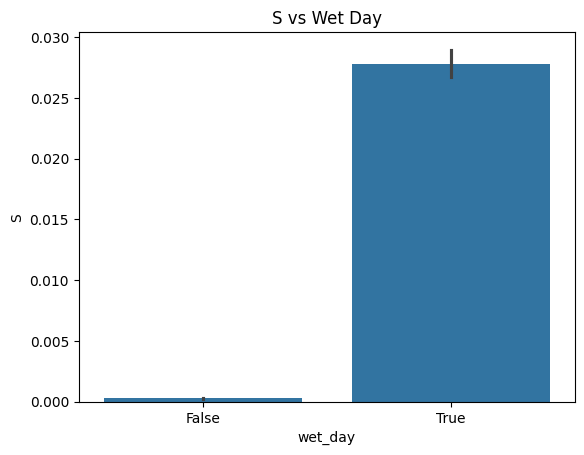

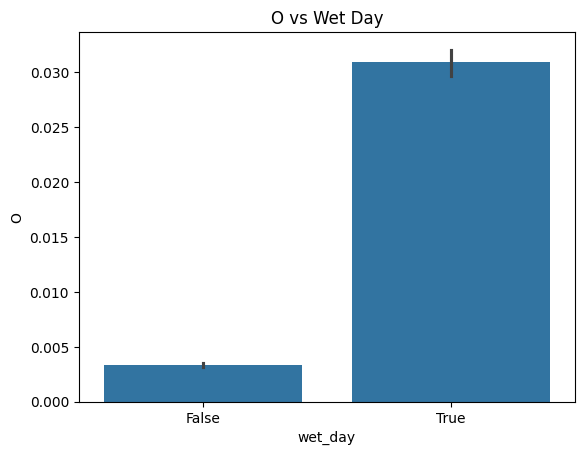

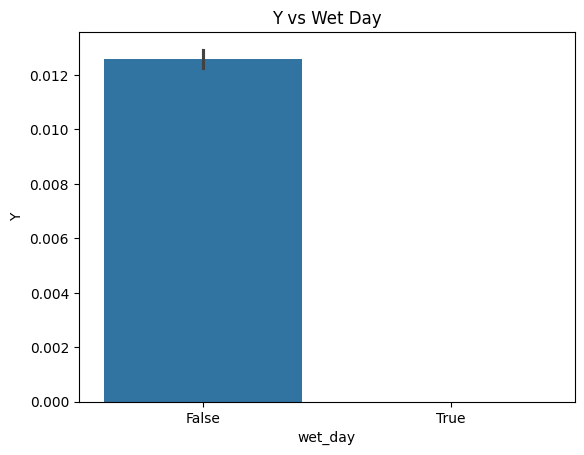

In [214]:

# Check if 'datumBeginMeting' is in the columns
if 'datumBeginMeting' not in merged.columns:
    # Reset index if 'datumBeginMeting' is already set as index
    merged.reset_index(inplace=True)

# Ensure 'datumBeginMeting' is in datetime format and set as index
merged['datumBeginMeting'] = pd.to_datetime(merged['datumBeginMeting'])
merged.set_index('datumBeginMeting', inplace=True)


binary_cols = ['M', 'R', 'S', 'O', 'Y']
for col in binary_cols:
    sns.barplot(data=merged, x='wet_day', y=col)
    plt.title(f"{col} vs Wet Day")
    plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_25552\2476254031.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  phosphate_by_inflow = merged.groupby('inflow_category')['Phosphate mgP/L'].mean()
C:\Users\User\AppData\Local\Temp\ipykernel_25552\2476254031.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged, x='inflow_category', y='Phosphate mgP/L', palette='Set2')


inflow_category
Low       1.646515
Medium    1.635603
High      1.820837
Name: Phosphate mgP/L, dtype: float64


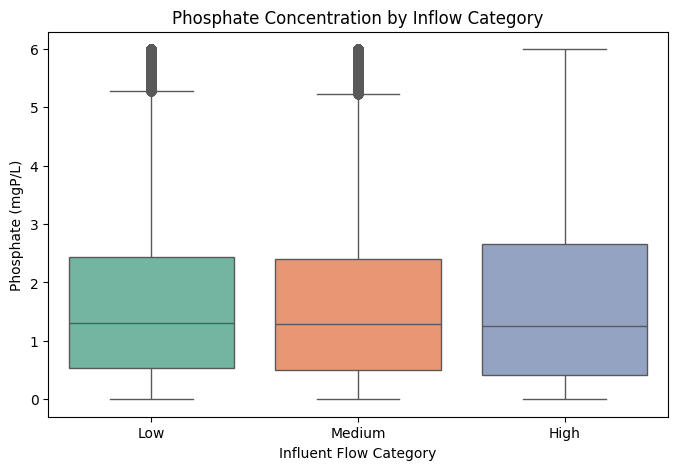

In [215]:
# Create inflow categories based on quantiles
merged['inflow_category'] = pd.qcut(merged['influentFlow'], q=3, labels=['Low', 'Medium', 'High'])

# Calculate mean phosphate for each inflow category
phosphate_by_inflow = merged.groupby('inflow_category')['Phosphate mgP/L'].mean()
print(phosphate_by_inflow)

plt.figure(figsize=(8, 5))
sns.boxplot(data=merged, x='inflow_category', y='Phosphate mgP/L', palette='Set2')
plt.title('Phosphate Concentration by Inflow Category')
plt.xlabel('Influent Flow Category')
plt.ylabel('Phosphate (mgP/L)')
plt.show()

inflow_4000
High (>4000)    2.230024
Low (<=4000)    1.633566
Name: Phosphate mgP/L, dtype: float64


C:\Users\User\AppData\Local\Temp\ipykernel_25552\1093483542.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged, x='inflow_4000', y='Phosphate mgP/L', palette='Set2')


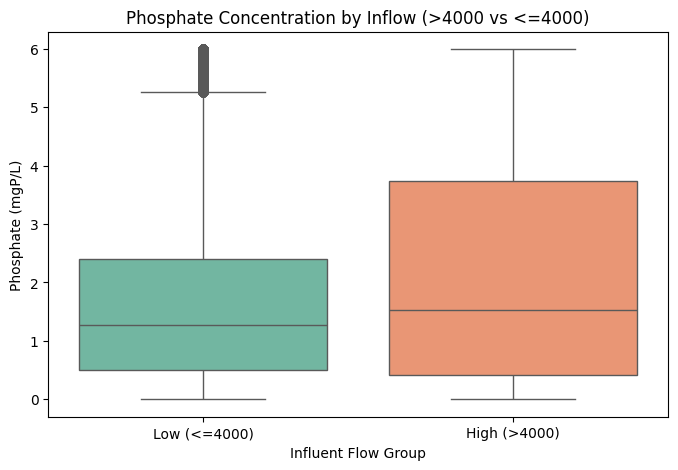

In [216]:

# Create a new column for inflow category based on the 4000 threshold
merged['inflow_4000'] = np.where(merged['influentFlow'] > 4000, 'High (>4000)', 'Low (<=4000)')

# Calculate mean phosphate for each inflow group
phosphate_by_inflow = merged.groupby('inflow_4000')['Phosphate mgP/L'].mean()
print(phosphate_by_inflow)

# Optional: Boxplot to visualize the distribution
plt.figure(figsize=(8, 5))
sns.boxplot(data=merged, x='inflow_4000', y='Phosphate mgP/L', palette='Set2')
plt.title('Phosphate Concentration by Inflow (>4000 vs <=4000)')
plt.xlabel('Influent Flow Group')
plt.ylabel('Phosphate (mgP/L)')
plt.show()

In [217]:
# Calculate the mean oxygen value for the whole database
oxygen_mean = merged['Oxygen_Mean'].mean()
print(f"Mean Oxygen (mg/L) for the whole database: {oxygen_mean:.3f}")

Mean Oxygen (mg/L) for the whole database: 0.684


In [218]:
# 1. Resample to daily max ammonium
#daily_max_ammonium = df['Ammonium mg/L'].resample('D').max()

# 2. Find the top  days with highest ammonium spikes
#N = 5  # show Number of top spike days 
#top_spike_days = daily_max_ammonium.sort_values(ascending=False).head(N)
#print("Top ammonium spike days:")
#print(top_spike_days)

## 3. Plot the ammonium and nitrate for those days
#for day in top_spike_days.index:
  #  day_data = df.loc[day.strftime('%Y-%m-%d')]
   # plt.figure(figsize=(10, 4))
    #plt.plot(day_data.index, day_data['Ammonium mg/L'], label='Ammonium mg/L', color='blue')
   # plt.plot(day_data.index, day_data['Phosphate mgP/L'], label='Phosphate mgP/L', color='orange')
   # plt.title(f'Ammonium and Phosphate on {day.date()}')
    #plt.xlabel('Time')
   # plt.ylabel('Concentration (mg/L)')
    #plt.legend()
    #plt.tight_layout()
    #plt.show()

In [219]:
# 1. Resample to daily max phosphate
#daily_max_ammonium = df['Phosphate mgP/L'].resample('D').max()

# 2. Find the top N days with highest phospate spikes
#N = 5  # Number of top spike days to show
#top_spike_days = daily_max_ammonium.sort_values(ascending=False).head(N)
print("Top phosphate spike days:")
#print(top_spike_days)

# 3. Plot ammonium and nitrate for those days
#for day in top_spike_days.index:
    #day_data = df.loc[day.strftime('%Y-%m-%d')]
   # plt.figure(figsize=(10, 4))
   # plt.plot(day_data.index, day_data['Phosphate mgP/L'], label='Phosphate mgP/L', color='orange')
   # plt.title(f'Phosphate and Amonium on {day.date()}')
   # plt.xlabel('Time')
   # plt.ylabel('Concentration (mg/L)')
   # plt.legend()
   # plt.tight_layout()
   # plt.show()

Top phosphate spike days:


In [220]:
# 1. Resample to daily max phosphate
#daily_max_phosphate = df['Phosphate mgP/L'].resample('D').max()

# 2. Find the top N days with lowest phosphate spikes
#N = 5  # Number of lowest spike days to show
#lowest_spike_days = daily_max_phosphate.sort_values(ascending=True).head(N)
#print("Lowest phosphate spike days:")
#print(lowest_spike_days)

# 3. Plot ammonium and phosphate for those days
#for day in lowest_spike_days.index:
  #  day_data = df.loc[day.strftime('%Y-%m-%d')]
  #  plt.figure(figsize=(10, 4))
   # plt.plot(day_data.index, day_data['Ammonium mg/L'], label='Ammonium mg/L', color='blue')
   # plt.plot(day_data.index, day_data['Phosphate mgP/L'], label='Phosphate mgP/L', color='orange')
   # plt.title(f'Phosphate and Ammonium on {day.date()} (Lowest Spikes)')
    #plt.xlabel('Time')
   # plt.ylabel('Concentration (mg/L)')
   # plt.legend()
   # plt.tight_layout()
   # #plt.show()

In [221]:
# Get all unique days in your data
#all_days = df.index.normalize().unique()

# Pick a random day (as a numpy.datetime64)
#random_day = np.random.choice(all_days)

# Convert to pandas Timestamp for date handling
#random_day_ts = pd.Timestamp(random_day)
#print(f"Randomly selected day: {random_day_ts.date()}")

# Extract data for that day
#day_data = df.loc[random_day_ts.strftime('%Y-%m-%d')]

# Plot
#plt.figure(figsize=(10, 4))
#plt.plot(day_data.index, day_data['Ammonium mg/L'], label='Ammonium mg/L', color='blue')
#plt.plot(day_data.index, day_data['Phosphate mgP/L'], label='Phosphate mgP/L', color='orange')
#plt.title(f'Phosphate and Ammonium on {random_day_ts.date()} (Random Day)')
#plt.xlabel('Time')
#plt.ylabel('Concentration (mg/L)')
#plt.legend()
#plt.tight_layout()
#plt.show()

In [222]:
#from sklearn.preprocessing import StandardScaler

# 1. Remove duplicate timestamps
#df = df[~df.index.duplicated(keep='first')]

# 2. Select only the relevant numeric columns
#df_numeric = df[['Ammonium mg/L', 'Phosphate mgP/L']]

# 3. Resample to 1-minute intervals (use 'min' instead of 'T')
#df_numeric = df_numeric.resample('1min').mean()

# 4. Drop rows with NaNs in either series
#df_numeric = df_numeric.dropna()

# 5. Optionally, clip outliers (e.g., to 1st and 99th percentiles)
#for col in ['Ammonium mg/L', 'Phosphate mgP/L']:
   # lower, upper = df_numeric[col].quantile([0.01, 0.99])
   # df_numeric[col] = df_numeric[col].clip(lower, upper)

# 6. Standardize both series
#scaler = StandardScaler()
#ammonium = scaler.fit_transform(df_numeric['Ammonium mg/L'].values.reshape(-1, 1)).flatten()
#phosphate = scaler.fit_transform(df_numeric['Phosphate mgP/L'].values.reshape(-1, 1)).flatten()

# 7. Cross-correlation
#corr = np.correlate(ammonium, phosphate, mode='full')
#lags = np.arange(-len(ammonium) + 1, len(ammonium))

# 8. Plot
#plt.figure(figsize=(10, 4))
#plt.plot(lags, corr)
#plt.title('Cross-correlation: Ammonium vs. Phosphate (All Data)')
#plt.xlabel('Lag (minutes)')
#plt.ylabel('Correlation')
#plt.grid(True)
#plt.tight_layout()
#plt.show()

# 9. Find and print the lag with maximum correlation
#max_lag = lags[np.argmax(corr)]
#print(f"Maximum correlation at lag: {max_lag} minutes")

In [223]:
#from scipy.signal import correlate
#from scipy.stats import zscore

# Use z-score standardized series (already close from StandardScaler)
#ammonium_z = zscore(df_numeric['Ammonium mg/L'])
#phosphate_z = zscore(df_numeric['Phosphate mgP/L'])

#corr = correlate(ammonium_z, phosphate_z, mode='full')
#lags = np.arange(-len(ammonium_z) + 1, len(ammonium_z))

#plt.plot(lags, corr)
#plt.title("Normalized Cross-correlation: Ammonium vs Phosphate")
#plt.xlabel("Lag (minutes)")
#plt.ylabel("Correlation coefficient")
#plt.grid(True)
#plt.show()

#max_lag = lags[np.argmax(corr)]
#print(f"Max normalized correlation at lag: {max_lag} minutes")

Available columns:
['influentFlow', 'datumBeginMeting', 'datumEindeMeting', 'Ammonium mg/L', 'Nitrate mg/L', 'Phosphate mgP/L', 'Oxygen_Mean']


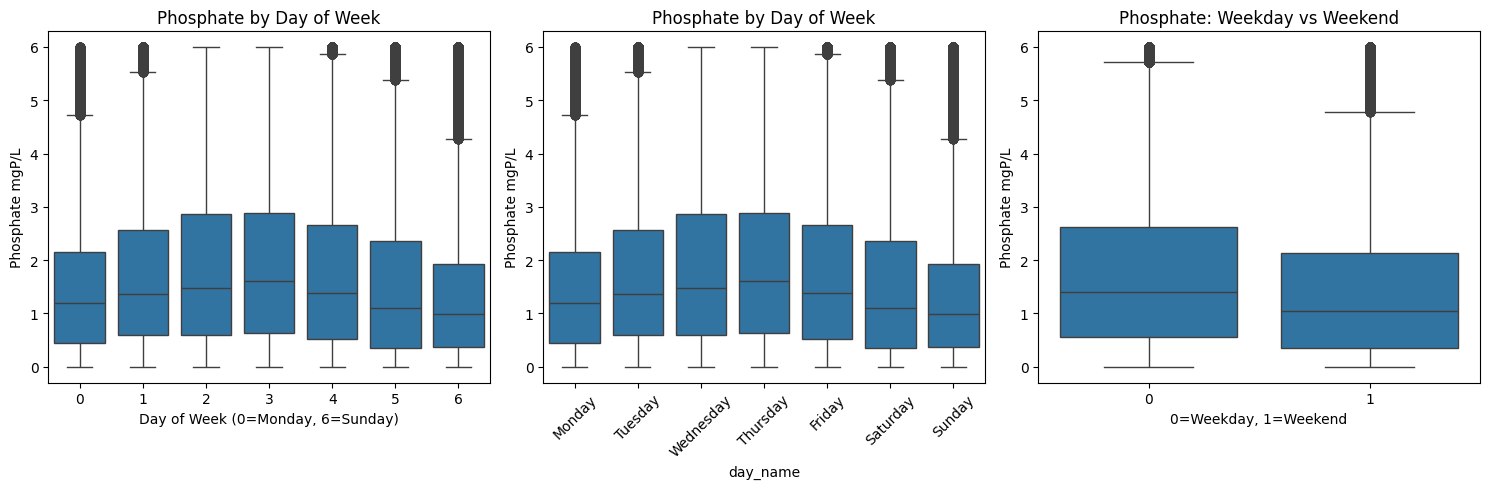

In [225]:

# Step 1: First, let's check what columns you have
print("Available columns:")
print(df.columns.tolist())

# Step 2: Convert your datetime column to datetime format and set as index
# Adjust the column name if it's different in your DataFrame
datetime_col = 'datumBeginMeting'  # Change this to match your actual column name

# Convert to datetime and set as index
df[datetime_col] = pd.to_datetime(df[datetime_col], format='%d-%m-%Y %H:%M')
df = df.set_index(datetime_col)

# Step 3: Now you can extract day of week information
df['dayofweek'] = df.index.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

# Also create day names for better visualization
df['day_name'] = df.index.day_name()

# Step 4: Convert Phosphate to numeric if it's not already
df['Phosphate mgP/L'] = pd.to_numeric(df['Phosphate mgP/L'], errors='coerce')

# Step 5: Create the boxplots
plt.figure(figsize=(15, 5))

# Plot 1: Phosphate by day of week (numeric)
plt.subplot(1, 3, 1)
sns.boxplot(x='dayofweek', y='Phosphate mgP/L', data=df)
plt.title('Phosphate by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')

# Plot 2: Phosphate by day name (more readable)
plt.subplot(1, 3, 2)
sns.boxplot(x='day_name', y='Phosphate mgP/L', data=df, 
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Phosphate by Day of Week')
plt.xticks(rotation=45)

# Plot 3: Weekday vs Weekend
plt.subplot(1, 3, 3)
sns.boxplot(x='is_weekend', y='Phosphate mgP/L', data=df)
plt.title('Phosphate: Weekday vs Weekend')
plt.xlabel('0=Weekday, 1=Weekend')

plt.tight_layout()
plt.show()

In [226]:
print(df.groupby('is_weekend')['Phosphate mgP/L'].describe())

               count      mean       std  min    25%    50%    75%    max
is_weekend                                                               
0           374039.0  1.798402  1.546617  0.0  0.553  1.395  2.616  5.994
1           151200.0  1.459802  1.407405  0.0  0.360  1.041  2.131  5.993


In [227]:
# --- 1. Identify long low-phosphate periods ---
low_threshold = 0.5  # adjust as needed
df['is_low_phosphate'] = df['Phosphate mgP/L'] < low_threshold

# Label each continuous low period with a unique ID
df['low_group'] = (df['is_low_phosphate'] != df['is_low_phosphate'].shift()).cumsum()

# Filter only the low periods
low_periods = df[df['is_low_phosphate']].groupby('low_group')

# Collect period info
periods = []
for group, data in low_periods:
    start = data.index[0]
    end = data.index[-1]
    duration = end - start
    min_value = data['Phosphate mgP/L'].min()
    periods.append({'Start': start, 'End': end, 'Duration': duration, 'Min Value': min_value})

# Convert to DataFrame for easy viewing
periods_df = pd.DataFrame(periods)

# Filter for periods longer than 5 hours
long_periods_df = periods_df[periods_df['Duration'] > pd.Timedelta(hours=5)]
print("Long low-phosphate periods (>5h):")
print(long_periods_df)

# --- 2. Create a mask for all timestamps in long low-phosphate periods ---
long_low_mask = pd.Series(False, index=df.index)
for _, row in long_periods_df.iterrows():
    long_low_mask.loc[row['Start']:row['End']] = True

# --- 3. Compare feature statistics ---
features_to_compare = ['influentFlow', 'Ammonium mg/L']

for feat in features_to_compare:
    mean_long_low = df.loc[long_low_mask, feat].mean()
    mean_other = df.loc[~long_low_mask, feat].mean()
    print(f"\n{feat}:")
    print(f"  Mean during long low-phosphate: {mean_long_low:.3f}")
    print(f"  Mean outside long low-phosphate: {mean_other:.3f}")
    
# Ensure Start is a datetime
long_periods_df['Month'] = pd.to_datetime(long_periods_df['Start']).dt.month
# Count number of long low-phosphate periods per month
print(long_periods_df['Month'].value_counts().sort_index())
# , extract the hour from the Start time
long_periods_df['Start_Hour'] = pd.to_datetime(long_periods_df['Start']).dt.hour
# Now count the number of long low-phosphate periods starting at each hour
print(long_periods_df['Start_Hour'].value_counts().sort_index())


# For only long low-phosphate periods (>5h)
long_periods_df['Start_DayOfWeek'] = pd.to_datetime(long_periods_df['Start']).dt.dayofweek
print(long_periods_df['Start_DayOfWeek'].value_counts().sort_index())



long_periods_df['Duration_hours'] = periods_df['Duration'].dt.total_seconds() / 3600
long_periods_df['Duration_hours'].hist(bins=20)
plt.xlabel('Duration (hours)')
plt.ylabel('Number of Periods')
plt.title('Distribution of Long Low-Phosphate Period Durations')
plt.show()

Long low-phosphate periods (>5h):
                   Start                 End        Duration  Min Value
14   2023-01-02 03:51:00 2023-01-02 09:11:00 0 days 05:20:00      0.001
91   2023-01-15 00:29:00 2023-01-15 08:26:00 0 days 07:57:00      0.008
255  2023-02-06 14:26:00 2023-02-06 20:15:00 0 days 05:49:00      0.013
527  2023-03-11 02:25:00 2023-03-12 07:46:00 1 days 05:21:00      0.000
545  2023-03-13 11:58:00 2023-03-13 18:27:00 0 days 06:29:00      0.002
680  2023-03-26 05:26:00 2023-03-26 12:07:00 0 days 06:41:00      0.007
686  2023-03-27 01:54:00 2023-03-27 07:15:00 0 days 05:21:00      0.000
717  2023-04-01 08:48:00 2023-04-01 18:37:00 0 days 09:49:00      0.012
721  2023-04-02 08:28:00 2023-04-02 15:04:00 0 days 06:36:00      0.000
756  2023-04-07 02:50:00 2023-04-07 08:15:00 0 days 05:25:00      0.021
805  2023-04-11 02:09:00 2023-04-11 10:35:00 0 days 08:26:00      0.025
819  2023-04-12 19:26:00 2023-04-13 04:02:00 0 days 08:36:00      0.079
823  2023-04-13 13:16:00 2023-

TypeError: Could not convert string '1671.3861462.562877.567364.858270.527281.676800.2931526.3741641.9291631.2331560.1141437.9511177.478818.47276.392247.065375.124655.6321360.6281662.4611688.6671660.7751496.5651198.48513.366247.487241.461304.1581040.2641445.3851680.3351698.8391639.811484.2641059.208424.567350.482292.252459.0281191.2572391.5552895.9942888.1042803.1032625.1532046.4311561.5211494.5611496.7621808.0472511.9853053.6672922.1482875.0972797.4212617.2112014.6361562.2651495.4451503.1591793.3972455.4583061.7973160.8753029.5932854.1822611.8181973.8591527.8341512.251670.582541.3271471.9851831.4591865.8351860.6621721.1951425.956871.092300.002288.417288.725349.1111047.1481813.4511920.4961938.5871882.8951608.0321064.845379.961276.989273.723357.984807.761497.711881.8341891.9481850.9981703.4621281.0131697.3241510.0471507.9781506.4371851.5122764.3122923.5273137.0773061.7282918.6632799.7792140.1011546.4281506.0031504.0551627.0792412.4642894.9913014.7483208.2823068.6552945.2922586.1111790.3331506.571502.9421502.4541859.0162762.4612944.1782949.6123124.9172937.5622664.602880.843356.769342.165290.123673.0431517.0941651.4781629.9421698.6631643.1031516.991934.651351.466215.145213.889415.5111060.1851570.6631616.0221608.7691681.741561.0171057.512528.28222.779215.332359.708964.4861553.5711649.0191625.6591512.0151459.871845.363773.7121548.1911579.3231831.4612552.3062857.3122880.6462823.9612653.3782555.1761963.2171544.9961456.5421540.0291772.5932459.5422821.7922851.2622824.2382943.0312670.0952059.7981556.2181445.5431447.2421732.0212591.0532909.1822423.5711759.9551785.1791386.593738.186275.691205.055208.568529.7321345.7841600.2861596.7661759.571643.891515.859957.641431.902256.696309.748577.9271474.5561860.4531900.9431829.2561699.0061637.3811590.0771567.4141566.321390.524789.44373.023358.2971432.4921914.5692704.8913256.9693149.2543069.8723045.8263041.1743041.7563045.823043.6633046.7833118.0563138.2173149.4023194.4543143.9463134.2783119.6563080.0283066.0563223.5343169.7683179.9643212.9413297.8313357.3823376.1133384.5933327.7623304.5694249.8334495.124499.3894519.7114563.1224578.4234684.0864722.3754708.7164600.1344554.7554547.2974556.9674573.4794578.7014592.074652.9014746.0554769.8514783.3984779.7234706.1184657.7754639.8744673.6954722.2164729.1364730.0654763.9794891.5754931.6844925.4934873.8234891.9514916.4034931.3524937.674942.4414891.6354981.1475065.3155115.8925018.5364910.8624921.1114906.8594900.7824861.6614837.1424851.4064942.9764989.0674974.194908.3964766.5914744.3695682.95917.9075891.2756004.9045296.0515406.95402.3195360.1285287.3555255.4755254.3895256.2555252.6535206.9685194.5775212.5965301.6225317.7865315.8695223.6785192.8535193.2475192.6165211.8265254.4355283.1135268.8875355.255390.7245378.1515220.1465162.7155166.8845182.5845190.5185185.3275175.9995176.2915287.3525390.1315393.925310.6275265.3665252.445260.7535212.9055162.4135166.4915186.9675186.0775243.625313.6765316.2915252.7815193.2765178.8025167.6245182.7955186.9775188.8435200.2925188.4015191.1515321.3145407.4545394.8285293.0435264.335259.9965216.4445172.1225183.7695190.9675183.6185181.8365190.3475250.125310.315362.4425329.4675277.9765248.9855248.3685249.6785198.6595158.85160.7675165.2355177.9615179.3625177.7825235.1035299.585321.6515247.7925197.1615183.3095184.9045183.225187.2785171.2825178.9655181.3165186.8075190.175196.145191.7915281.5135321.5465295.8025070.0495013.45024.3265015.1435012.1255014.0495021.625022.6435017.6235015.4165018.395020.4635020.5055026.375019.7275024.6025024.3875014.8775017.1235010.5894967.2264739.4634696.3044735.3944743.564749.2094804.2664926.7285028.0465033.0185030.0635031.5045021.7855017.7995011.1325018.7025024.4445025.7995028.3545019.6175007.1775006.8334998.9425016.4335031.5775023.985030.1915023.2865024.95018.0535027.1095033.0365030.1155024.0195014.4755000.8114962.4024938.4654919.714903.1034897.1824886.2814887.5864889.4774884.5934877.4834874.2334877.6784875.5434861.2684846.9894868.8194917.475023.9095030.3215012.7044938.24853.224836.0074827.5194807.5274787.8614773.274762.6014763.1394769.8584773.5054778.9974769.1264777.0834773.6814776.7844771.0964758.2294808.2154830.9754846.2314854.9064819.0754777.8724753.8554759.2624766.0544766.5224786.5964838.8454852.3154852.0544805.9494777.0094760.5774756.0964752.3024752.7124740.7824725.3624724.9684721.0814805.4524878.2164891.3974801.9064780.9374770.184768.9424772.3784773.0034789.324838.6894856.9084870.9644859.3644814.8354776.1744754.1384743.3334733.9914722.7584704.7734706.7544713.2724801.2984825.4984835.1624841.4354807.3924779.9524776.3374776.9454771.7574764.9554756.64758.5864753.9354744.0964738.6454730.184720.844720.0464713.1414693.5734719.2194782.6314807.2164803.8514791.4534751.0984777.1524837.7324832.254736.7134703.5854680.5514670.824666.0514670.8784676.9534682.4484705.1024716.2234729.3264719.1414704.4364703.6634697.5934683.5234662.7244624.3164611.4984607.2964657.5174703.2044725.8194734.6884720.0154676.9744658.0084639.374635.7684631.0954625.5174633.9774650.7284666.4014672.4174693.4034695.5254699.3824673.2224638.6034636.4674636.0934620.7594615.8754609.4244614.8114706.9284794.7354801.6374704.2494655.6284612.9574616.1164625.354624.3944617.094601.1574592.2294589.2374587.3974585.4624572.5024570.0244575.5484570.7274567.854569.1034564.6224578.0754619.6294625.2864646.7654661.5444605.74581.2814563.3034547.684549.3534533.0454524.6844522.114516.7024525.4564524.5534530.6164536.6894540.914547.2844553.5034552.6144562.3284565.8144551.7734540.8154546.9564642.6674654.3364372.1123362.823378.4263374.6743363.7873296.2213264.7823258.3583262.7013280.2043274.6783275.9813271.2293271.5143279.4353286.6152444.1891960.581944.5521961.922025.9092046.1942064.1862074.372026.5122008.8811992.1381968.7171964.9411965.1532007.422035.0822038.7172021.531986.5441984.9511996.1761986.0481989.0721996.2411983.71962.0671943.3781953.9392068.5432091.9362033.2761972.1371947.9231960.7721975.5852190.5033245.5463232.1023250.7263258.8263273.7133271.4453280.7683281.3133266.563263.423263.0913268.5523306.763353.4093399.8853391.6423335.4573254.6413198.8583179.8673180.3233178.0083098.1973117.6583137.5033130.733108.763094.6012990.5331865.3011726.5851794.3071794.8751726.3061784.021835.3631774.4251716.9861676.6591674.8621682.5041684.5181693.0771686.2411678.2041684.3731740.1821739.171752.8271563.4071458.7951398.9571481.983232.546189.27843.514893.634388.84296.416280.5341258.6351607.6061627.3351574.0851618.0771546.4471395.736897.737268.523225.418145.697554.9121977.3041623.0241366.6971625.7252659.5323019.7693136.9493099.1142840.772627.4482154.7821430.2661380.6041388.3151469.4952329.4942153.1661624.7371367.5072346.7052859.3142941.112844.082669.9262794.0772267.7971694.6111395.6251390.6141710.7321859.8671424.141515.8052193.1942753.9113062.0423034.7282889.4311684.3141229.902627.804210.361200.461202.628400.1361017.551644.001484.875951.46916781733.0741656.6451513.8421400.391923.899242.399207.375201.51403.7261236.761150.414585.965374.4041394.8091640.3841695.5871680.6552735.5882517.0591819.7791528.1951510.9571570.4822198.3561731.4941422.4931494.1472450.9852795.9412806.4272720.9892579.5222721.5622455.6831906.2091489.7621421.8831568.1182023.7711609.4381582.7822476.52742.8412808.3073033.4383005.5932761.9552079.591425.8931408.0711395.8311715.2691293.331241.515894.5381526.3641823.2921859.5911752.3571531.671765.738199.195149.899145.776184.609662.87561.7861085.2241833.2271941.441890.0481645.061389.531839.098266.574241.491241.148302.093954.784749.7921272.6061739.0621843.6831820.6831943.4442671.5852046.5091518.1491539.931613.091773.132290.0232279.2082607.7913067.993014.0182856.9882676.0222468.311866.5051561.0951547.391442.4852060.6432211.2942430.2022874.8342818.1472782.7112808.9122555.8781820.4531472.2981428.8441422.3082114.8162280.9231536.4911373.0921685.5471721.3451648.7771393.9021046.209311.263146.43139.613393.711102.33748.869357.0851300.7871543.611565.3891489.8861509.9671104.965546.996152.97269.411359.562591.604327.272639.1541509.2531687.5111728.351825.261777.7181730.8841251.367486.1471512.641495.4751596.7312132.9531975.781567.912786.3033171.9273185.1093145.5652928.7272768.4742226.5371609.2671474.4541558.5741619.1052282.9792393.0212041.8062744.192834.4382854.812788.4112698.3072396.5961756.841535.3181534.1211532.2612117.648919.54274.784918.4241580.5361708.1161689.6871768.2481705.5591438.991843.946235.896188.158220.276841.775636.919322.724509.2131414.8871745.1561805.4391767.3451578.1271573.5991530.219913.349363.754341.843307.084815.0381252.949859.962439.9871578.1172852.6453121.6732989.5882915.3112777.2162328.3481750.1711604.5441733.7322059.6991880.3171604.4882124.5323033.5163212.7393206.1593143.753161.0932934.9922767.6341999.2291484.3461454.9931489.452358.8772460.4582016.42200.2582874.6123027.9213026.6432869.5732856.7712165.5111112.897638.828323.298317.217488.156776.926497.7651600.5431901.0271936.9461879.3971777.4071710.6521297.074468.546278.946281.888322.8721105.2791723.1042065.8772097.6262063.0571789.2361490.314848.881297.142296.835383.6571347.8442830.6773291.3033293.3873281.233140.5642991.6542969.6412967.8762959.5412952.6572985.1723390.8753378.5332565.6932091.0781896.6171706.891737.3341759.141737.9951604.9061584.8981614.2522043.8241988.571930.141856.6991594.4291578.6331573.1511576.6481662.0151760.9811916.8362808.9632635.7772752.4812757.4022325.8662219.2812365.7673453.3753447.3783522.0493697.093750.1954000.9393939.7793906.6243811.783570.5873542.4553566.5713556.0953485.6553408.4723350.3913506.8963451.4773434.0243436.093317.5423257.3243248.4363222.5812848.3481638.4171653.4381621.3041802.9541757.7081756.341713.111420.1371056.305487.879426.888643.5121231.4141343.7441576.0791585.8851706.2821826.5531627.211585.4481561.6121435.8381368.5731284.8981192.9291184.9771206.491477.4281910.0692415.4512622.2082311.5922166.2512510.7213129.1853102.0273051.2342883.9352805.6732827.5872703.1722500.7391715.9052184.6992977.7713186.8133346.5313534.4663478.363205.4763001.7662970.4843052.4073037.0783024.2213588.5672680.8081760.2431910.5742118.8132150.4342084.0411802.3891612.5441540.0431541.7421601.5951644.7961456.201603.046484.585862.0611798.8911949.7972348.6942373.6192220.9392230.6092265.2022073.4091937.7771941.4082231.2452438.2252056.8132120.25423072225.5112242.5892125.4711032.097309.324275.2551367.7192220.9742846.3813672.3093647.7113781.9043814.3263779.2913403.773362.6473341.5113324.1113318.573299.0673306.4953307.7053292.9613281.1092820.7373022.9563015.5943020.3112557.1551732.6481548.7071203.9551377.9031728.0511676.5191538.8731463.5421435.5571563.8531620.3181686.5741688.0061470.7181435.0591429.6971431.0691418.1931407.6511408.6841434.2811474.4171487.9711387.62700.897289.884672.1021629.2981917.991913.5991766.0941629.6721609.2321597.9061584.9831556.6291482.8751586.9111652.3381626.0021558.5421331.3171428.1391531.5641533.072349.1562911.2283003.612947.3962840.8412824.4892885.5813077.5553043.4313052.8792861.1092831.4542834.5962805.6572798.7962784.0462658.6951996.891548.714393.604871.2161225.5642110.7522140.42062.2671969.981813.5321799.0041783.4361786.1671798.5681854.2811929.0621934.3031913.2941757.263923.217258.238325.2791566.522021.7281993.051835.4081699.1341608.8351542.981546.1171501.2521458.3071451.2571291.871512.878212.893262.8991227.3121600.4081685.9871558.5931423.9251472.6041488.5561416.0711272.4051187.6341137.0251119.0861135.151204.5711912.6881549.5061547.5042674.092979.1293085.0173072.6763005.1292938.4122872.1922845.3742831.4952872.9472891.9833417.2963598.0323542.4873491.3223143.9541250.978289.608223.022295.873904.9211240.4421315.3311259.2811264.5721380.7391515.8921475.1441386.33413421154.9371112.594509.824209.294209.975360.7471198.0181465.8731341.111235.0431324.2041246.9011193.8981124.7961037.955963.352949.7981038.151106.0851205.0591059.285397.67187.078254.8981091.0531538.381567.4611407.1391252.3981228.3811305.1951391.7411423.9051482.3831510.571644.7391601.6411552.4311522.4541316.6351249.891203.191240.604922.563371.992643.3281643.4172559.0242939.0333101.3323301.6963249.223239.0013141.8113089.4292984.7362811.2362765.2772991.8432960.6782969.553078.1473003.8483334.9422968.0891064.349372.154243.878475.1841234.1921511.8041630.541605.4421385.1331409.0811386.0481290.0641117.161158.431231.2741340.7741292.6561343.5231449.9431441.6521492.9351507.7861406.8311281.1761183.8881278.941292.4291324.7291340.9161358.6011252.7581272.0351301.0861311.6931274.3161421.6011426.0771410.231392.7511369.2771341.8431338.61442.6531516.7663323.4663650.9383819.4133381.5523007.6582984.2082754.0342548.3942451.6462318.8812321.7072365.5792423.9712657.332548.8222632.3252860.8652797.7652748.462459.3882426.712414.6192396.9692559.9092918.892548.1091165.2021452.6021608.7831599.8671793.451684.5391660.9911660.9411717.7051876.0921906.3911922.0181812.6991685.121721.4471815.1651799.8631691.4171554.3351394.8511382.0571341.4621406.6271841.3293111.8463119.4963324.4453869.8993866.9593809.8943795.0053588.0193673.6493741.0043747.5154104.3023974.5613931.7913929.753988.4514014.6434021.0494019.8664019.694035.1384031.3984061.9344079.6594085.4163400.2233218.7793205.2273028.7943045.0873073.5913221.8173270.3763249.5353226.3583242.3083286.2373298.3673299.2043297.3613272.2343272.0823273.4373277.7863252.2363252.8873237.1883093.2842778.3793322.2133526.3363899.5532382.0641936.8041955.8671809.6391618.6821555.8461680.4821683.9511716.6611789.7981807.4291885.8911906.4382019.4052463.2214037.4714032.0164030.1563990.1893941.313879.0893242.1423260.5683310.2123317.6293262.1713172.9942885.782907.1613126.1453194.6043297.5333299.5263313.3773337.8223352.2873360.2913370.7053371.6563382.1133403.7383422.8833430.5293431.0843407.6693357.7233342.4243342.0453376.6513409.2713411.4023354.1043273.0143279.9323317.753312.0943365.0153384.8673416.9163434.5333427.7773419.1073415.1893405.0613395.0823390.6123399.8443407.9163411.6383432.1293438.0193438.0813449.973470.4373462.2043421.2333385.9063442.6563489.8293448.4443456.2653478.2423515.1553492.9923425.643443.9893451.1833517.913556.5513506.9033693.2534784.1244834.3444815.9364756.0534745.6644802.9454844.634809.4524767.5264773.1534855.7014879.1994858.4414766.3524771.3164863.664860.3464812.5344740.0494761.8924878.6944905.2994717.6723640.5843596.3863668.5773682.9633647.6823550.6333537.6123612.5713632.6813642.4763575.853604.6833673.2433661.8173621.33561.5053495.7683540.4643618.7633635.3133618.4553553.9653580.1293634.1133627.9373644.0693637.8223584.6813665.0243734.4673732.2913691.5293631.8363659.9694776.314949.7654886.4184856.9644893.2074892.6024863.9574845.4824820.4984877.2574953.5324956.1174893.4454892.1144965.7135027.544989.6764904.564897.1174948.294998.044953.5484900.4224909.4064997.4824998.2444937.3714837.6184826.5863663.3483716.6043677.283628.4493601.7893633.6843716.6743652.5593612.6833596.8973592.7733653.3573715.9963668.8343668.6423665.3923734.913750.023628.7433540.6943516.0453513.8223585.233591.7033563.9253567.2693595.2033634.53673.9133714.1793666.0213591.7333546.8063528.6523553.8673558.2553516.6113488.5783484.6083496.2583504.2173494.1073681.2064668.2814616.1194648.5284680.7274694.5754681.334663.6994641.2684540.9444187.4124020.664074.6944252.1174298.6534293.9464327.514844.9724717.574617.8344035.7684063.8053857.3143801.793963.9973698.5753471.3393369.7313354.6373385.3523343.1413740.5324086.3384107.7134152.0593913.2783433.5543160.3363174.6913212.8893374.013138.5873111.3313188.9573254.1613529.4353458.3963647.5293965.5724201.0364144.8424093.9623616.2433278.4933152.1283241.3213502.6534162.3154284.1524313.0383529.8582364.8972327.182030.9972113.852037.4252055.242143.5512043.6342025.9192045.4522022.8461810.2631661.5761567.2981708.811855.5361932.6082297.8244153.5044178.1114196.7154173.5673997.7753241.2593155.2193085.8873066.3963699.293231.2353332.9543813.2053992.1764020.5414095.8424125.3524158.1353994.2353713.2283028.1892980.2482873.2052943.073074.9323159.083084.4833069.3723165.143359.413894.2463973.8413761.5673552.1782750.1932599.8422963.7953079.4812994.3281224.2111218.6431296.5971316.041356.6861233.2861240.3231204.821282.9991256.841299.2441331.151361.3221357.5441347.911297.8261252.3561241.611090.2291468.4761449.5631378.6161589.2881938.7293315.1043251.2553825.4863810.9593889.9243969.4123734.3983660.4913615.2123565.183769.8383814.6023852.6053894.0083962.2393997.8994002.0043840.3293611.5492835.6212776.7392948.9852992.183030.733058.3993088.023109.1413131.8073127.1822580.7011217.9831130.2521094.3411089.5781237.2921425.5311543.2261564.2861768.8871826.7161734.5991689.0061432.3281703.5511631.6111622.4151837.4961936.9241958.4551938.7531846.0071840.1281866.3951701.1111645.5411614.3771661.6532381.0594018.1923942.8243936.1123947.3633957.6133939.073869.0573587.2633437.2052936.462941.9133154.9653163.4923157.8423131.6223125.8843134.563094.7173069.2672925.6422892.3652903.642916.0313040.6433123.4012386.7121332.8831306.9911366.2621385.321324.1271346.3351474.0471740.5561765.0741453.7741343.0071314.9561275.9671257.7761310.4931364.5821252.231276.9641295.221295.5021371.7051313.0891317.6921435.2351620.8031663.9111577.8331444.9781404.121282.4141383.9072625.8043240.8553783.8943553.4953913.3533950.7853981.8683981.653744.6743628.0053597.63606.3483860.0353959.6043964.5353940.2253877.0073847.083910.6363964.6563960.4843639.3993594.753322.952198.2031865.4971870.7781871.9251834.6531791.9141816.5091862.0351809.7721656.6131638.911645.3291805.111850.2241870.6851864.6671832.8931546.3031490.611646.9151511.1151415.6251500.961634.2741932.3271919.7671901.4021871.3631859.8141866.6122843.733055.2793064.7723063.1932915.6272884.1262888.292949.4643138.7813121.8573114.3043122.3583125.0393138.233139.0253095.2313052.5412838.0922844.9292898.0962922.6073173.2353135.0333079.823050.6783059.7093104.7833074.732893.3822854.1072848.9092855.7033043.0543026.0242981.7792983.4753030.6833062.7192948.3052824.6162787.2142784.7462747.3192847.9542663.7621694.967379.031354.596982.9031106.161139.8551119.8741273.3991329.5551481.5691581.6641755.4931749.6961391.9421224.1441194.0831218.9221601.1221685.8141435.1331940.9411551.5022140.2572863.2873026.2133015.2972917.8743003.523102.1623098.5963058.0513026.342967.862614.0291975.2151555.6981569.4332417.6993045.1743209.6223226.993129.7573052.192839.2362783.92742.732725.0562716.5212903.8282918.2412580.4222017.3131617.7291817.4372658.1832756.5192830.7262817.3072948.4242930.8681381.2211351.3911279.6871096.633918.101442.702301.269315.961074.8151719.5671781.0811811.3261841.5961849.8931806.251976.0892276.6761693.2741.106552.7091688.2183576.1014178.0464088.6453938.3153733.5973688.283620.9533550.5943522.6373891.5873846.2812578.031931.9761637.4242144.3762874.8493067.8383070.5472931.0313093.2253070.293063.9893055.7462744.3592125.2041669.5041626.4522143.9942905.9133177.0793358.6383217.2313127.7083086.0361351.0711459.475856.643449.101363.533511.4071475.9622033.2652117.4862302.2992161.1391858.7931934.7631916.0091950.2621487.191572.861342.045454.6211982.5642823.7232937.7552786.8162710.7693495.2412775.0822751.5652613.2292033.8291777.3811558.0732135.5072862.8123037.4283066.9922960.7362882.3652862.2512883.8422915.4962269.0021767.8481549.3572021.3372805.0322993.7752371.3521554.5621348.5751575.0711715.7251718.9881621.125947.426342.289325.715564.0991184.8441390.1041740.2751795.8911848.4281826.5471798.6621654.797946.753373.212317.172306.415916.3291311.6611748.9532025.4221834.4821754.3951735.5681557.5811165.694472.998304.064305.218877.2842452.5353210.6123189.4973098.3322973.452818.242812.7212667.4322001.1821554.5761552.7081555.752645.3353178.1843270.9833225.1692900.1262802.5132772.3332754.8262634.8431977.7651534.618361.03543.6351389.7581845.5331603.8791577.8951459.1911243.4781102.713674.677297.165286.916372.2031083.8641282.051640.8391936.6052186.2582084.7881881.4381639.1631567.6741078.697385.986335.721403.6091898.1422442.9942419.2792208.7041993.9011830.1691779.2451385.228482.152284.303283.726704.2822256.63166.1773004.3932947.1692834.6952781.8572760.2442769.3592107.6181671.2841547.8612002.5142744.8342926.2052934.9982846.1762780.4362766.512874.4772349.351838.4321505.4041314.112711.9451529.6781652.3681566.1681434.8221319.0351277.9861383.412995.16489.161260.142266.459916.441583.7881698.8431688.1421546.6111452.1361504.9821271.405923.062370.113259.43347.2961091.6431615.8961674.7671659.1921493.7851425.2581277.888904.572646.249246.517242.466360.0741150.9571611.3831679.5591648.4631502.8221433.2061404.878899.842822.321490.731625.1292062.3222810.593015.0183016.8062938.0592340.2262541.2682085.0931833.3711511.481509.9481771.0262606.2352879.6392885.882855.4582724.7012664.1332081.092347.856231.08228.106544.481182.7951539.2111541.7361439.0691474.0331405.9391104.386447.389231.013227.951235.0471252.3971780.561880.5961816.1211540.3511423.911138.537551.806214.196210.479211.54810.751580.7171686.4361667.6771782.9721646.5651619.6131226.792464.978221.168217.618214.654697.3381521.6221656.7691635.5491508.7111430.6651313.475913.207403.512234.974247.966615.6741409.6271681.451682.9811649.111498.1381053.678374.656228.615218.747443.3612135.8183097.4863141.923135.1482902.322707.3232567.5571926.3581462.6641459.7661463.3381695.9292633.8182956.4362974.1332945.8222782.5922656.962231.958645.542205.873203.622432.555772.41450.2511530.3121355.7411420.1671183.817580.647196.032196.965203.47438.0391311.2551588.1721794.0821610.3971364.5581144.208830.983299.425212.165216.838255.574787.6691525.6391628.1171610.5291554.5111358.547712.843259.452217.748226.606435.4141207.5111760.6231855.0621658.6551590.2381316.207628.026256.572210.726209.244404.536741.316886.7031540.11628.5951610.2331505.9611253.881588.555234.531202.53224.422848.39692.423624.7491417.4631585.171594.4351483.3631352.625749.6298.194198.658199.481346.54705.983944.3512646.0493104.9373192.0123165.3952817.4062502.3651747.9971458.7811466.4221463.8571737.4471975.3361793.2232515.7862887.6472910.8762852.0322735.3711242.227644.179251.345211.508342.4652.985499.693776.2251483.4091632.1671636.3651503.8041336.495702.942281.586214.032211.088360.94816.08766.0661092.7221584.8861637.3511625.1051493.7351268.695573.052196.517191.693195.462508.232861.197486.963525.3941395.3071589.1641646.4921735.3011599.1441188.867419.172182.703184.025240.025598.841602.408236.361835.2761474.4031615.1511614.6851425.2391060.426657.58336.819305.43295.572676.2921041.166613.249300.954381.0521072.741225.8281116.3171108.3841123.7141082.835686.476308.638297.306293.005411.255763.073345.296222.009297.6821406.421665.8531690.1741682.151624.3141627.2781000.497210.953196.433196.427259.831929.187516.204219.434213.2921866.3363501.1543721.7543925.1773707.5663531.2532554.8011616.1611458.1271456.1081491.8081937.0161860.6371500.3631451.7261821.1242741.5312956.7722477.2211254.1531053.098923.224550.232211.394209.297268.692436.814334.38205.893206.167244.691857.0391304.2241503.051568.3651521.0241429.943745.452206.801713.247357.0641832.0643030.0173135.0363070.2262934.5222879.6982853.7793082.6033063.1643041.5573041.1123044.0342933.1922819.4592784.9772297.7241653.6261516.8691949.7942967.3623244.5323268.5133153.982882.8222803.2812760.9792739.922721.2872670.6062901.532536.8251951.5491492.7171757.4422664.7952985.333022.4952121.0591834.32417651709.8791684.7131578.0281466.06961.419408.232310.585747.9531691.9392001.4592036.3641937.6791871.7241693.6051581.3671450.9741500.6091467.7091002.933693.185338.41827.421813.4611856.1691617.7861600.9281574.7611538.5271745.4412407.1543089.0773051.5712533.4511925.771561.6351803.9162661.5333017.3553055.8482966.6523136.783095.5273035.6512960.5672457.6311671.2421477.8821436.0552297.3532887.3932992.5833166.0873018.3112957.2562890.8562642.9182482.261860.5821451.0581443.8281721.3122829.8673121.43133.5661830.9891738.011669.591428.3751393.461940.878280.347207.209212.5751321.9751850.3611966.6241923.6291756.0981507.2571464.7821384.243853.176330.63268.255392.2891520.7221904.0261948.3081678.3161486.9841499.9671461.1071484.7971207.448764.321469.9871492.5032224.232901.5013041.083025.4762886.0882833.0582826.9133032.5972782.7782173.4081622.461510.3931725.7982613.5462993.5453081.1213017.122910.9173128.6983474.1733901.1933136.1472693.2682700.1122796.2163808.6624238.914324.0994449.2914252.6074181.8274158.9784058.9933577.2052915.4592686.512684.9942706.7553366.9983047.0213116.7293119.4543038.8622973.7162812.9762672.8231985.9371463.5911430.2181420.5951555.2542820.4263147.6033209.3183250.9753032.8922865.5542680.531996.2581517.8221518.5881516.8421944.3162999.9312859.8662083.2061950.1711705.9321598.151535.463967.517397.586374.49378.205750.1361367.1741670.6222157.672407.5142408.0872310.4591736.518683.914400.915372.274860.2742002.0552716.7952628.892553.0622391.9382032.0871465.884534.849343.213795.0091924.4113296.943751.4023777.0173587.7042811.3782655.5772452.1741784.2671420.2761416.2781418.0782097.6912764.1192949.7412967.5442913.6792760.6962779.4942274.1611738.5411569.6661509.9821932.4492473.5073023.1933094.9643046.2762928.2642673.6992257.4491663.3011519.9081527.0031960.0832731.9962382.3531752.81744.4991651.531737.9181046.028441.823165.004170.23357.4891319.2751684.1861791.9941755.7121665.9941749.7291383.54768.142254.617250.125242.251731.7051594.1171798.5191793.4731820.0371850.4371497.534873.817303.056255.612253.548673.6722050.9963025.9743019.7513151.5833040.6532961.4822683.4512051.231502.3241482.6791484.0132143.0442903.6653020.1462995.8753068.1332906.1112852.5022367.8291588.9321403.0781401.0991445.1592291.5542906.4332976.5463145.0593046.8672967.2032942.1222448.8161622.1431447.263837.904225.6981009.4821639.9111799.8542045.0171886.7511726.4751703.7041238.492447.817280.11294.18291.62903.1741874.8782013.7882009.4991920.7121679.6521577.1931309.851650.623345.425354.58371.8981215.4151938.5972123.3462132.6462094.2421724.6491550.126921.976406.171356.507358.2431390.1333045.5493367.1273339.4673276.2472881.5552729.7412684.312145.4081596.7031506.7081541.0192054.0532829.8943184.7773205.9242956.232697.9262284.3661618.3411468.2391467.3391469.3771917.5731924.671484.63775.8716.0871448.3821569.7061612.8361687.4441578.9591405.775675.556218.696218.657217.1376.862791.24388.396217.793234.7991163.1961604.6681659.7951637.2271483.861279.587785.396359.735204.68164.94363.698373.216164.077124.869126.064902.1921439.9221530.5731513.3271349.6611158.83429.184154.926132.225132.899306.154969.606649.059192.408134.607530.9531336.461511.8111508.1411405.8291274.393766.733202.801127.961136.655172.286610.509377.022138.09170.959719.8672316.5443091.3273152.0963152.0452908.3212689.1811861.7361391.2291371.9441367.3671493.3471962.7711506.3381355.0291353.6131371.2212295.4842736.2442531.471642.061544.7791286.932485.278114.551112.479117.273292.384712.557320.992205.349206.774232.2561046.8141569.3761625.7441618.2711486.6641042.48324.564272.635240.797299.911841.407356.297245.791240.644287.312540.375931.2491561.1851649.8731638.1891494.959915.589252.468151.206125.846320.945980.897454.661128.46129.588173.216259.911591.4391371.861526.3121526.6351435.4661160.526405.352112.277116.357124.839687.17963.03410.41104.20193.953172.493245.353299.1471218.1741442.8091438.2761366.8851099.372418.85985.93882.02885.587281.638858.4651208.8391496.4121340.8311383.7351365.2552110.3662696.6622789.1032797.582711.5262242.9871488.7021360.1171364.0981378.5761848.7762077.0771781.4341495.846602.9352493.7671398.0351601.8511527.3791445.5691227.984530.767109.8105.249101.088324.262779.569326.595198.374254.324806.21891.943940.8241482.1611565.9871551.6411415.907895.929257.382214.73209.038269.672773.87777.255282.542254.566295.702307.3891080.731612.4671710.4141788.1311704.9141322.268563.588335.906277.912281.788959.5731032.857323.351186.434149.967378.9151330.3551568.3171570.761525.121385.018986.708664.936131.065118.146310.089748.171442.582133.86120.099179.4651127.8821484.8121618.0021680.3932002.5652657.5672078.2551464.0121517.9661517.8231830.7451930.2271547.8431520.0131791.9212704.493172.4063236.7553057.1432735.0752601.8182101.6491563.721475.1741016.645309.268919.162970.309395.458292.6081142.2381577.6181660.8261626.8131485.8041439.8871242.087523.79245.406294.601396.1231157.826915.803452.212355.994756.2661532.7891722.3021749.7211661.3571790.9191700.3741456.827771.73208.025162.438158.946599.02812.546274.543226.4761251.0771764.4631782.4161731.9971642.8911435.014904.672731.0561407.7181406.4551486.0572119.1442049.1162015.9812750.7643198.9593241.9292958.1332757.7552691.3722206.6431627.0931512.3811471.6751858.7592231.1021927.621781.1062580.5532877.6762902.5532824.7221890.1431358.203761.084442.524228.382243.642917.775984.404550.028691.451547.5411755.8591773.1021675.6591812.5081304.221710.701343.181329.4921119.5661995.4091778.0371861.9852836.7353256.8453259.8333132.4642972.3772747.6192422.0452392.2822830.4692839.6592905.1673505.8163361.5483193.0034100.8274409.5334348.4634271.4084110.2233997.0913688.0723089.4182946.1822807.0493161.4283655.7123211.2533212.9084029.3274224.2474269.2544177.0994229.0833762.9953172.4461818.421396.921402.0171399.0541563.616705.538498.231279.668272.118379.2631274.3761541.2451527.0731673.5131565.7461314.568603.497151.563139.869132.71390.74562.406313.445130.914149.198211.24834.0331393.4631605.3851649.941551.8121213.236425.526118.385119.533113.702321.077578.004363.484107.017108.44151.753619.7261358.4791466.7641471.1381559.9191196.006596.732136.228117.091122.079443.8241761.7471460.9161372.7811382.4741481.1671635.7452553.1552781.7052786.7482727.8622504.0991816.3021391.9171397.1081401.4581915.8391869.9081478.3591384.7241110.305288.098379.319410.671307.851551.421570.4471511.7641284.476627.236230.713199.332206.24737.0551019.317585.56209.151205.355288.845470.772374.2741136.2321554.8211608.0761577.6841351.211705.33226.813220.593220.724293.687628.349444.297335.282139.067362.374399.472215.46935.2541477.9741552.6951495.3461320.041913.385282.665147.919139.928131.481485.781520.313214.329123.003126.46253.145623.962502.9151105.1091729.5022765.7872714.5632557.2382023.9821410.7531370.1521369.8041394.5541883.3711765.5451393.4321375.7551375.3091483.9032018.4562725.1282789.6692789.2562673.3742335.4591623.2221370.387466.25204.683624.434367.509116.402118.899131.647480.5081353.8831511.2481557.3341562.5611364.876715.473258.647251.329248.48524.529855.86312.523233.082136.822387.3681017.5311457.5821505.0131493.7191366.351988.83246.006124.003126.962125.327512.547572.424196.514122.506125.153973.3381624.1831703.8891670.8081454.3891219.362533.834207.73197.457196.998402.697713.429391.033191.955197.695391.6231354.3321592.5091789.0981681.471548.3671137.99407.817188.945189.114188.869454.604610.206302.937183.57175.551405.542614.3172872.5362944.3952867.5972698.0872205.3051569.1691353.0881356.0021351.3731640.4941840.2821483.9221358.8071360.2982134.67927352829.8912811.3042909.1562335.709736.122155.554128.754120.189415.454633.295241.416123.603132.579486.861335.8181470.6871461.3011369.871245.805663.779151.018121.775115.844393.128553.258198.224121.653123.566390.3861269.2581542.7281564.2091498.7481348.215945.131252.099123.932128.098225.063902.341940.568346.407139.735132.269566.7681339.0091517.9891497.4951419.7821203.823701.396296.504264.277259.008346.112833.646630.424502.242341.777354.6291036.2461504.3231556.0311535.0781408.7371127.99473.527227.88215.105234.766987.6571775.1431537.6271478.621713.3931967.4852633.5322862.92879.3482848.1942707.0352157.0211537.5293207.6873158.6873219.53272.3053236.2183221.443268.8793322.4893252.3183203.1053206.3783350.3423382.3673338.7433306.2923361.5623463.9063467.1623471.0423450.263422.7243478.3423473.7623377.6653226.6893218.6634416.8854626.3644613.8874552.1454520.4554615.4964658.0054656.3334580.9274590.0684686.0924649.9664713.694726.6424717.0044762.8724808.4414806.8434785.6834107.0043458.1393531.473520.4783500.6013379.5073385.6453476.1913478.0753473.3643476.1843442.6843386.513398.4493405.5723415.5823454.0323447.0393460.2593499.2813509.7533529.9663530.6833535.1463551.3073549.1053561.723576.5883549.1893519.2163572.4793584.9423575.1223577.7833562.1624657.0484875.4234890.3564899.1444864.7424834.7964838.8414893.4144938.0764948.5124959.7524967.7294972.3664963.7634965.9444961.5334965.9214977.2664987.2124982.214976.5324982.8334994.144985.8444998.9965015.3095026.8855020.8154960.7364939.7494959.4945022.5015047.115053.5275060.6525063.2345029.7393815.0423814.253821.1173906.4833869.6963851.8693852.1763838.2843847.8263851.2373854.3483853.5814743.3865131.0635134.4265130.645117.935128.3685129.6415142.1775144.2225133.7125130.5045135.9175145.8685151.3845148.6795159.985162.0285152.2435135.3425139.255134.2245143.2845152.5445155.3555134.6825157.2065154.1025153.9485133.5045129.6395137.2665136.165126.6955123.4865133.4335125.2285114.7775117.3225121.5155125.1375131.1215120.1195111.5915105.995075.5415049.065042.9965046.4975073.9135081.1965085.0925099.6015106.9015112.6495105.6315104.0545099.3855097.15095.1045098.5665097.9025089.1265082.8475780.476039.0916041.7156039.0336039.6796040.9976040.8236042.2986043.2636043.1336040.8366039.8236040.8386038.8666042.4135263.2195018.9425015.1385020.4965018.7334977.4534850.094821.2934827.3464816.6414793.2994819.4594820.0224722.0944689.9654702.8914762.5234798.8234800.3814841.8844841.4034783.5514783.1994790.054795.774797.594785.1194716.2894642.784650.8184723.254745.0414752.3314743.7964737.284733.2844747.2834752.4344748.7574681.2794543.9474365.6664370.3264441.7254682.7654701.6214697.3824699.7914698.2114687.0124643.5594637.5774640.6424629.964398.9464285.8414259.9244462.8364602.1814613.0224582.4414577.4624574.0474586.8954589.1194576.3094520.2894459.8024321.8784337.6423345.8773171.9393342.953352.6953333.4653326.5223304.4223256.2833225.8243028.1613041.6523091.0953134.4323325.4453315.7093314.4743272.1263247.6353272.5213356.4913374.43365.7663398.433402.3343374.4963184.8893150.7273145.5753290.3453297.0493305.1983353.8543401.5583407.4013401.9583419.1753443.2113458.1383418.3053375.983385.0893443.2633479.5373479.4783471.9823484.9053508.5893532.663626.2983621.2913638.333691.1633667.5393802.4983814.7143680.7323611.6753727.2713781.1373839.8823866.4913865.3693880.8553889.0693893.7363914.9673934.6673946.0393948.6463938.433934.273926.4273935.1343928.623921.0863927.5813940.3333945.8533941.6083934.0823935.3233932.9923922.3223918.4413920.8753924.7123936.233951.8083956.5353960.9013947.7373942.4593932.7923933.3043934.0693939.6333929.5195026.8665212.6575219.5575205.8555203.5175229.0715236.6445231.8825325.0735278.4645260.4625275.9245280.4575276.7195274.9935278.2695275.4325266.9815273.6735275.1325282.5635292.775294.435291.5365287.2595288.8685293.2015287.6895284.1745282.6395282.6175283.3545287.4465295.0125352.5835378.0475374.7495377.1645366.8555365.9625356.4335354.465359.0015367.3155386.3945389.865390.2995396.4445391.7835390.5585378.3795360.2025393.5585624.1075756.455984.2565850.8375800.7125829.195800.245582.8565495.615481.9415493.8015481.6895469.2275468.3475480.4495465.9765506.4995493.8365478.6575485.5245985.676030.1966032.7456031.8716037.216029.5176024.6316027.0366031.0696029.2116028.3546033.6276029.8186031.2656026.8856024.3226030.0846032.4096026.1456029.1776031.8996031.9286029.7816031.296028.836030.8356035.8986032.4546031.3596027.2386032.0426035.6786034.756034.9086031.6186033.6626035.4046034.3916038.5925935.4746054.3086049.7456049.1596051.6516052.7426051.7456008.5875847.8236034.9886037.9436032.3286030.4136033.4926034.3086033.2136033.3646031.3396033.6456032.5266035.945948.0616053.96052.4466051.3796049.9996050.8876049.2446051.9686048.7856049.9956053.0396052.4456050.4556051.6066053.0686055.356001.0845836.2526038.5736046.0736037.1366032.4276039.0956037.2646035.8146031.5796042.2896047.4616043.0576042.1046036.8176037.6496037.6256037.8016038.5696034.9446046.5646034.2316030.5616039.2516036.0456037.8816034.3516036.5116037.1156036.3476036.966035.6026035.1856035.4386036.626039.8576025.3396035.8916041.7976044.6175983.926058.376054.0486056.3016050.4536020.2015821.8196042.0116046.2476034.4116037.1396038.4786041.156040.0916036.1776040.9146040.8076040.4966037.1386038.4156038.596038.2056037.6626037.456044.8586056.7956028.9361631.2371617.1371557.3562570.6682675.8182657.5912805.6672892.8272914.1062888.1132743.9082688.1852687.3082708.8072748.2952800.0742821.3662803.8012846.8892954.3372969.2622978.8492877.9452817.4462790.0721631.5431447.8181399.7131414.9251563.2361790.7031775.9011752.7471728.6691612.4371599.0021602.1661556.9111507.6851489.3231517.2761622.8341713.6071691.8751664.2871669.6511530.2911407.3741384.1611393.9941392.1381384.4021376.2071537.391681.3811722.8841720.0021614.9911485.6081445.2441552.6541596.4951649.1011661.3141883.1981888.5491875.9541852.7741712.5161586.6081569.8571576.3671568.4191532.81512.5191659.2921814.4511798.6921736.7951660.8641474.6841455.6731550.3452794.1782791.6242796.6842915.4622955.9922906.6412892.1972869.7952788.4162761.7272802.6182838.7062844.5882869.7822995.2312990.8572995.7923017.912960.9392860.9692806.3862749.4392739.9532665.3422697.9082725.4541661.7831680.3291694.2221511.8241397.0181382.4281407.6051390.7231424.4981624.5281738.0191755.9421841.4361795.0421576.2391491.9821504.3341573.3881597.4381766.9721803.1181795.0491734.3141686.3691506.3741437.2561423.6211460.6731453.9941586.0461660.1421617.5011592.6141611.7281518.8161484.6681466.781472.3641433.882183.7882865.8992905.3972930.3132941.7592874.2612721.2362654.0922583.5772572.0332600.4812821.072929.5233014.3142992.0342962.0992746.4432609.0412588.82696.3422772.4882765.5252976.6283004.0042982.5652970.8212951.5242661.1672574.4122561.8862625.4531517.3961581.7521748.3691759.9271711.451633.4651338.7151291.5521360.2161453.4171408.0921579.5421616.2351620.031602.7321602.161433.1851261.9971205.5191254.3371364.281421.0531629.2831642.3351652.5371626.291586.5181466.9981533.5342721.3812726.1092742.4692910.263018.0133035.0752961.892829.7362656.6492672.6442772.5572801.2182780.4432896.5942911.3062924.3752926.2412972.6812943.7082789.3742694.2112713.7022661.3542763.9482814.812859.2672909.6982919.6552832.732632.5422581.1442538.5362495.0342489.8622697.2262136.717509.011270.61106.6471617.0011694.6151668.2411555.3371655.8581633.111667.7061693.1991679.0841478.0141214.87492.22226.641224.168935.8991540.091530.9071603.6421857.6531706.1571345.5211269.2891307.261311.1311298.612631.9132852.9512959.9262918.0612876.8072647.6632557.282481.2952465.5362224.9151735.21550.8221532.9272569.2893100.7863136.0282978.2232801.2482745.1442764.2132872.9813116.773059.092703.4562083.9081613.8411581.3482388.782963.5993069.8363157.5913099.7053023.8513001.0972964.4932743.5962471.2111880.0161596.5341613.3632312.8942928.5051775.1381718.1962008.6471809.0911482.6261389.3411372.1811375.6591373.6911591.7461643.5041676.5281690.0341719.5741647.9341042.086368.459320.318486.081436.531911.5142028.3051955.4371854.2141814.7961643.5361591.7551197.176729.9271577.2651617.1342538.8213163.4313278.4213252.023107.6382802.612737.9672730.6392677.32090.9031863.9511615.4281937.2532884.5472857.9852612.3452744.0392792.8722636.8292568.592838.1272926.9122929.6392831.9632609.4212467.6692436.4132478.3382204.8551640.551516.7711467.9382311.8293050.3363151.0022790.9561558.6211460.3211541.5371535.5241341.867745.703340.012341.5851291.1641681.1911735.7761683.421537.3241683.1551716.8141746.1041538.9661538.6951656.2482669.1852996.2453012.6352973.5743057.9112994.8522732.2062016.511519.2381516.6541535.782348.9572812.9432858.6632841.7842696.2931377.5341233.751893.714258.573182.324205.674615.4391360.2371555.3351565.2611629.431530.2641465.9531032.397389.969327.377318.434622.1811327.3471581.6891619.4271626.1691533.6741314.449597.122173.945172.671171.271366.5781461.2141800.5581800.9471753.0921409.8291321.872839.619216.833176.198174.465358.605744.6811467.5481634.81652.6321819.5151639.2511526.822981.025282.096204.475207.336339.4141382.9352662.9982904.1982916.7342894.3152667.3422009.9481496.0521488.8941492.9971812.2152539.8933039.6482995.5263000.4572935.1522768.8342183.7481653.4461572.6011572.3571657.1992083.8352006.0691580.4351675.4411839.3011810.7271689.5781246.304409.815294.312295.361312.416689.186798.7541277.6591658.6311707.5021687.6231483.329961.087339.586247.473201.396290.42802.647334.148658.2471456.1541665.2671696.2861571.5911476.0371294.216578.234228.139245.737238.385817.0641115.461627.79592.8051465.0731612.81614.7641501.5041410.4651164.201430.871214.207202.518199.578604.835660.728209.908355.41386.1891799.351745.0281625.4591466.7051392.287844.962664.4811441.7911444.4591537.2791977.3441823.2881493.6331997.7152734.0892866.5163099.5982936.0222864.9262574.7761841.191487.7221458.3891456.0591678.691996.371710.3281444.6051744.7282563.6291562.0721570.6981490.221437.5061619.7611382.967784.907200.038180.851182.673536.104618.097250.295214.922830.8821573.8931708.4591710.4221606.8551502.4951041.781387.87379.188281.944404.714825.432500.435277.777367.0141322.7291661.1981687.0221634.0561544.0891525.6171320.385594.544250.553248.242206.296474.976787.266676.176346.941936.5411577.981711.3921709.611574.9851474.7751394.12810.154271.46220.818193.325293.701721.158446.327195.376326.5981300.0873035.7733011.2212977.6232818.3392721.3762429.6371727.11454.5781439.1182361.2892976.8743201.5192877.5112751.0863113.4354085.7414309.1884114.1793974.1863869.6913830.1373373.8322860.0222660.6622664.6652796.5073122.2333030.6452328.1781599.9152601.8132829.2052880.3712846.4152722.8542634.9362574.7612116.5581470.8421442.3131435.6521495.231920.1871995.891705.5381729.952655.5923006.2883077.4133024.6192882.9942919.522649.9891923.2371581.3341560.821623.8772365.1842505.7361944.841552.6242556.732933.8152973.8272911.2422773.2042725.0482328.6981632.0841532.371544.5761795.6412532.6542311.2951734.8541971.2142766.0562319.4241692.7481564.7081474.3651445.1451092.215398.902333.615203.9781629.7231229.347585.24204.785205.773244.3041052.1631584.8071618.2451599.9991473.6572391.6562676.6452081.5651592.9911450.651533.6141806.1992517.0482839.6072872.8542832.262678.6022559.8022212.3361627.611371.7941378.361713.8511751.5351760.0262590.6322817.3212845.7522780.5972746.9372451.0452084.8941564.3251505.1451634.8721864.1271770.3571958.8842653.9742552.3071545.3511412.6971330.741323.894683.88245.89133.954320.904452.872198.114122.155883.2561440.7631535.0631697.451582.2981519.6381413.973677.125134.236107.479109.258235.348622.251436.662116.901555.5231354.8991565.1772697.4842965.4882836.3422430.4341704.7191371.8191361.9271363.3911561.3331905.7831646.6971366.0471946.4522664.6153035.9673013.352866.8792702.52355.0891701.3481374.8191367.9551379.9631056.756685.298312.598197.1392.471300.0281815.5521821.8971755.6051487.6251367.61862.203336.516194.547191.965236.317683.258609.695283.039192.928611.3041436.4561629.7581875.9331771.9351644.1091156.608330.845114.3296.47496.71413.181603.887225.85891.65295.807995.9691482.1121522.6381485.9861334.9151402.19792.6571279.7631345.3311347.9961605.6241783.4381508.431357.3651350.751876.9132650.1642788.0812780.9472681.7322531.781958.4011558.0071429.3371383.8221692.3241903.3311610.732717.527158.302312.121106.4961565.8431634.551610.0291461.6971075.93368.331205.066207.942212.897855.9421059.435635.702237.179231.14470.331406.6321645.0661651.1321599.541471.4881047.356446.038254.279259.912414.541064.681032.479480.469272.326274.15590.0571477.2591698.3621699.0961636.5071481.391988.222342.492282.401287.074503.1691203.418913.272359.269288.685311.0831114.1061758.2191855.622376.7163011.5522702.9841979.2321630.0021626.0281637.7692275.892356.9061765.451625.3841632.0721864.3622694.3713072.9263111.6513085.9132920.2292644.5431947.9241617.196616.347361.8841003.2381061.295439.514247.275241.45476.2181114.1531596.8371677.1031764.0681626.2811266.924590.137364.493378.778447.4331139.889982.247437.71348.858270.191757.3421537.1981729.0121737.8451643.9431399.65895.501455.673247.02263.391604.827658.522309.58256.575266.587570.7241418.4561718.991951.291902.9251745.6331526.978747.768248.52234.334226.332412.873763.25532.471224.492424.0471743.9882853.0373166.6733200.4572996.8762723.682541.4341897.0481505.8321610.4861605.3721793.8952104.8791852.4491776.2561690.8042272.1432872.4533094.7493097.9642368.8471524.5041030.727345.462209.34201.996298.7251157.151009.776487.606175.385183.6481075.1051546.751667.7641616.7871517.1761620.3831203.546684.558350.154346.652448.967736.779518.038345.258356.841708.1861636.0132047.7782030.4271955.5691725.1111431.562808.58339.824336.79336.322637.6751006.353840.083303.289285.0181052.2131543.6931657.8381658.5181562.4891451.2441069.092716.2871485.5621407.4621701.0532250.0841895.9111592.3341503.9852025.1852773.2042970.0733233.453105.1572993.4942903.2682245.9951603.861488.6811488.0811583.9062114.4462111.9961767.7711343.2721168.3391605.0041618.0241591.9531471.2631384.0471216.093869.377227.787154.263168.021697.779564.686210.684166.366389.0881502.5471815.0831891.1331828.8451704.711558.9611281.391462.773237.939234.499274.224881.7181084.191650.179294.622675.7561481.4251656.192799.3092755.5032877.8722833.2962319.3781791.3881445.5731457.6431692.7511737.4351551.6641429.9271760.1892858.383076.3483078.2153013.5612767.3012583.442100.261575.7241405.2431355.151689.8382257.9961960.4491539.1341339.0362108.0662728.3582753.2761599.7191472.311641.6771551.7991002.121477.513109.564102.492213.609579.261399.963236.279915.1331673.1841824.3921824.3741502.9541382.2691306.438978.183326.96116.778117.42453.3621082.067839.825317.924426.9141870.6742871.5772911.352858.3973002.0372956.2092926.7112537.4741857.0681539.1781539.2331659.242091.8551950.4331882.582534.3023096.2263215.4533199.3412894.6472823.0412691.0462017.5831570.4191542.3251546.3842061.1152341.5221967.7272248.4011929.721991.3271923.6261792.881666.6112647.4292753.7192697.3972104.131853.3651513.2411543.8572499.3773145.4753075.0333059.6052926.5542851.1322893.1773070.0952981.2682379.3081861.0391577.1091772.4562673.1613120.9943163.2333311.1013199.1733177.5493159.1963156.6753143.5782747.1571992.151669.6341670.4162533.8673267.8273375.2943366.1352560.3421937.0431928.4211852.3441685.751607.2651063.051475.294410.924688.6041783.1692117.5452173.2922076.5921858.211740.6131693.7121676.3331382.6691011.924462.854391.7141327.6451968.4091889.2411842.3981686.6362846.0043117.9863093.5313052.1572947.1712375.8081819.9861497.5061725.562559.7532952.0133089.5813148.4753048.273001.4522993.7222987.1322880.9632591.931897.0891657.7961651.9872544.4313223.8053400.6063360.2073211.6583182.0412948.9692912.1122594.9661895.0081544.1871511.0761921.5642926.793218.3353236.5692945.2832825.7912792.6272568.5421574.9741740.6581310.425727.147273.38251.225872.6161568.1441738.571744.1791811.1921767.561726.3511676.1521659.1431442.304728.544275.949269.171484.9961418.8191835.9552033.6221977.292497.0913066.3052989.0352788.7132194.1111583.3861516.0351525.8492038.613006.9813239.0743240.1043100.4082808.6412758.1432749.6912687.6252597.0592258.5491725.0221501.9831708.1082405.9012907.4472992.9662990.1142871.0992801.6232990.2972961.9772886.9582371.2181818.1581487.9541499.2542177.8892898.1363043.8543174.8753116.2752090.4431791.471777.1411399.809751.933271.284263.743269.6141261.0021902.1092013.1021977.5771968.6641926.6331712.8651630.8621583.951377.4700.082602.288389.57740.1681715.0211951.3031917.5481884.5971685.2722055.1792799.7923038.8192480.4641967.8311661.2921678.5432352.0942984.8723116.5163120.5023215.2873179.2643190.0833048.5882389.7041741.8041648.3871680.3772599.413098.5593279.2623295.793161.0943122.5723106.8273071.2112467.0221724.551624.6421624.8451858.632772.1943335.7043333.9753242.5861985.7771647.4931516.4311468.8961014.528407.588243.48251.978739.4651718.6821963.691942.8971678.5911491.6371468.6311286.933615.759275.188264.334310.9741298.7261845.4541762.4181704.2231572.2451506.321495.8631470.1051091.744721.5741631.1571624.9641982.8882771.8323083.3473108.4353057.4673030.9352995.5122955.6162481.3181896.2661534.3441531.2441546.842455.5272924.7842984.6862985.2083065.0952951.4942609.5762030.6711511.0271484.421487.9492260.1832857.6822977.0532686.6611868.5991751.3881693.6581372.716553.154223.915223.002220.821599.0031492.6911664.211882.6421804.7391659.6261609.0721351.949565.856215.289207.073209.366604.0281504.9571722.611939.1231804.7771682.9551605.257956.711225.566110.743114.286132.392949.151510.4631608.7812820.8532985.3442884.0362853.4552290.8731516.8321353.0681360.1041353.1831837.7432663.0742793.9342764.8212773.8852801.0752751.0732360.7121691.9381429.2711427.7671550.562361.3342857.1792910.3453052.8162991.7582886.9822403.641800.9681452.248323.575268.7761232.5941642.3151673.7811870.3421785.321743.811722.8971666.2651133.839360.875213.736215.18463.9091519.0981849.1761870.6971799.3441669.28516461638.31618.6841573.421314.19742.281252.902258.465674.4251642.1461932.5022896.093111.9063021.8422994.6422945.2682924.0272903.0142714.5072097.6951598.2611464.7212364.9763025.1193148.443107.0342963.5532911.8242916.7752965.2272968.5052967.342957.8862919.312901.8362632.9562052.6571590.7411733.3262789.5343131.5033194.6793111.1682998.6112973.2652980.5642981.0852962.7172951.8572942.0692993.5943065.8333061.8462027.0811479.274906.251455.72790.0161640.21915.0972135.7222050.8381978.4031931.5631922.1951902.8541878.1831849.1881772.3731751.7181743.7071742.6541731.861714.1622856.4172739.8962146.4891580.3651610.2762538.6453148.2013238.7713173.1183050.1333028.2523020.2013026.4083029.873031.8173029.8483023.4483017.5333027.4593081.3273152.3533228.6623189.8393064.9143016.0333086.2153147.8983124.8523029.9083034.2353158.6443170.7143173.8973177.7923178.3943188.9413183.1233205.8363206.7263206.0813210.3283213.9363213.3723212.3963214.1043217.2643246.4083289.3923300.7553293.023280.3313790.9874477.344483.1924510.9074551.3054558.4814561.3064617.594599.6732878.2013790.7524412.7254568.9054553.8164407.714138.48440413974.9783929.3693918.4344110.7484170.7464211.3754207.6624163.1353920.5413713.4573086.0442720.3312718.1953358.6314193.1434382.9264369.5364209.3393980.853912.8793912.3253947.8633951.6523936.1474003.0394084.4313553.332998.8162695.9473053.7463909.4094185.2894209.7514060.6133949.9834177.8044217.2744268.8324196.3633530.5982943.2522823.1632888.5093725.6944461.9154540.894488.3934353.1414284.8714012.3613979.6753949.3123481.3262894.0362829.3893030.614045.4654472.034514.764432.784099.8114038.1513965.443938.8523705.4663024.7112801.8632687.7213297.2884117.4634139.1354133.7473998.2773925.2443991.4954125.7233609.3073062.8462705.4532833.4733803.6564153.3762977.3092773.0482740.4552857.0272868.0562865.7242333.6191623.3431441.6511446.3442033.2892724.7862868.4332911.5953046.9752971.5982936.2662944.8082730.122992.78376.791299.343300.435785.2071664.8481963.011884.5571726.3441602.1581395.3061402.2671124.387450.706172.241174.323422.3251430.5831813.9471858.2291767.9571496.6321454.321420.9411388.1551284.755647.578199.977813.1421454.6332356.142773.852884.6782886.3132795.9232773.9332865.8373017.512805.8812185.8751698.7451578.2751613.7492486.8122996.2353063.5953016.2732790.1372976.8112903.9092786.1682208.3351560.361429.6391433.8731951.0762755.0722917.5032862.1832750.1012908.2442863.8511740.9481265.672448.309182.012182.504186.606918.6831535.3861676.0791920.3691738.3071659.8711637.9531566.4171375.095734.176310.784303.05301.791934.891759.4962040.0541971.9391768.3121556.6261383.196921.499381.184161.678163.232220.0181149.5861854.5142325.2323037.9322924.2342736.5752668.5792645.2012255.4911595.431423.5081427.661540.9412747.7493103.7733172.1523128.4722768.532645.3252598.5562565.1762044.491508.5161450.7131541.2771979.4283023.6273236.863104.7543020.332880.7591880.0631515.481100.693474.625406.827243.734655.2741408.4061669.3991634.7521560.31387.4071327.6231212.453843.541311.085173.379193.609955.4241549.8521668.2251642.4361499.6791371.2571588.1791325.462754.838284.602170.38195.861937.7041520.7491665.7921724.0471853.3051730.0491686.2031352.473521.838207.994203.963203.461404.3752798.693154.2533112.953062.0033075.4162937.912827.3092475.7911823.6011573.7781578.9591597.7652482.1613193.7233286.9543279.7033126.0312781.3072623.4622566.8292047.2351514.5071448.6331448.2971888.6342126.7241890.8471740.941662.6581475.2041412.9161272.063604.929347.641194.04343.3891172.4271592.3111641.9121648.5281620.9891596.9681561.0421348.155874.844423.006315.458314.171029.3411655.6031739.3081725.1661631.9261466.0451673.8441575.4091071.629496.51180.805183.127622.2841483.3891680.0351899.8011838.3561705.9061633.2641569.5981039.767362.384684.0521585.1331917.4832800.9423235.3813266.8733212.1863091.4743037.422824.7152688.6422049.8011436.7581394.5141397.4232190.1532937.2233095.5743083.672960.7462654.0812613.2072585.3262523.9891970.2341643.8931376.147599.299817.2731768.3931771.0911757.9571654.6571496.8841462.1741712.8891354.445777.787337.154237.173818.8181553.6781758.6261764.3121771.1371734.0381715.1641699.1781683.8171464.462788.05318.599239.752240.9921095.0771805.541946.5651933.2451798.8851724.4541652.2971561.9211541.0571280.269648.9791480.081610.5332083.5583040.2873311.193246.4233042.1512895.962793.9482757.5952932.4912332.7341787.5471479.0671569.5162495.132859.2612905.1632804.5052938.5042882.7032867.22866.8242341.7871723.3411539.1341540.9851518.321595.9991955.8921988.3181876.1671767.3321702.2571631.8481554.718886.225223.7661765.1311704.6041694.3281626.9671146.952546.676203.542204.768685.1591678.6972071.3382059.481984.0211871.1771811.0881641.5121599.281046.778491.719420.355446.7431347.5171960.2252048.9832026.5141728.1371610.4612777.3262850.9352796.2972203.2931887.2541618.5811664.0532707.2823080.1323154.6933123.4392953.8992852.5262823.4232518.2891970.8871510.9131445.0641623.4752464.9592833.6142892.1652902.5442766.62963.5522877.7962660.912039.3721273.403206.66210.192705.1631512.7321695.5421822.3341843.5661727.1231686.3621668.5471243.548452.109245.787352.347361.3751100.0971922.0272051.9912009.431903.3681664.7171487.519813.202220.144191.178194.567380.1191508.2742193.3243159.6453098.582890.7942586.7992532.4432104.9721503.6921419.9531431.0151530.0962474.0483003.4233120.3563138.9362961.6932684.1622573.9061970.6752618.4672697.1992699.7212979.853921.9594403.7034461.824477.7724119.30940123683.8392978.3312759.6992753.5772750.5123522.3154271.1654441.2683654.8162941.8142757.2332626.6582091.0761580.2611627.7661636.1871837.3052428.8443002.7223251.9123133.4443093.4442828.4292476.885678.304331.037328.872331.8830.0141143.7281700.4021717.9261714.5491643.5091447.74825.032276.049232.52192.081613.5831036.855644.7611378.3131580.0691584.5981485.9571353.0711146.416602.726198.569168.6383.977666.22789.5021484.2951613.9111868.6562904.3712813.0792378.1841821.2151553.1421562.7341623.4691919.6331844.6052721.3483055.1483301.0353267.6423041.222891.6632333.6831575.291450.1591450.3591462.1091799.5851925.3112513.683080.4723145.123112.2062938.0972649.1381162.168327.081243.758265.611362.466851.437923.1881547.1411885.7741899.2931851.9881463.6211383.265858.79311.626272.408294.435600.8841051.0821131.5511793.8992074.8642037.4961820.7241678.4671246.246594.147308.46314.547304.032779.539968.4331439.4241910.912030.4652868.9732691.7922597.3212087.9511521.2951453.1811451.4831615.3892246.2222085.9152516.3262883.5932935.412899.492693.1422584.7932079.5231717.1331462.8221474.2482093.5381962.7681586.0972274.1672888.2083058.4583077.1352680.0981587.806926.826442.006320.026355.011617.451618.566356.5581290.3431700.6241730.8591904.2631700.7731618.3611438.96721.685236.611233.016236.928517.416598.536510.2961299.411880.3331979.3911950.251558.1651423.7131362.322820.256366.188342.999341.044543.341136.4121044.651467.7661907.4772493.8553053.5572870.4682536.0331863.9121609.4491611.5091653.7212415.7892384.4352072.4112777.2863016.3743066.5642984.152855.0852692.2922020.0261712.1571617.8371633.7222117.392017.541640.4462223.522842.4672986.1262971.5832747.9212914.5542861.4381758.049597.96254.998255.254361.376613.856361.864938.4581621.4671895.4022002.8871862.5471750.1781416.169593.822262.401277.327279.304492.224768.841206.8791870.5822002.9441983.7571700.5551472.6541137.894496.149286.634291.605320.447968.614908.1211182.671846.0261802.9811778.921638.2781529.1742561.2371980.6421701.3031689.6991677.9082176.4012388.0772393.7443120.7893241.973240.0752952.4963746.384179.8154244.8254183.1324024.6323980.5443766.4683112.9632960.1752801.0532813.923441.3284129.6264257.3714245.0874140.094009.3563687.9943018.9482798.9472802.2432810.7713489.9194385.4714511.6064505.1514161.0483966.4183905.4543543.9852928.7772826.4322827.3012838.4133417.9274146.7814244.9324227.4444212.9974205.1753645.5372491.6781564.441564.1821603.0472078.152816.5373020.3213012.5292947.1162580.8171883.2381556.5261550.9951551.8341737.0591720.4091377.6761843.1351720.9761688.2751554.0151430.542893.865364.409322.94331.646428.196844.99742.6141338.1781756.0631775.821721.051722.3741448.752836.978376.833303.312301.5681.628668.175512.2791412.3031707.9391733.081659.9781470.841871.628316.893251.146976.5261546.9172249.7612138.9381725.4262298.5142816.4732886.5082831.0972664.4482479.4091853.8711479.9471475.591476.211670.9541964.5071649.181595.1352550.2462957.3313169.9263081.482877.9572422.5581785.1931473.7751464.8991462.9231230.832719.109419.208212.539662.321508.0651721.61737.571616.4581482.9631321.834698.411296.077208.982290.883591.192568.167214.39197.853566.5161412.9281589.6571595.9911501.311428.0821463.3441217.375627.957322.198315.489561.473692.913404.322302.454253.008993.3581527.0291618.5051601.9351580.1822565.9371989.3131455.3661421.9111428.8881764.0512278.7721807.5511431.0591440.3862437.6552899.0442978.6962898.5352699.0482514.511872.5751462.1381449.8681450.9071733.1322263.4232032.9291655.1161489.3362306.0262810.8472878.5392801.421436.5081334.039758.341241.52211.689214.901579.9441138.426781.151343.192335.357956.91658.4741804.0481793.261621.9221463.741098.73495.141357.835205.636564.207617.322344.002194.835192.141483.5221375.7021642.7731670.7261642.2821527.6491397.695724.152263.96195.726328.6451498.3691826.2511555.5961548.8822148.2292854.8572984.8753016.9113152.3343057.7092972.1272369.9211671.2151547.4231506.0351611.9861951.5131887.7141522.1521492.972572.243039.3333133.2493134.4732856.0582717.9892353.4131681.191465.284773.362219.616755.0661016.836743.811511.785972.5991569.3171698.2531727.1441601.5961528.1981188.419837.254287.216236.983365.946678.476561.643297.617430.2031370.4871739.5821945.0241877.8151745.3571710.4281494.6571170.486441.901237.983234.762258.6361035.9271123.725692.593486.5071188.4491620.0321728.3881709.9292514.6712721.4192897.7632287.6081778.0961481.0841483.7471633.7881809.2471655.3472112.3363072.4673217.3873232.6093107.3542903.5752645.6462118.4281544.1441473.0371475.3971906.7822303.8952079.1232337.5433141.2553110.3173101.5542967.352877.3012867.7962230.724981.91502.664417.072512.296779.204717.5591422.5291874.51621802121.6431979.1241898.7191849.5921253.044522.799390.538383.367498.041233.7591919.3112110.0242119.4182081.4321923.3911835.9771193.273595.767376.184374.952486.2081910.0963248.5023330.1883321.0783238.842913.7752845.2992760.5052154.1941700.6791642.1571659.1222185.1113069.6813246.523134.3083084.4752910.2152842.8632837.5122215.2191685.9261540.1991561.1152183.2442893.2973049.1583043.6293155.5373064.063004.3432522.8111914.1181518.3041501.7031555.7942585.2843062.6612961.5742063.6821929.4061866.1351855.1661619.9511466.676833.765388.778364.764363.4441005.4281840.4162030.21997.521927.5161556.5521463.7331395.684902.567333.208288.162270.263834.5361711.4711983.2341843.5541828.6012840.5442728.8142450.531983.0711531.3541493.5941687.6712505.0392911.4792945.5672932.8563011.5422864.4392838.7542535.051946.5931500.4051485.3821517.1882336.0032898.2793248.6783216.1993086.7812985.8452968.1362735.1781898.4271530.71528.5241535.8511968.7283127.6223291.8463284.8493216.1093102.6243013.0482784.4342238.4181620.2941546.3991539.4381770.332448.3551950.4952000.9931973.8541640.7381477.0051418.1541401.618991.3697.24301.555309.988874.4071498.2681852.7431859.8381805.721678.7761736.7681809.8951224.469698.728405.534518.7511381.641835.4441929.2951932.2911995.6252660.7853087.3022486.9451868.8751665.8921667.4111967.5112906.2613154.5573390.3193314.4613179.5213144.3383139.9363078.0072697.8372082.8321685.031675.6341680.2242238.2713206.5643386.2573357.8213254.8912891.4722792.0812752.8832576.0641877.5631544.8961538.6911686.882595.0843162.0773227.4113059.5852892.7892809.4052730.8732098.5661796.761533.8481529.9292004.8452548.2211735.7071752.9781681.8171531.7951696.4851872.7031686.5761061.044503.097398.104399.145913.0891704.3151872.7231943.7841942.6821752.321679.51390.075716.73984.334875.436892.651514.6872008.8742072.8312067.3191961.0231893.9781682.7771097.427607.465357.428779.1681143.972880.601646.918582.058754.934858.617871.0561849.8223148.4143305.2073419.1793349.9783139.3452954.7292336.181834.4171611.9831683.5622366.8582374.2232072.481751.9981613.5991652.4492294.1933213.0183380.6393385.6913243.6343130.962787.732170.7641711.3481642.3591724.7772023.863787.163724.152687.263837.2481494.4411982.0382078.7982061.3651927.451612.0211349.829613.538335.473333.423401.9081010.69951.787669.683539.833809.0951437.0991739.7391735.4341796.4291815.7991762.5581326.827790.709372.37339.33907.0732022.9461758.0121604.6271705.5192478.2743125.8043251.4523257.6893160.2743084.2772911.552268.2631730.2681556.0221562.5791788.9571977.5252014.7551875.7091928.0842695.1613129.5893127.0623091.8222927.1032871.342744.1632091.7711486.3471436.6861428.6941810.5561843.651693.409299.58370.0061376.6681832.5111900.6711661.2141496.8421393.5331434.115883.811418.244216.24498.372901.54472.295228.28199.818499.4511431.1381817.5631861.2441835.6252017.3232921.6422670.7772019.4481466.8011424.951412.0041861.7122201.4821894.7691629.3452049.3872894.7353035.2463122.0593026.6492917.4192717.2922327.7161681.8651509.2581513.0521715.0942246.2782100.3221842.5461578.2162241.5172881.8063051.9143227.3473057.9072949.42803.4751418.149503.399395.217640.5241022.102675.272415.606412.546759.6181847.1942105.3272138.5882072.6911925.9141881.2221710.7951074.328495.81373.564374.838710.2931224.103938.613692.151854.1891760.7742437.8183031.732913.0922804.1182960.1872741.0332143.0911686.5721628.0331750.1011938.4951776.4321647.0752045.7482935.0753315.9383350.4483269.7953101.7673022.0382835.2552333.9861745.6111676.5721672.3611996.5082438.1412197.4051860.1412208.3492891.322973.9852963.1822810.5542472.2851265.552719.664307.722264.827378.88578.356338.05257.844962.3941849.2381957.7691952.2881797.9411662.1411523.0641176.445535.124243.666256.775249.144807.692859.8590.369707.7871426.9522222.1013044.7692971.0582867.9273026.8242553.3341984.7411621.8841613.9791861.6352102.7881819.711737.5092654.0473278.2863201.2573147.5652979.2492843.2962144.711630.9361522.7711511.0191587.8112074.9522032.9161850.7232724.3872881.40129362880.2722724.6012675.3682287.7691844.5691520.9731482.4681765.2662052.4171707.8851464.5361682.6892513.432816.5493077.6081828.6661619.741620.1751467.606741.733291.111197.557197.758271.378952.689872.492959.5671743.4471711.8741658.9651536.5491410.9661025.347459.31339.313235.621618.965798.24316.855249.091115.2931606.6721934.3762893.9843000.9232882.2562755.6582142.4591484.6261389.5061392.5241537.0671809.2911638.3751555.7722690.0423101.2753168.7083107.5162716.9222638.6262463.2881760.8711390.8471376.1241372.3361970.1672195.0161782.1441408.8371937.1042638.132801.7752783.9972619.8672603.6522593.5911924.1971467.9081449.0331642.4051810.1771722.9721566.7961942.1032781.3573107.1312172.1311797.9981671.5281446.8631104.96411.654260.766256.302338.142782.558846.644404.729387.5231252.0571599.6291651.3431606.1621445.1621397.4131240.715858.104346.14240.064342.646647.442782.1822794.1162807.3852632.0391013.495535.181531.889648.7111652.8292119.3792084.9381963.221819.6411722.9511717.2511254.332707.5514.564511.848890.5591878.8582109.2451944.7581851.0631699.8991655.6831645.1451423.519775.9191528.1681743.3561771.3812514.0413208.9983278.3383075.1172977.782844.6342812.1962802.7672489.5951864.7651732.6831726.3681866.6452594.1673267.563426.8953238.7593143.9222967.1752691.3831995.221705.0831712.2841701.0941973.6152844.9363092.6413342.0033175.1011886.9191642.9751262.109588.27433.337429.921422.014806.5151113.1031699.1141764.9331880.1151877.8411763.6051552.892794.698399.081395.963395.484655.631847.9171045.7441706.0531818.5891812.1341675.7471464.969940.92456.78385.68450.604701.106686.858579.1861480.4621749.6781769.611674.5611532.5221348.086698.4711212.1271623.9071623.8322019.0551856.6421646.8042540.6042987.9343045.773007.0062812.5032717.0332567.8191932.6761632.6421629.6921676.2872246.8692053.9471636.6151626.4412227.7782917.113082.7023063.1972140.7391557.2761173.429512.02349.795343.252439.6241246.8591089.054465.04608.3471442.5111693.9361708.8371574.921458.011284.051617.362291.147286.193284.49803.8041061.687664.195265.442392.8781204.9751575.5091604.4041540.0871407.021408.9851330.257676.676336.869329.903377.502947.047684.709323.774318.747386.931292.8471730.971798.1081692.691481.71349.2311068.646488.931211.992217.092448.8921070.1181562.7311492.6441756.1792624.1112877.5582888.2763005.5242926.7532932.812742.0781932.5761511.3241504.2431498.7871657.3921936.2771624.4951501.6512100.4542910.1443083.8363056.4662786.841597.4471415.7871156.754488.233240.007241.42292.371909.8631090.626705.384303.297356.5961229.4421614.8741694.6091675.7081536.121468.292925.468490.48378.227373.412625.124615.36345.566346.515419.5831390.3611761.0712019.0531987.0871849.0951798.341508.034906.509379.457363.395366.91583.8411007.977687.965546.386405.4791381.5811782.8071737.3531703.5041597.5431753.7752773.6072318.7271737.5231711.3481604.742025.7892302.2891915.6271619.4781619.5032525.0372980.8623079.8293309.4133146.6533083.2482994.1992360.5691683.7041595.7991592.5961718.8662024.7611920.3271846.6822211.7713099.2572489.1831890.1851680.0481567.4641517.2321434.614866.15578.554332.208430.4381130.851932.443434.2421250.4351659.051715.3341674.0741722.8791735.0321580.757986.378453.06344.974342.848683.632731.6151117.6841731.4292074.7692052.7291917.7191773.32249.0751947.11592.1781593.3441620.4251948.6862147.3222162.9082994.4523158.6353046.5382893.2012767.3962742.3872525.5411844.7221526.9171531.6251646.312384.1662193.4341982.9282790.2852966.0322982.8722833.5382907.5942881.9892534.5131959.8251550.591529.31581.4691894.5611957.3672659.4752150.7742079.1662072.991903.3191796.8971453.425687.321352.71351.525352.126710.0921035.5721406.9861912.2151960.1541924.5991622.7921536.0761497.35980.161381.536299.332277.772593.2311116.8811535.1282151.542974.1652948.4872788.2762798.8242694.0082053.4151613.6651545.0481712.9862060.8112741.1353020.8773062.9763212.9083038.8192787.9662164.2451651.1521563.2091564.5821890.8862735.4142994.6553160.9243215.2313068.2252986.1352853.6352150.1371568.0051538.6551536.0751781.192587.1913233.2333207.0943159.6813021.9812805.2812497.095807.681331.942284.942280.267643.0921476.7591957.3692008.691998.3511791.0541553.6021353.802689.782286.456282.07285.237808.811767.6571970.6071977.0611812.8021535.2341424.4671137.986622.981556.9141556.0551722.6892452.6863042.5233002.6672994.2262960.9632780.8862658.2112148.141880.0131537.831556.3342156.0252164.6052837.5832967.9463129.3063116.0012936.842395.0611836.721529.3241524.8571609.8752220.5172881.952975.2863244.2893121.5652995.7122948.8362432.0651676.2171517.6361510.8561187.441733.3261688.8871928.4161934.6711920.451748.1681415.0361156.185557.994276.723276.368298.226887.6921303.7341867.4531993.6351813.1611695.6461529.145930.461386.691311.273296.234616.7791755.5863106.6493010.7952983.2522899.3072739.6972467.1831797.2561691.441532.7671590.3772090.7122235.612795.1032902.8052942.6972843.9342751.5342417.4831797.2621506.161514.8211764.3681932.7441947.1742749.0143184.4223228.4983135.762963.9762763.1592049.7311597.11498.2091503.3481541.0042054.682223.8242876.9243165.9051981.081666.0121453.411370.831032.698390.887269.477274.13540.3871116.56928.3421532.7571704.2371672.3071600.6861435.509958.343739.9313.324334.719588.56522.839380.4091293.0071709.2781777.071948.9921830.1552062.3512647.4841963.051613.3231616.0631676.2881971.2072274.2992959.6353320.343297.2133190.1123084.5362831.9152025.2831644.2331640.3021643.3111761.7132119.9682397.923119.7153282.3123300.9393147.5292878.1522810.612324.711724.0211648.5191641.1361792.4292369.3172331.9362831.7633142.3993118.5123081.8122374.3951551.337990.981436.334364.874364.174718.7751249.904990.3691429.3691716.8961741.7521679.9461519.9071213.577837.319429.88388.028494.181881.449697.7811116.6271700.4071762.5071733.6221825.6241753.6261733.1991210.977547.712352.6526042.3486038.9476041.6756038.9596039.5786039.2536041.1466038.736041.5676039.7746040.8096038.3056041.1186037.8566044.7076041.5226035.456035.826039.3536038.026038.8166036.3686045.6396038.6846035.4096032.66032.9056036.5560356036.7746037.7226033.9376035.9326037.5016035.6796035.9156039.9446042.0326042.0536042.7916039.5496036.9756040.1726039.5736037.9386034.6766037.3316036.2586037.6696037.0876035.5256037.5356033.2556037.4486041.3426040.496037.3286039.8716045.7816035.9646036.3346038.4386038.5536033.8936035.2166035.6176033.1266038.2586035.4366034.8316032.6826037.0256042.7486039.2916036.9846036.4376038.526038.5736038.8486041.2176040.566040.9756036.4266044.2246039.46043.8816044.9956039.5676037.4366039.36042.8236043.8986032.616034.3356031.7716036.4216033.3446036.8246039.1416043.1656037.6066038.9466033.1326037.3266037.1396043.616036.1676037.2196042.286042.6456045.0286042.7326042.8276039.8996043.4136041.0926046.0656047.0376043.9316039.3576038.1656042.2646040.8856041.386039.3516039.8275496.625498.8155504.1955519.0525553.8495540.5595564.155559.2575557.6995558.5935542.495534.6535548.1375527.3645452.5755488.7545520.7345519.0165505.5655506.3595505.8595507.1875508.7985499.9935495.1195502.8725506.5755501.5545487.4835440.7855408.7375417.0075427.845429.8895418.4375406.2345419.1575509.60255515587.1655652.1845671.3595654.6565637.7785644.6085628.0035608.7215578.7925566.8065521.9285508.8135508.0285502.1115489.5835436.835407.3195413.6095418.4625427.6435426.2285413.0745421.1225447.0415500.3175511.6515513.9355496.2925492.9175489.8975489.1725488.9645490.0455566.5065625.6775635.2645576.7175513.7665510.3935531.3385531.3475520.0685528.3275503.8535508.2615503.245495.4145502.6585493.6135488.0635458.3265405.6215393.4955406.8015420.5615473.0385514.2935500.8025478.8775479.7925478.3155485.4985486.8775491.0585466.1745417.4555395.8585388.845428.7595432.0125499.525515.5245518.1445519.7925536.0215593.7455629.1035622.5865598.535563.8915531.8815501.9615482.7315468.4785469.8885491.7855470.1485400.8635366.8245387.0745409.0525396.9545392.6425410.4945480.5685514.3885491.7135465.8645459.5485474.1235471.085403.2645355.9195366.1575384.1545382.6745416.9665523.9735584.5785618.7455579.6775582.1825566.4955566.8645561.7155555.3755525.5335390.0975333.6435326.1815342.9445335.8715318.9345317.515322.3855307.6235311.265361.9555411.8575427.6965397.525386.9365384.2525383.2345373.3685376.0615377.2795336.1385288.6535255.0695269.4535325.855356.0045383.6235459.0345465.7895463.4135466.0785454.075425.2675364.3315329.365323.1115281.955266.785220.0045199.0135195.1415193.9215193.1215202.5015255.4965332.0855331.0565299.7785298.4515305.055312.9365322.8285319.6335302.165252.5695218.1985223.1645232.1625226.775226.7855225.5935232.1545226.0045224.7185233.6585227.1125334.5675448.8965473.4525459.415427.3095414.665429.3425370.7335314.5335275.675234.0245244.7735275.8085291.0355255.0995251.6025254.9345263.1065254.2425201.3195159.985163.0455169.2515179.5125183.3915175.0225170.1315176.4935186.3215192.7975174.2855179.0865185.9455213.8055281.8625303.225272.9235257.9325269.0795263.7275242.2595196.0195277.025321.6215371.1655418.415421.2385407.3745392.665396.6135399.2995321.2935240.6835169.0715181.4555194.5735172.2015184.9595180.6745170.3635172.8755180.3885173.755183.8155176.1835182.1795194.9735259.3335283.7155264.5585263.2265267.25285.7595261.4485215.1495158.3035150.655171.8425226.4345250.9085245.475235.5165221.795216.8485211.1455171.1455127.0225135.5095233.2155283.0955278.7255274.575277.5325270.8255266.0165270.7465274.2275235.3165170.3985171.9135171.0365236.6745459.5975320.0165196.0495225.4744631.3393998.3763983.1043971.8893972.0023974.3823942.013892.0073879.6723885.8123885.913886.6763898.8133881.8473675.0513582.2493476.6743420.9083420.9393427.0193463.0373552.4943685.8543827.6673937.4914016.2214049.1684043.6194002.1983955.1433896.3813847.8583819.3523814.1953797.2053797.0233813.7333832.1363849.3783856.0633907.6954049.2684064.7944074.424072.9074055.7834048.0084036.4154037.7594018.7283926.4553827.93813.4623793.623794.8543775.0723775.083776.5823770.3813776.2583784.9693785.2263780.9263783.9913777.0293775.9073763.133905.6925001.4465015.175013.245009.1195052.5985077.6955086.3595083.8585074.9395087.0425078.8095062.1865054.4655006.2225070.5955099.255069.7445052.235054.3565054.3345047.1515006.2654993.3644785.7733781.6653759.0433735.3583696.9073698.5643659.823626.5813600.0553575.2413583.2433610.6113622.9033632.5783643.443654.4383655.2473659.2953649.6823619.9443579.1443566.4783559.0353543.3973523.1513522.7523519.2553561.663655.7053665.5073697.0563725.7353744.63750.8743746.3263737.0113717.0953674.713616.7423503.6453508.2163536.2563548.6763561.1043565.5883572.8973538.5193513.6563495.7683479.2923462.2023457.2743452.8543437.1793430.9623429.7533433.9163459.9653491.0863511.6173527.0963527.9513533.2313527.7973494.8483557.043552.0623523.6093508.4813503.7393511.1163531.7233569.4813596.1153604.9753600.6473571.3314235.9684694.4364660.2054632.4064626.3924653.6514674.3834698.8874700.9334707.9474673.7374644.8064637.1684639.4384679.8674696.8324703.2684711.5524722.8964712.6734670.2734195.9613383.9743372.5433373.1453373.0873467.8233525.843560.3953575.6683590.2073605.4563596.4273554.9233516.0193489.613487.2583428.3883429.7543442.9753448.7193417.983380.3673354.9173342.8033341.3773348.0633360.2673371.1363401.1643436.5473455.6023450.2013453.453454.2483409.1073369.7853341.6933350.3863390.4563409.1363405.9123414.1823464.483560.7413575.0393538.1643503.0943479.1183469.143452.4713444.8343443.2173434.0253441.6053415.7773416.2423421.5013413.0223405.5123221.2813168.8333128.0433137.9423183.8743204.1773199.2513192.0463188.9253169.3133131.6843123.6073117.8293116.453116.7763114.0023117.23132.0973192.2643047.2062971.8412953.5622956.4733140.4423271.4153274.7543308.9163329.1133321.8833321.33287.2393090.6433062.0062978.4892934.9643229.5983156.2683140.333144.3073133.7053026.4842939.9142937.7352940.7032944.8353223.6823159.7143108.7123089.0953136.4213173.8473135.8252943.6282928.8272920.4462911.3743134.2943104.8933096.4643102.4233097.8853090.4532863.092845.9962893.2352925.9553047.8933204.9883194.5543164.3583114.5623105.1673122.0452935.1992919.722922.2392913.7623071.5533174.5253118.0723085.9423081.7443080.6993084.5542865.7292835.8392844.2962838.2363007.3113102.6513157.973176.2943185.6343178.0943220.2662995.5112955.5362971.063020.3883222.8433303.3163306.2153309.9193311.0543294.0433031.5862961.7692368.9951839.5821587.9532502.5113069.0643186.4833183.6993066.5192996.8342987.3182985.1232974.6152968.852978.5473012.1513055.6993064.6593043.7062976.8252689.7012108.4831631.6931618.9612700.5563162.1063242.4883191.0643071.1653035.5863024.3183015.7573005.4482993.8312984.5332977.9082899.372367.091839.6521458.1672173.3822986.7973191.3163198.5163102.1063005.0652997.1673025.5533039.0823034.1083024.0632974.1092939.9232921.1522690.6822111.7241627.9911495.1232503.8423048.5793165.4293181.4693105.0753049.0443016.1572982.6952939.5452932.0262921.7862909.4922899.2982765.3742197.6451691.5971400.0212215.3872986.0883171.8033172.1893044.452973.0572952.6552907.9252767.3272742.3132709.0932228.0441682.6441389.571547.7542572.4852950.2473013.5842932.1362802.3362843.992878.1632840.5722606.1242495.2171440.167261.994241.743526.7011516.381811.1771839.3161754.381400.8271359.0521344.1091350.9541554.1041472.147871.645351.834194.299736.7221411.421572.1521550.0731577.2241568.2232772.7912784.2752666.1652072.841536.5521417.4871610.4142416.7832764.183034.2092943.252827.2652796.6072772.6822632.2572161.261545.5291411.8141406.7161597.1632720.1422994.0973014.1012929.1022795.8272531.6892506.0342498.6982407.6271790.4221480.2691420.6681546.0852413.4162980.1552830.5752792.0442672.4282555.9682521.6012101.0611796.0941424.8011426.0421583.672383.9282761.0162642.1371524.1071376.8631550.8311188.104621.117214.428172.864232.199713.1531409.51523.3651516.3411555.6931550.9971496.3941095.086419.012176.139184.458229.808696.2581459.1911570.481550.2851469.2261321.4391031.763384.215167.393165.025234.307908.3171424.6481560.2971550.6521504.6521347.1891132.12476.42165.122166.461173.597613.9991095.6921486.4791516.1981501.1841389.6091268.6971033.693432.409158.69160.179372.686513.184695.7511420.611540.5421536.7651418.91313.736991.385348.933159.852157.22159.86532.13552.048980.4031665.4171751.3011734.8351562.7011305.201844.88244.6781093.0751405.0681439.0251835.5881717.62016.0412666.6172761.9472737.6182600.1412494.7692077.7511491.0631414.721415.6441625.3382186.2931839.7131508.772519.0512793.312807.8562705.0422561.432307.6251645.484232.988166.249168.951469.09586.045266.5591002.8741492.9491723.7131764.5981618.961393.332663.236219.674169.863166.702242.202632.731475.507320.7871279.1421567.1181589.3961513.5511363.1781214.017595.133238.405174.184174.6582.973601.545212.55170.216894.4881462.4181556.7151520.1611349.3561288.1091009.057370.382159.778161.691261.723842.379828.939303.009189.8841071.2041485.1371551.4971495.8441329.091259.152820.32280.146155.946155.984191.332587.115455.607167.043153.556949.1721627.8891802.6141633.7141475.9551344.5891256.864943.45313.235153.023152.994157.159540.366521.054209.003230.082305.471241.5511623.1281867.7281815.6111667.7952465.1362209.6471577.5121494.4481500.6741506.2091881.6191913.9551601.9931476.7561433.6232136.7182723.0552792.8172837.5312914.7292773.3492311.7831603.4011425.1991427.0691465.4991791.3841766.4381441.7621423.7581473.6741100.8171473.8531561.7741515.5231435.9791391.1041150.478599.369212.146181.071357.066479.026224.326181.43325.226829.5681190.3091868.2621954.61951.321845.6541727.2751696.3631454.2061095.199569.901606.9161470.8182050.2462169.9672187.7122106.2562035.4142035.4362060.5762137.042295.2742577.4682837.8112868.362871.0284106.5564153.3844139.2944138.4244168.0374152.454145.8764173.1144182.964200.8974235.7194244.1134249.1724259.9784273.2734282.4614292.5664317.2344331.7824342.7554351.4634367.5574386.8394402.9254421.3974426.6424424.8674433.1254406.8944416.6324431.2514433.6824436.4564436.2334449.5374448.1644440.3074432.0454430.0784435.6694439.3494764.5325738.4085743.0125742.6025698.7865686.215680.6635628.6955598.2095641.4525661.0135649.0785641.6235645.3755653.065644.1995646.15646.3595647.7055651.6225657.5425656.3175684.4035762.7035771.3755766.2895766.3345762.6795748.55751.9235762.7085766.6725770.7025763.2095756.365757.3345758.5035705.6195561.9095495.0935487.6355504.3675502.3525495.0975494.3655501.7315504.7445493.2535476.2145482.6785480.1445425.9445411.7875365.0535327.7945345.4355361.5075411.6135425.9945408.3515403.3235414.9565416.0385418.1495423.3134046.7944047.3284059.9134055.8994053.8634043.1814054.8954033.7773972.4593944.6183949.043944.5413949.2793953.5733954.0683964.924020.34058.9044052.6674045.664062.4824115.7454078.3784046.5484052.2034100.7234136.0964129.0124123.4974121.5354124.6924119.1914119.5814101.5324069.6724052.0764046.8194043.4654045.2344050.0074044.3724032.3224047.2324110.4974131.6444121.8454111.3254099.1254092.9534086.3054080.4634074.9634080.8734082.2474039.8484004.7954003.1813999.3794015.0114040.3554083.5134091.7314066.2144054.0874056.3994034.6623978.8113952.8673960.7523967.4834005.4384022.3454020.714003.0963969.2333901.6833896.6763899.2253900.7633412.4962543.0492536.9642538.172536.6072531.4892537.5562539.4952579.3932619.1542618.6872612.6022613.92615.4412623.3222625.5522633.9822642.6892645.8492642.532626.8052580.4592558.5622564.3872635.2812765.7932775.732743.2853790.6714029.1744025.9623965.923939.4033939.6823950.9063953.7193970.3124012.8624017.1064009.373974.6393953.573942.6843935.9793938.0813911.9773824.2073775.2363759.9223772.0913771.9223762.843754.6643752.5943755.4763760.9933797.1143852.0273854.6683840.0213838.4653848.1663838.7053843.3413848.8253848.4213852.8513861.8073380.852514.082501.5912514.1482521.9322510.8232513.3972526.8942528.8132538.7172571.2862622.972656.5332653.62625.8222614.2132606.9342606.0182608.4882570.0932524.3452524.8192564.5332623.1612612.2122592.6332600.3392600.933845.733882.3873869.9863832.6613773.5993766.5113778.6583783.9873770.6983756.5073671.8943581.2693492.2183444.5263403.6513372.8193361.6733339.8943334.5623316.8413360.3283410.8233434.1143466.8473461.4343453.3273454.0793411.4743358.4513324.663305.0933304.3873273.8913246.3563243.263102.5441982.1932006.0442040.8352078.6912073.7732043.6311996.6621979.9321961.371979.6132010.4412022.2712010.1551987.6581939.3841913.6441884.4611854.0151799.0571801.9811874.541951.9021909.6051849.4541789.2931773.9361781.0471785.4781781.6741779.7991782.0771779.9412537.5663035.3563039.2233089.1083127.0043135.7053117.6913065.3593030.373025.6113031.9883078.4893129.573144.7833114.493055.6333009.273006.7423010.1783012.7673015.9893070.4633135.2673119.4913121.8653165.173203.6463213.7633197.3763156.6723120.5243109.8943109.8433102.2233087.3513085.3433078.5053114.1443152.0483162.843150.1123072.3873024.4783025.6043043.7723096.593142.3222144.7121833.8521779.8981734.3771721.6441729.7561730.6011733.6011733.1091729.0411735.0121737.7251725.5691726.6111727.6031726.6781742.0321792.8281851.3141866.3491856.1711725.7291137.178617.808264.241109.7631859.342033.062053.5771992.2721885.4011826.6541803.1422200.4473018.1573007.0162995.9252695.5412118.971639.7911541.4532080.1372877.3693216.3293249.4513215.6993070.7832934.2082903.612892.4572728.0082118.341609.551465.2811546.2742263.2522926.1362865.2612800.9372736.382560.3952537.2352773.4072492.6481913.457999.999216.328309.384563.805411.893884.2921557.3211858.961878.971748.3731653.3381428.5291145.342459.892212.662247.816373.696828.007913.506504.721100.3291799.3581698.9921653.9711501.2441422.6931330.504706.975331.992298.473354.108914.044882.213410.8541108.1821601.7751652.5261616.4572015.682723.2962893.8182279.0551711.6421449.481459.4781640.4021871.3361644.0732115.342725.3792824.1282796.8932933.3762804.6342772.7312489.6971697.8951435.8521429.6721427.5321807.7431987.4571564.9252291.2882959.6283065.8343019.0962851.6662324.5531284.208722.756195.72159.546233.198433.421082.267901.992599.5051214.1041594.6041676.0081651.0651502.5651421.9511399.191249.065643.245322.614386.715766.272667.312280.969226.9271848.3452945.4653135.3153145.1063051.9142912.9572843.022805.2862802.2692742.0423251.0262903.3632828.23158.5243709.1074427.3734603.2214641.7624591.554468.0084583.6284544.3894533.9374544.7844518.9324495.5244499.5474502.5124524.6574525.6694536.1124544.7334550.3424564.4164579.9314599.6574607.0554627.3864642.824668.314683.2434700.2854710.7984724.7814729.9074740.0864750.3754748.3174753.2024772.5284770.4386724.8221694.2941664.7331825.8382773.7793251.3673289.473221.013038.4452752.9792240.5991693.1531644.1831638.391679.0031395.137698.045393.082362.175585.9981487.3031728.6711815.2481895.2351752.191598.664855.575366.682353.698350.295503.43847.803709.597378.241354.448378.3361269.4631903.3771969.7951936.2481671.0391464.519915.267450.221359.439355.511445.863809.275584.768333.68325.093353.013552.8021234.6871667.7451693.9031853.0881733.2431291.401640.033292.034285.638353.236669.369549.112287.461287.146302.557517.095455.621084.6441618.581685.3571656.6811494.2321079.478753.853319.768318.126482.0961744.7511730.2311585.4811584.3131656.7381799.6721642.0781590.571816.0672711.4972992.7733016.1022947.223034.82764.0172127.891601.6291560.7311563.0351867.5082044.6091762.7531664.8751238.35528.456643.813473.756405.482405.309802.2971784.992087.8212061.5121723.651534.5731156.428485.893320.986317.673314.706684.04743.716423.634331.779359.58852.1961121.576856.35399.588339.682466.7641377.4831743.4681800.741748.3711588.0821388.968728.612348.503313.93314.49954.0971228.047716.215305.202297.47385.498563.013440.379298.104435.7261379.0521836.3991941.3581906.0511726.0751411.231776.568330.917354.872435.623790.7141022.236586.847433.792649.3861952.2012304.8142269.1632097.2062577.2993027.4253084.8493049.282923.0552448.6391854.1661710.3381721.8041963.4952526.6422308.7951848.2841710.9061706.6781756.21931.3252802.5673109.7273350.6323301.9073147.5021837.184880.549411.475405.594400.523621.135895.384639.031457.912523.785742.069862.3741388.1891737.7431775.6581743.4461597.9641383.139694.021459.737269.306347.133870.894649.652313.487277.332309.405390.075351.6851410.7311856.3481910.41900.331736.1421383.114732.02303.701292.896291.587505.09863.868903.722557.9571437.851600.9441812.2192646.0642904.5562906.6542859.9472736.4982659.5721978.921558.2171500.251614.41779.1561596.4151494.9061487.4741895.5262123.1942700.7933115.2383081.5932827.9572651.2432492.4821899.3061521.3181491.2911544.5392125.7472082.877619.183368.424379.604541.0621401.8631767.3321844.5081986.3661905.221754.9471120.155500.893400.802415.996670.204983.829654.656478.287461.104779.3721523.0461950.6081785.9651743.8131618.3551517.402942.238559.024373.784360.374824.695754.426936.7571489.7861485.5351904.9512694.7412926.2023201.4383099.3422911.2292821.7312251.051560.7061471.3291470.0581556.7962049.4521876.341691.3371474.3481719.0932468.3842842.9532882.0032865.9372690.9862569.6922083.4241864.011621.4041678.9592223.9531984.9191590.351379.405459.7781155.5011717.2381806.8861902.4351859.5311695.281439.275716.142235.505224.108215.424549.614810.202413.362335.167300.3921237.4741758.9071613.3551553.6391416.4811395.6991346.062741.173480.649228.285247.171780.03716.993414.955260.761520.9861836.6161555.091359.1061394.7581602.3091914.2691555.6711341.1141889.5052584.8062738.9042730.4132566.3412235.1631576.8651350.4211345.1961336.3311768.7942072.5381760.9751387.8921330.611356.5321550.7241270.02881.14197.896944.9551384.2381436.7571403.8331252.5571014.805370.39578.7982.179135.667690.846420.183123.88573.954115.571330.116280.15871.75267.52792.268271.2381041.3331433.9981464.5141426.8951260.769965.654390.98580.56672.47403.239511.866125.72375.08773.245257.693301.22588.59489.69291.136225.161397.4571250.3621469.0461479.8781654.0071405.063838.655215.55792.29990.412234.048563.048312.59795.18793.62795.837300.131211.02485.92585.353116.1461069.0971612.9221659.8711628.5341406.856983.25295.45686.189.0486.676365.076608.088299.059212.492203.976215.065421.933259.506213.665205.098437.0421190.451662.6331582.0151476.9981303.407878.214270.51978.20378.24180.444454.6941492.9691419.11328.7591329.1641433.6551583.1551430.0981542.7761534.9591676.9521811.0142577.1392731.9762722.2392625.3542246.9071553.311323.161324.7391328.1391662.5321888.671565.5941404.7381403.117447.221799.147588.628331.059156.929201.404759.3531447.7131582.3291576.8541457.0771288.172749.41238.08160.879164.111225.588635.293497.232196.659163.36165.254523.567617.871477.157142.50193.202192.6441117.8061455.2391495.2231441.7561275.556772.735166.26785.17986.476115.915537.285468.667116.06687.161252.266568.239637.973228.99683.40181.271228.991892.611414.5151492.4781477.5561330.754882.917224.2677.92679.13579.865596.319818.576522.414188.564143.257104.884140.511150.002184.424294.801672.4731362.0681483.8551438.3891313.0911065.193402.233279.37582.378120.402498.086381.433117.36382.059115.49319.564295.755135.535170.449305.972284.775804.3181702.121907.3031902.711585.2211429.3011761.5591574.7831466.4551468.7621509.2391900.9231769.1821486.0091469.5771554.9011848.6212011.1411743.7381584.2961539.8932241.9762799.5042916.452885.5372735.022382.5831691.1741417.7531420.1221470.3432203.1532128.295781.892173.027171.638307.338405.175285.141126.975137.234871.61653.0751800.7681768.3191606.0841378.4661013.157439.844198.039193.297213.074657.818809.828743.743518.565656.656544.386379.361305.0071042.6391611.7371710.6491733.5721593.0051413.9181023.916448.923308.51350.154692.971733.709396.084276.954308.876459.886675.614662.4981265.5881774.4961694.9311675.841528.4361287.781620.226242.118208.67210.804562.2472324.4992122.2171733.1421465.8451475.1581523.7472154.032781.3042898.4032890.5323044.8022915.3772668.8562004.1951487.2661458.2631458.5661716.61907.791637.8711480.5331671.5531876.132603.7913048.852932.3082934.1792769.2172625.8571960.8911501.8351503.231499.0731050.5461138.658576.404256.571286.621624.3581433.2051659.6451713.6821844.9861739.8291589.091929.372331.33234.797185.9435.318793.496550.964338.805291.055919.531687.9351886.2471769.161595.5181457.2761379.678920.399347.732230.676237.114631.221155.904730.111262.621235.7661120.9312606.6112916.9353060.9863149.3373016.3522952.3512601.6091778.8931493.7451504.5941505.791923.4052049.8421868.7751488.9411896.9472820.6042858.1662895.5792791.7942673.6782575.4082053.8511673.7621432.71406.61894.0112100.9611667.5671410.061420.2252204.7632694.5642972.7152988.6742851.1842776.9732643.852316.8721664.2081417.51384.255166.829534.506862.494556.379454.2731023.1271550.7781762.8161743.4961547.3761425.6611327.099964.829452.408258.071375.876610.595387.439261.727280.7741175.41906.8951971.8991948.8181819.4861652.071477.814974.116423.685259.529260.904431.4761162.7011077.552617.259942.8072560.3952923.42949.9192796.8272735.8482701.5882077.7891669.2161611.3561826.3041827.9611611.3581605.7862244.5783088.0853322.243322.6563212.1742860.5162757.3152448.311705.4221497.4021496.8671698.12355.7042204.9291738.7051574.3282520.0412863.7552908.9812820.0782661.0262579.7042263.4811677.5171436.1591460.231640.9831610.4811448.6711443.5472074.1442900.4533087.3933197.1833081.0761732.2551373.1481052.741466.503269.286264.637264.451936.991048.017727.427382.768756.6571499.011640.0341578.0371451.9611381.2291440.895786.909281.945156.278223.542447.904487.055301.802161.305433.661525.6681785.4191816.4361734.6891418.7181334.351816.7471227.7811405.7611400.8571546.2122125.3771947.1431586.5341409.6442018.432684.8522834.8242831.2762874.3652791.1832737.9632440.891770.151406.4971399.1741485.0311733.6471553.2071389.5421405.6811971.5662817.3173020.6783018.7042774.6342730.1442602.6072011.1791520.9071542.7243363.0753406.6533420.8433413.1493405.5233350.6013320.4943315.6463333.0513379.0523374.5263364.9483366.9653295.6033255.3243259.7023260.1562706.6072018.0162014.3792010.4352004.4341984.3161968.4662036.0722053.1882049.8042042.1522005.6381959.3151951.1081973.6262018.6422014.9971996.0051942.8841898.1851845.4412104.3843086.7913078.9483071.923070.8853073.0773127.0193230.4433167.2353099.7343059.5283049.1793043.573052.2513106.2413136.0783123.53110.423032.3063002.2193002.3483014.5083084.9223125.9943159.7963185.5893098.4553083.3033092.0233101.1323096.9663104.3493093.9593080.7873078.653085.5093096.4693108.9843022.272983.5972386.4461561.9721470.3982411.0953334.6122832.3521876.7151859.1991694.0411641.9581604.3051519.7581269.5991278.9371308.9351326.3171633.4381683.3041676.6021624.2071508.8461191.325331.422206.285478.681993.211667.1811840.2041871.3471685.3711671.3631719.6272781.3692576.0292689.6132700.8252683.8272349.1161588.5321459.1251706.9013194.5742965.7982736.222762.2332577.9312636.9572708.8242704.742952.2352846.8152791.6642817.3612708.2812419.0561819.1681456.4011460.4952526.8063236.7373025.5313102.0373066.7562898.7392688.3842615.7632598.0192599.5742581.5581810.7531638.4731585.511616.4231562.861872.702233.608229.2961507.9441962.7041697.6361811.9631877.511811.7271863.6121839.6241653.2411494.8711422.006729.977341.884341.9521248.2542226.7931967.1351975.0511849.951569.0412587.3682771.282750.3992723.492486.8181717.0521585.5751615.7943050.7263266.1332941.9773010.5882875.3392740.4912687.7842600.312807.8282981.7712966.2262969.7072594.8411668.6261501.3231518.9872942.2233020.0182915.1313157.9842917.6552893.9222905.1562735.1132681.3422574.6151507.06236.628234.3221579.3411999.2911813.5721913.9441753.5551477.8541452.2881504.9561502.241535.4251646.2661284.436487.497387.9941015.8661980.7211765.621728.7631645.4711664.6961830.5161764.2241813.6611815.031795.271600.671462.892343.3052235.1321641.6221620.3822229.963494.7283355.0643335.5193266.7353018.0682791.5692800.9382799.982973.9883091.8183031.1983089.4993106.7863100.6473093.9063045.0913019.923028.3023024.5563024.3913091.7043184.4333173.6953125.9773155.3553292.7693264.9353246.983128.6353094.013262.2893326.8173321.6253337.1453346.9813353.783359.7433331.2213294.3233310.9133320.1433328.9693330.5333358.623430.8883438.9443442.1863447.6283447.2883446.0033455.553522.7473629.5193732.983913.8483916.133995.3194524.9165274.7685268.3755278.5825273.5385271.4085298.3355336.2425401.2615479.2965589.2715695.1755736.4865736.9355749.1815758.2185762.4995748.9165748.6635748.6825743.8135583.1125476.7415517.7035546.065538.0875554.7045555.575576.9945551.7765542.6395554.4465554.9075559.8815563.4545569.9615558.225549.2715576.2095581.8715576.7355637.0375615.1235698.5935888.315934.6845648.7275523.6885560.3685612.9395594.4875592.2135549.9085583.7825605.2315590.3815583.1275544.3525602.3675600.6215518.395624.6556087.8626144.8425874.4085830.9225608.9515538.9435576.4155584.8755612.7075619.5375593.7365588.7155632.6965583.4555607.2145610.9235601.0465599.6425609.9675549.2155534.9545634.7755648.645624.9545611.1895608.2125581.1665589.4875584.8615589.7845587.9895599.3895597.3395592.5655595.9295593.7885580.7135593.0445555.115974.9456413.186318.7046327.096250.5775670.0735427.7655540.355641.4935667.9325650.6065622.6065626.5835641.0085638.7135646.5485653.3085673.7465663.9955665.7395658.9055669.9826150.2746555.3726484.1136451.9476420.9666391.1955984.2125123.2525128.2725154.0495138.9245120.4375113.0235115.9275118.4925110.3275097.4614969.5074516.2884310.0884398.6644520.8224708.3325096.8796088.1576307.3156324.6596351.3236346.6146327.7936317.0126311.8236323.3486339.7366331.3516332.6196330.896317.3376320.6246312.186311.0936346.1786304.9396314.8986333.4276330.4246336.1766374.9056360.5226382.4896379.1436377.046369.6676341.8986358.6046419.816424.6286399.4436395.556387.2356417.5816415.8016381.6246102.8146010.5756112.6686150.2066102.7556081.4096071.5726095.3296187.7456358.2136582.5147006.4597037.9237035.4027035.0037037.5857037.8377037.0137038.4287029.7327034.0117050.9027048.1427048.937043.0717043.7647045.2937045.6027044.337040.3587039.0917047.2257053.5377050.5847047.4277044.1667049.3557044.6837048.437047.7367046.7697042.3577044.8377048.6947054.977045.9877044.367042.7667047.2237042.5057043.5027048.0057045.7737046.7387044.927051.2367049.0177046.9087047.5477050.047045.7417044.5477048.8927050.4847052.2037050.6827050.5267049.4427052.1357049.5097044.8217048.287048.7567051.417054.3527046.4777047.4497047.6097054.7437049.3527046.97044.2917048.0537054.797051.7897047.737051.5867046.4087051.3554689.3344667.7224663.9664670.3084670.4074668.1974679.1774720.3454725.4214741.0964741.9384731.5684729.4164710.6674675.0654665.6244706.5584716.3244716.3084715.2134762.5164848.3594828.194771.4184754.0144750.1814746.6114734.6054732.9474733.2754737.7594779.7784803.4744807.3034810.2244804.3424760.2714741.0534751.7374795.6564811.2824810.4784797.0214798.7024801.8614808.9924807.9874781.4924746.5484765.3444825.6714901.1674974.1395046.085095.8625113.5315124.8775149.3375138.4515124.5185122.0715100.3715078.4835075.1475076.4145052.7565020.7735025.845038.0125075.4395094.3295106.35105.8175121.8985127.3925114.8055096.7745108.4955072.6565054.945054.9425059.3935050.9555063.2855109.4845155.6725196.0075211.4055212.315229.9885239.0745246.8975247.185249.6715241.4845197.3595193.7215190.6155191.5425205.1045217.5875208.3245225.1035282.9235297.2325311.9435328.4435331.4765321.7025330.7615281.9935248.2585241.7665263.1695296.2765287.615297.7185304.2365299.8995310.8125306.345290.25279.8465234.8195222.1975220.8025215.3665198.4255186.6435185.575212.5135246.4555269.5865273.9255256.7235319.4675315.3025329.3265327.9635325.0425299.4745280.4635268.5174178.8863914.8813898.5463889.3933893.1093932.1073935.9763946.8593971.1083981.4423997.5373996.3853984.7183985.0033960.5223953.3023935.5033919.5233912.7093893.4853844.2253836.5663812.6923825.173858.7733866.863860.9993870.7143867.2283858.9413816.1433809.7383778.5023761.1293747.0853775.4693793.4313799.2243804.4113797.063795.8653806.7463766.9713713.3693703.1073693.6273712.7073714.1483726.7343708.2883709.1183726.3943658.4353588.53558.6243538.173511.5473497.5243524.7333585.5313548.293562.2053575.373589.5834399.084849.1464853.4994840.1934829.5074824.5634777.0614732.4724723.6024749.2814768.8064782.9874800.8644791.9744812.1654808.1684757.0344732.4864723.4614720.5984193.9333506.8013512.1683515.6113505.9343456.5843428.0273422.3433460.5623493.4653484.7763472.1683466.883461.0643443.2313369.6053331.2783323.2293305.1293152.0713178.0273185.3853244.8263244.3293236.6433227.493224.4313164.4193118.1843130.2923177.1093199.1013198.2913109.8082916.6612941.352920.3822966.4933133.2523104.8343100.1273112.2023165.1653183.2383157.0332906.7282897.312842.7882852.5422971.8053205.4323233.253151.6713156.8653136.7493098.3042846.1082889.0692851.5072815.8063073.0022982.5082989.3522993.5783046.653053.4283042.2082651.4661913.6141608.3581649.5863038.4073177.133261.33231.3493102.2483158.2653184.342964.22950.4862905.7962916.5272991.0853158.4273162.5913076.7163062.5963045.9893065.9562881.5042830.2392047.3221698.0441748.8452760.593338.7533382.9353348.8413198.0273159.4053081.8362907.8862917.5862895.1082877.5393166.3813093.3873107.8912562.7911881.6541653.8812058.9742965.7153139.2183226.0723243.6893160.7653138.4133140.783117.3773067.0992985.9242806.2492878.482389.8131748.1411770.7532117.0313131.2273243.5823316.093185.3162935.272920.9752928.4762900.6683133.1723014.7473001.413033.0873059.0992896.4122194.7811695.9531655.4542708.682920.3943334.4763291.2013176.6333137.0643121.4083102.6762790.3392794.0232697.0352120.9411791.7111661.8382394.6653142.0033265.9673132.4882884.8382793.1082838.2412857.0683143.8213086.2013123.8473011.0892380.881807.0181672.4232131.7572879.5273132.5663373.932887.2061895.7691868.3511839.8211728.8731496.9031508.4781424.131233.929505.488433.282318.7461401.9911811.2221760.4591718.1991586.8171536.3381470.1481719.2941647.7271700.6561624.982991.356336.868298.948782.2021490.7681719.4172743.0533023.462964.9562930.392924.8982783.4382859.0452129.0881673.5711664.2672037.8383016.2123257.0533288.9863260.9863115.072872.7692862.0092808.5392771.3582576.0421853.8661767.1871615.3272126.3762969.5623005.0252979.6712854.5772675.3352720.9232945.0862943.0492966.1822278.2981647.8641504.8511510.7192424.5882808.8743007.2893204.9213005.6171990.1981682.3121620.7811382.8151353.733602.852283.83288.137296.3551359.05117941884.5991845.8451590.5051413.0571398.4821462.5681467.0811451.211032.729548.871289.651287.5961138.3391630.8211761.0421697.1281602.551762.0871632.7461620.2251462.43670.9361122.0641511.1991508.6752265.7582795.3612923.7053061.962950.6692884.5892317.0692216.7352179.8792128.2232119.4783161.2293344.3043337.753326.2553327.0933154.3672350.8311789.6282453.3623764.7933564.2583600.323502.4663398.8653413.9373414.8923412.7843413.653450.0593456.0543448.1453446.9463409.1653372.9173370.1773369.1293364.6083362.5353361.7663358.783357.4912578.2272091.882082.8672031.8751376.983599.686620.8672246.0032345.9132281.8832324.1032190.3652139.3392150.4042147.9072236.7812278.5692316.2412320.5482315.6522295.0412242.9882227.492217.8692209.0582166.9322100.5942093.6342087.0482076.0362073.1682065.022059.3012051.9271535.683703.324481.0031737.3692461.2063265.4443569.863434.3443369.3493432.6393450.7213444.5523436.4843411.873360.1183346.3123342.8763345.1583341.8353325.7483321.9893311.7983292.4823297.5333252.1152598.5151848.2751739.133144.9933666.9523525.4793560.5442939.382116.4662168.5522167.7082155.1122102.7432083.442078.4321955.4271875.0191881.731298.336535.82470.9061174.9282291.1312096.5662099.9852054.721905.5841906.8791920.7251904.1051906.1861896.291673.3891518.8061543.649933.382470.643469.61196.0182336.1552146.0042010.9581732.651592.0921614.4081616.3181739.7731964.5791856.4931561.664744.542469.951473.5351958.81989.1911834.2942686.383226.6343172.543149.5073190.1073202.6862897.0892178.3581717.0571716.4752108.1023414.3863338.6063278.6233291.4513101.7232977.6922754.7422808.4952806.7912636.8061919.4061715.6441717.2992709.932998.8061975.0151778.1711692.5941602.7821614.4411604.5361730.1141760.971832.309470.058567.3271745.322129.8411913.831983.6961778.7011940.8642040.7381941.0011906.6141269.968497.155457.866775.4382083.6511743.5392061.1681976.7611797.7151819.81703.5241501.9421552.9151574.9641107.396446.962414.882984.7852166.9662058.0431930.3141650.4561532.3171565.4171561.1711548.3491627.1431496.691603.475424.72531.9251945.8391872.4571787.2031776.9381595.7041900.6551852.6351799.5821872.6322622.6961736.8341635.3011812.2133230.1762920.9972931.5963215.1952960.4922961.7332973.9672732.8682583.9282645.972517.9681806.9671587.7461604.4852699.5693375.0023198.4813212.4182835.2632635.2952779.4062722.1622701.0262179.443962.252409.907344.374937.1231955.5971733.7961764.4121651.921476.2081548.561841.0061757.0341489.675673.813298.953297.0151481.4541796.8611569.241686.221550.4751778.2891726.7341688.7851690.4861471.214610.879296.938292.911299.5491707.6071829.3461888.9681962.3041787.621814.9921782.6711478.477754.914300.045298.374293.853407.2861913.132071.2571934.3471955.9471750.891377.3521265.499564.033273.416270.316273.679892.9351689.1631916.1331887.3871840.4151439.6941229.011236.725542.159244.058242.611408.1571022.07968.816826.8641823.0841790.371652.2941579.7351313.161902.361370.194228.885222.065505.709728.361258.3681256.2911951.0491638.5791686.1911811.1451496.979697.768242.499236.439352.513850.134568.301241.261970.3572068.8131836.5981782.7691677.3891574.0761304.146438.919236.951235.986237.567679.9721602.7882018.0971692.7853037.8263224.7553033.4123050.9192819.1482597.9331902.0011570.2361515.2221529.7292031.9051796.3181475.5481476.8022637.6253076.5832861.8113184.9562934.352771.4632088.0821495.542405.906234.431634.443884.592500.017294.311280.2971536.0431990.0531620.261522.9651455.5981333.0451226.736489.739237.364240.868338.0941038.032614.355245.14251.197265.8081520.9211884.021867.3411944.4311680.6891628.1491589.78774.935259.331254.013264.71811.696933.579719.744390.544574.2651853.5871846.1161742.8241746.9511539.791631.3741359.271455.248267.724250.145485.311660.63401.339234.936416.331995.1841882.5941803.9841861.4941709.0351406.7161370.299910.86281.373253.9311.065830.4281130.393713.41324.604499.2542071.7211855.9271807.7871867.5651903.0211833.6331680.952937.907409.093406.548462.9991028.02831.672696.8911441.1752211.2222369.9883220.9063075.2222695.5932616.4051948.1291599.1731601.8051822.7782319.5142263.7341997.0192903.363167.6712949.3092980.0332927.2443066.5933006.4982861.6012086.4961619.9291596.551669.3621982.821923.4953055.1913513.8573288.9722735.4811883.8951840.341849.9251349.426551.132417.395426.95700.9021395.172201.4642133.6112126.2862073.8941917.2951908.5991480.512570.779429.19422.616466.9261467.7492093.882092.5792090.4932040.9611886.9761700.3681503.5421509.314955.821439.204452.522773.8141266.0361691.4592274.0662018.7111756.2651693.5891579.622110.5862544.9561768.2351754.9331931.5112259.3653275.9063242.4223156.0573422.4233189.7373177.4643189.0473173.7713172.1773170.8393176.6953184.6653207.9513235.7733257.8193271.8513278.933390.9223607.1943852.5324130.5284278.3864295.1794270.4484204.8184223.9894288.0534288.2544161.8754164.9264250.0454314.8614298.7594219.1544031.8324028.694092.8624091.6074043.8014051.5154087.6074083.7643994.4824027.254115.2164124.1944041.7073995.3084101.2834132.2844079.9024037.5324144.3284171.4514121.0814032.014099.9144195.7284182.4455355.9825372.6875457.7755440.1135375.9145364.9275342.3095335.0295338.5595355.5525367.1995294.0185309.2065306.5785315.0135299.6665297.9984960.7924012.9273996.0853991.483980.5033981.8513986.1613983.8853985.4653997.9343995.6554000.3473996.333987.3193979.5253982.5873983.4063797.6783714.5553715.3033903.9164020.7164006.7123989.3253973.9533983.5823990.1633980.1413983.93978.7823961.4143972.6973975.1463976.9443968.343860.4233712.0613711.4523700.7763940.7853994.1533998.473961.7543960.5983953.7213970.7263963.9683954.9233756.3833690.9533693.3433737.274000.6433981.733971.4853947.8263928.653927.6913927.2563897.173675.7163666.9813661.0333678.863926.053922.713913.9853870.2043871.4523870.6243873.8913870.9843860.7133801.7253549.9333532.6243530.3613557.573762.3343801.7913827.3453788.6283783.0533792.9613785.7793567.6633482.7813441.6523485.2163589.2323778.8373765.0243812.7633841.7063836.3093824.1913760.8553562.1173555.3423565.3533575.373768.3533809.5533797.2763779.5113753.6713701.3783679.3723506.123429.3513437.83453.753584.1053806.233788.5913770.8973740.6993745.5743708.1173505.9653501.973506.5273525.0963719.6943766.7473776.2643768.8043770.1763753.8983693.9183556.6583439.6553451.8083451.7123525.4543834.7883815.9823852.9673866.9493834.5633846.4123617.6893595.7183582.913605.8083696.0243881.5463871.2333844.9853814.6973815.523748.1073518.9343460.6353467.8483510.093670.0623783.6273758.8383736.4423757.8433815.1573645.1573532.5763528.2143558.9913578.4813665.5813832.2143707.9462544.8962532.3192511.5022310.2342295.0582291.452305.2142232.7262374.712448.5952307.7552193.7522163.3842046.8581857.8961885.5521867.5441929.1152045.0852013.672074.1082112.1872101.8241995.7961839.3271845.3981819.9651801.5512997.1633276.4353207.9453141.9673149.0963151.4632953.4512869.9372892.7242907.5852974.8982998.5273273.9713172.513119.9793100.1993055.2192867.9222920.2922908.1152899.9072891.7633167.4473133.6073063.1973013.6523009.0783027.6983027.7882906.8062747.332855.9662883.3021777.7481750.9121772.7411724.0991731.0981738.8451779.6121583.3681542.3781582.9671581.4261568.1411740.4941717.7481715.0971776.0191791.3611574.2511572.2741583.8941519.7581504.0831651.3371797.0531738.6871736.3741744.6291720.9781568.6421603.9731609.2971617.2341775.8531881.6931895.8951845.8381744.2672912.1192762.8572850.8792897.4422879.9522853.2492888.9913093.4443020.6333027.92990.1582756.3562752.0762834.9062842.2192801.133083.2943057.9233050.2693033.132967.3592812.5432679.3752788.772802.4192790.4312785.5773034.3442966.7162034.2841692.7671714.4731634.5911513.2621532.2871515.781476.41450.2251738.5551732.9561815.1171847.3291724.1971538.0391527.9171461.3031617.5151123.349323.278240.722778.6742000.0621707.4931609.1191567.7941442.1331450.2051469.0971434.3221096.89482.258237.474284.7841623.2281829.1251567.3661568.3241471.8231392.3151415.661411.7631391.0051383.8971306.763706.215209.915210.4151429.9031935.6271593.8521560.4331469.6251379.291404.8931410.5961396.2271208.72490.223355.21353.9841641.0622182.2771718.7652906.7382865.2052786.462806.4692787.0312696.8262031.7541506.9651495.4791842.2883385.1553260.1273067.5973079.692714.2772612.862671.5622671.8112652.172225.9031514.0351482.3761485.8712743.5762168.5661838.0121823.8051698.6761372.7271375.4981173.144380.976232.388226.865364.9441740.1051779.9151655.1411892.2661693.4071605.4991357.748667.91218.974227.108220.017402.9581548.6081696.4181504.6881525.1171460.5431665.291621.9251251.854393.721218.868218.781322.729466.3031224.3661861.3241666.3391569.3961423.5011244.677717.676232.836231.552234.825674.559725.3971016.5211942.0651748.731599.2371480.3351180.348421.555232.074230.424269.3891076.596975.439879.8821722.2691761.5611579.4281477.5171316.691036.106339.796230.175918.9651808.6772172.5141947.591683.9482884.573329.0562864.1022857.6482779.1772680.6482345.761582.8121464.6641462.5711485.7452052.8152018.5541744.4092332.1153359.2962914.3462756.6562712.2961638.151586.237223.387220.058237.145808.992654.088252.7421326.9652139.2761896.5591730.8961458.631338.2661237.296587.301372.665369.886380.831916.631861.357430.4851341.7312292.8582074.6641804.4411605.9181545.531120.759404.44368.608369.798678.3071070.7441009.654850.5751948.4312191.1861732.4181664.6641584.7221350.966573.269362.513360.293464.7621078.105983.134862.6651743.7732016.0771769.081702.9141522.51381.5791218.027558.569319.903366.104934.707890.298631.524330.4491018.5372138.9211885.6251982.8151979.9432574.8663107.5722841.4061852.7311613.9351605.7111771.2462265.5612159.6151828.4473386.8073550.1333265.6683202.7682813.0862464.6521848.3961522.2981513.4371528.6972212.3082276.9232914.1143378.8833112.9392847.3222748.8062717.3922678.1242068.871532.2891528.761559.8942178.0671429.2981295.6631910.6641802.3761707.2281540.8961476.5271248.211447.329279.666277.654735.569869.2491741.1491939.2541736.8311781.0281849.6591732.9281321.871492.196269.453269.304449.989857.1761484.6991950.9141920.831860.451748.6751697.2391662.7071236.819450.502282.286280.522445.4541287.2941841.0922376.4713271.0193128.9922864.892744.2062722.3092228.4521679.6771670.3811694.512317.3762894.1943225.1613198.293122.8392992.0943070.2473026.3922203.1221627.4441617.6781726.6212195.6022707.1283216.4723088.2793234.343070.8512927.4682950.7292916.3262173.7431621.4421609.8351609.0631915.6882790.2283429.7923299.4643270.0823162.6922905.2892454.3021349.217635.81389.223382.792620.4781301.4131695.9282115.5681994.7261787.671470.9871398.3721232.048465.195291.185298.625809.9971273.2111963.3892017.5961914.0321818.4771477.661430.2571449.0671189.638430.819261.143259.209625.8431489.2932941.1753120.7653051.4023018.3132869.3033097.4843060.9922319.6811651.0711621.1411628.3232209.2223148.4653205.1933095.4783307.283125.0642957.8132931.6042498.6061703.3081548.71547.2171757.6672453.8973291.4173255.9813191.6933108.8892948.8932810.8352584.1392570.9362011.061536.3811528.631747.4842423.6163103.1613313.1263143.7962362.7261398.8321457.9761525.6481158.704508.992392.946499.123857.3551240.7352007.8981871.5691743.4471710.1281665.0421947.7361462.145512.267271.332267.692469.0951181.9061816.8831723.1011850.2181835.8981678.0591625.7151589.0541394.671476.047849.3091517.8951691.8162308.753068.2953224.1313122.473071.8422790.6882547.7642582.2542067.4731524.0441605.8191877.272402.5262854.9083435.4283389.3963074.5872919.1632868.0832870.512578.8571785.4151636.6521624.2461951.2272502.2672982.7552958.3422874.6172812.5342733.9372885.8992788.3962574.4811809.5331462.5191456.0061786.3081890.8332670.663046.4323154.0593084.4172894.2862406.6271473.641080.271389.75318.082301.501409.0131219.5091854.2731950.7291801.4431573.8331463.1621500.2491121.701359.04317.266371.164854.1761386.481907.3841688.4421607.4421562.9831431.4421378.6531323.255916.061255.667244.881465.214751.5481093.611987.462842.3432684.3292593.0252732.4832490.1071626.4151418.2821413.471533.9371834.4742743.3063012.5052840.373061.6682892.8972785.2692667.4541849.831420.5151420.5361439.8412054.832354.6392811.9463001.9563063.6672903.3992790.6852687.952030.4621501.0751504.1051497.6631677.1082507.5373193.9633150.8783102.6543050.8032896.5122633.112226.7161571.031515.909791.705371.5891318.6891720.6131957.3681919.1981738.0271474.0691393.5131121.704289.805166.225187.708554.3641169.0381481.7871896.5421635.4361543.0161528.6121415.4221408.6221076.763406.112258.518291.235866.22691.2871148.0181961.0241727.0361627.8341585.3491691.5871488.39703.7141303.8351523.1211789.6862232.0582201.1813061.8473135.6483007.3373132.6772907.7912390.9241614.3291544.6851530.931762.2072125.981991.3942833.8323228.9173133.7913007.4742878.1522867.7972548.7741750.5241523.9431514.9941518.2582180.4012160.1571913.5423069.9693219.3072948.8842665.6872485.9782524.4041994.6381443.6741432.2611538.5332151.3011165.4511286.4211905.0691541.3691454.6471418.1351274.622620.335215.715212.146232.1951049.61179.928540.8181389.9111710.8871513.251481.0561436.51452.8841428.014535.257294.21288.758308.191527.527368.5351469.5071857.3981664.4091890.9571742.4561645.6471389.039456.576230.085222.54890.3881962.0491971.6312525.5253231.5053062.5432998.622876.4042464.5911637.8791352.8141350.7631360.2251759.7262356.7482365.813040.2883048.8242706.552509.8892396.0622378.2821751.3651387.3661387.3661569.0772182.6662069.6024914.1374877.6274857.2844847.5684849.1554840.6634831.1824835.7874841.3934879.4744909.7184923.3084923.7944918.7174927.8844884.3714827.4464801.7794831.8864880.4534873.8924865.7524867.5964859.7084803.7734789.5454790.1924778.6554739.6674720.3144716.5084715.3814572.1953550.9453541.1443541.3063543.1833486.7263463.6713476.3453508.5973541.5643531.2363535.1953529.0653502.5033463.4433472.2243474.7163462.7463459.8213463.9393468.0383479.6673460.0082206.1032231.1672267.912271.1672280.3422272.0272181.1382209.3752209.6552254.1112285.0842284.8552287.532288.8452272.9782221.3032207.6682204.1572247.2182276.152281.4282273.7262220.0942195.1443405.8323455.273455.4823450.7053447.0983437.9043433.6793428.8633424.7413475.4143487.5443477.053466.2573461.6863410.3683399.0333405.4633428.6853463.5763462.1873457.6053426.3183389.223389.5993386.0143375.2463374.5333368.3823366.6843370.283374.1823369.9933366.1133361.6883357.4163378.7193480.3053623.3553557.1273519.8183493.6053440.8493421.3732855.57940.299876.8332360.4692472.332383.5922392.1772287.6232224.1562252.0032251.8712249.2512247.3032249.1622241.6012240.9242240.472242.3942248.4752226.7562227.172225.4712221.6352216.1672233.1382273.2232281.2122271.323177.713465.4383447.0523436.1333459.4853511.743510.4493507.9163480.2463435.9853434.7363430.6593428.1443411.0793405.843405.8133400.2383403.7543411.4413401.3583403.7163401.2363394.9073395.6493371.8993306.3423304.0783301.8843338.4483404.1453432.3683406.0573337.2183292.3563288.3133303.6953303.3663294.8513294.6693295.4383352.8333409.0133418.8773402.9183224.6422497.9851837.7761369.712320.8262256.0182230.0632218.1492072.8192071.3392066.1332038.062016.8662034.5752025.9282022.9942011.8962043.362061.5722050.3482037.7431979.6071952.5841947.1011937.2851946.8011948.5011951.691963.7431962.7751952.4171945.5011938.5211928.3451930.2851936.4721935.3951940.2762483.9213199.4533201.6262876.7022164.1631763.7082579.1343708.3993565.083624.6793587.3513465.7033447.1893405.5733399.173405.143399.7613384.3143371.5273341.0553267.7383248.6943240.6813238.6493236.4783230.0453230.0373229.6183220.4323211.0583203.6113206.8853206.0513204.4323190.1782762.0411988.436924.7111783.0022238.8242126.6742152.8332071.9441946.1141955.2041958.9431944.1391941.4431918.2931912.421904.6981898.3131895.8781897.8981890.511867.6271856.1551854.8051848.8981843.8871831.8781824.7951819.3051819.9371781.5811285.896493.043356.1461796.4512206.9912083.3892096.8811964.2041899.6631917.3581904.3451891.6951890.5511902.1341907.7471901.3612383.9253161.8493152.6293147.0873136.5522687.7151906.1171612.2072859.873518.6873392.7683376.3353249.2183152.3753164.5383162.13146.4173138.5113128.3063119.8153121.0383116.633088.2433071.2483054.7182604.5761777.21546.4282601.2033359.313231.6253280.812968.761841.4631854.3111845.6981836.9551814.1511872.4211880.3491870.0241808.8281771.3741764.1041769.791746.5751304.387482.753282.1951293.7512129.0761965.8691993.6361903.8671810.9181831.2331837.4011828.0461828.6151821.0821817.0921825.9581807.1961408.519581.431297.514895.6062001.0781884.681918.4331938.861768.9041697.2081673.1011668.781653.8281665.2331641.6281372.164491.094268.112405.5311817.4121908.2241802.2981838.9651706.4711635.4711570.0171380.61431.5621434.6451655.1831662.2161613.2291185.116483.8321022.5812482.453519.4423317.8713261.8853056.6512761.9092822.9982824.5433066.3963018.1872963.5272848.0642080.1851583.9751523.8662517.5983076.7892811.822966.4423014.1692865.8532891.62882.6872855.9932576.918934269.388268.3071325.2881681.3441752.461811.0981664.4831607.4061624.8821525.5521330.0251024.941331.381309.883306.841821.5481880.6861922.0271865.531662.9281416.4651445.0341446.0661242.012543.838285.819280.662560.5581255.2761740.9091650.241600.5151530.3451676.9041609.7011224.58395.745278.612281.751514.2481221.6921686.5441684.251876.411710.3771607.91622.7461409.284609.133314.096316.718316.4731096.1411449.2621888.4291897.8821817.6111689.7721350.4171206.998473.776285.498286.5425.3631115.4211516.4281908.31848.7721657.8331491.9521366.334725.603319.084314.518343.728957.6031172.1411481.9571774.7551641.7781600.7721450.3611476.0991159.186412.723345.118481.92616.298853.7221613.1693013.1243269.3843160.0913090.2142950.9882918.9272604.4081651.7481574.4861582.531597.3142350.1122575.6583058.4713303.4863133.6052948.6312675.0542509.7751752.1511576.1441586.9371688.3711866.6591034.233843.4951754.171641.5141544.7071528.7251446.781595.9981170.712345.943318.462319.281511.238641.497453.0561259.9362194.6811961.2981954.6651844.5971762.5691465.032688.85436.449435.712435.689892.2191313.506810.1271638.2162024.0411594.2711589.5721479.8631114.964374.366324.383322.19518.7161313.574944.165545.7231743.0781690.8421573.4171621.9131750.3451697.6011219.222399.799328.21324.801456.469481.888456.2381617.8112094.671883.711838.4121684.681556.96854.299305.588296.939295.029796.2491189.583861.21836.1351972.8111769.6151610.7821478.6421179.466362.292287.427291.953588.3651222.406641.967862.8831884.2671629.9192173.6053058.4172870.3672859.2862311.1061568.8781567.9141574.0721940.6532154.2272603.0663243.7143321.3753252.9273094.7862941.5552338.4921598.3391583.6411591.0851990.2622477.7332452.2693444.0123263.2643226.2613151.652921.2462463.3751700.592526.146392.141569.5541342.2881781.6772017.1121955.3881915.9831610.1471498.5381513.4111221.795461.316404.187410.4591046.161400.0021719.7011928.3421798.3611722.391574.4941673.6871300.528488.496447.831684.217946.9931607.4772021.381836.0832053.5991930.4951781.9191777.9131244.571480.869439.364504.768967.431483.8742080.4911986.3951952.2662404.0533060.6133073.363068.6872870.1392450.0661743.2561673.0351668.3541999.8073034.9133408.9913334.523306.5162985.1442784.6112838.8452850.2262990.9562548.8321732.5621700.0022062.3213295.6463194.3993102.4613123.1272959.4573098.033214.3833126.5632658.5871817.6791723.4411723.4722516.0483228.2983083.2513386.6323214.5013077.73039.4972560.7541718.9231756.9441665.8481492.382957.535424.64421.432622.0411955.5322063.2031982.9632001.3611871.6941749.6751593.2241623.8331629.6991455.293882.808435.48440.7271487.4712157.5721820.7221873.5441791.4441660.8051924.763095.1263155.6973159.6432927.9922055.6021721.9551734.2412765.1393290.153325.7973346.7393250.0333120.3443110.643121.0273101.6022958.4512715.3512205.6351672.3121668.2211949.8083335.3633380.8463211.543180.8142975.3522788.7492905.0222901.2322891.1862915.0912015.8851664.0731679.8942719.6233259.4173085.6743112.2963231.8983130.8723117.2243121.3393109.2672933.4852111.111709.0411704.1032262.8963308.3853283.7363336.2213288.7553164.3663136.0942025.3021812.7141551.3841471.901902.424471.725473.981074.9261710.0832438.5742950.3712938.0852856.8562284.6531619.181612.7991608.5712026.6383349.2323199.573261.5813195.643062.7592884.2842790.8082787.5842707.3922291.331649.9451625.9251717.8283101.5953254.5533024.5743006.7032878.7042833.952804.6232969.9313004.052546.4771823.4931666.8661008.0171775.7791643.0331619.5181757.5771762.6491731.2261729.5111714.5341681.4381404.6091272.037539.264315.128314.5661092.9821930.7011883.1161924.5491840.5121470.6571418.5661462.0371450.9371509.4831570.592744.229313.704325.5981337.691747.7921708.0491730.6571558.4241703.4481953.8552988.2982906.0212894.3022437.8351631.81545.5681557.4482790.0133136.23155.6943097.1293001.2022895.8612905.7642763.992722.4182768.3922716.3542314.8841577.2911563.6051646.363167.6023216.3283055.3993091.5152906.6662915.653052.6583164.9973112.5023113.8643042.7672451.5231688.4411675.0261868.4933115.4423182.493351.8723237.7153102.4293085.0653046.2222863.9121999.9591268.495466.145409.886516.2851702.6061973.2021907.6881979.3071854.8531542.251602.0031587.0741568.3651654.2111751.7951487.847763.718392.152403.8141654.7221767.9041719.1931860.0991782.021749.8351812.6692320.5143062.12964.1192293.1831639.2411636.8791711.4423242.2173281.5143277.063281.7853112.8253094.3583096.2793023.6522772.6592801.8312571.951909.2891677.2441837.3873254.1683231.7123244.7563251.1392982.7112795.1092812.7162998.3453105.2383106.8723107.8033095.3153095.3253164.6523180.6653103.1683075.393050.1073128.8823180.4683134.8313098.7813178.0033292.7713263.0883260.1493264.9183233.8383173.0163229.6243228.5493247.3713302.5543296.4143307.5353316.8193300.2693300.8793311.0223348.7273365.2673407.0433458.3673511.7653602.9923628.5213641.5193638.2883638.1413632.7313608.5073611.3694839.7034828.7574852.0734867.3014879.5194891.1044894.9684903.0094852.134839.3944847.0874892.5994905.2094890.6444890.6374891.4644874.7924829.9094872.3264917.1864855.0584723.6884705.9144666.5143636.2743584.4673412.1153438.0793511.453578.9593536.2653419.9743430.6263479.2623521.2543457.5073321.7353317.3973297.843320.0783379.993379.0293431.5993478.7563501.7143537.8433533.683556.2913541.5473496.0883495.5633484.6453487.423482.8753423.8283400.9663383.3853372.8863353.433395.9493416.8443419.7753425.2933445.2333421.8953380.8443355.3613311.1633298.0363303.4763294.8733286.8793296.7343292.3153309.0783315.4793334.3553325.1433278.2363235.0083127.912978.5492998.4092993.5493293.4333338.6833396.7843392.0323399.6063416.3933419.8183373.7593344.9243322.1933334.1633147.8343134.0163134.8623329.9333309.9093280.8673251.6663234.4933222.7523207.9373186.7323180.9383169.6432997.4372927.162922.0392919.2193156.7333097.4463104.323081.0453090.1523092.6213126.7083118.9663058.5542881.0952915.0172879.5253112.7573055.3653061.7533076.6523076.0383106.963190.1313257.0363302.6713290.2293074.8693099.5033082.0573124.1153279.6133190.0233219.9183256.9073275.6423279.133254.6623023.1253048.3892980.9882952.7043167.4963111.4423114.3083121.5183120.7333138.7863193.3733228.0943194.7383019.193056.7493032.8473049.4563221.6083143.8753174.4013226.9753255.0143265.5323253.7673050.9383014.0742982.1572971.923229.1623164.2563187.9043197.0483207.2243256.8673136.693068.6713096.9783074.0463087.328351889.6621924.5121959.6161960.8421958.8191793.9211710.3261656.7241626.1721658.6141867.9751797.6981825.8981841.3061888.0281859.7331678.8221717.8541647.351434.0921422.1221416.8021625.7141616.1941665.9911515.568840.09329.105321.9251502.621562.8221686.671874.0641730.331745.7571803.1222952.4012705.0072742.9352698.7892670.4981971.5141594.9171594.072315.0343077.4173110.3112903.9992823.8482742.1522763.5362849.7882955.293062.4253044.3023032.9712945.8632278.2381681.7131670.4822292.0662742.0841998.9981712.6061298.1531037.3371029.4121026.609918.033876.453869.148852.7261106.3011147.8211441.8581234.485579.742311.39311.1141268.2321378.9731582.4021468.5772073.651472.9931536.8561420.4971408.7431227.0431209.1351236.464967.935424.886365.35521.1311795.4472559.3382614.6662220.1271272.5681305.1851258.881308.3051465.4522422.9452123.7112344.7141998.3911709.7931118.33508.267438.143435.0891231.0021681.5072226.9582622.2422196.0041648.7311694.8941398.5721225.3051283.2861338.9841684.3632157.8422249.9892301.3462299.3382324.8912297.5951522.6411491.8221520.6971589.763503.4713938.6933962.8393943.0433865.763849.343780.0623425.0833377.3822805.2252823.182929.9963040.4442998.2132993.8223029.0462833.2112036.7741628.791914.3692796.5572882.9753107.5483017.5682974.3872968.422963.792946.1772908.2542801.4262666.0962689.6842682.1522741.7932959.9532956.3262953.8222949.5152947.8242910.0992695.4251831.161008.127332.266311.1651141.0841767.1671802.0761836.571773.3771661.4021540.9341438.3711455.6831454.7391564.7381703.4621703.8671679.3431666.9691675.1141664.3521616.2031550.3691383.6541457.5281443.6881632.1741671.6431715.6841680.0761723.5641780.2391766.8371762.1171545.6171563.9371592.3811687.8721867.6661846.4491816.4832037.0213023.7183038.4323083.1382951.9272899.3842862.9562878.8953047.9783085.8663122.6223079.6293072.0973020.4092994.3632972.2552743.2942787.2132762.3312904.153116.4623119.9083097.1973056.4672997.262970.9992930.2362748.352832.7382792.052908.1083053.6233074.4253063.1693032.8143022.573009.9152971.9032917.0482713.432059.1831469.491531.7821821.9441827.7031850.7541789.2921738.6761754.7721715.71544.3021496.8221556.0271606.7661621.3751869.2941819.3791841.7031806.6271682.495809.165407.443501.8331627.1971723.0972021.4671942.2511869.0741864.3492124.6873093.1462855.7472846.5662782.8622810.1213004.5543073.8993094.6193062.0573060.5243058.0873062.8452893.9942864.6752840.2312845.2542858.862761.3981797.3441655.6242053.8872931.053002.4963022.2562941.4813027.93106.3773088.7963078.8173053.7413012.6362912.8242791.3482835.2362825.022824.1933051.2623006.3872338.8961725.651726.641722.2331633.3671443.6651330.633540.539382.508642.9811665.5481877.0541928.5781972.6351818.6361587.2221597.641558.5491561.2761726.1221814.4791823.7661785.521772.7971756.4081746.6281539.3832555.8852822.2462792.3382864.4713009.2373008.6272976.9852531.9921811.7321636.1712263.562955.1373087.8053182.5913113.3423016.7782991.3033001.8772987.3282793.2862843.3572817.6472815.9172887.8092968.1742222.4051671.3191630.8062541.2762880.293001.022966.1852874.383128.7773056.3123081.6083065.2383064.5353038.9092779.4772805.8831744.133452.915416.357720.6291764.4311885.8541912.8991913.2991702.1251452.51494.7831474.2291471.8261677.3781709.6191777.6621621.708919.475393.302370.1791226.7051624.6481821.4791868.091836.3941791.5491781.2052457.6412975.6412800.4332834.4512400.3131646.6631626.2671644.0242868.4343169.8373224.2833178.6812858.6792900.6462859.7112851.9112819.2453042.3952926.6452418.0771753.9931648.0572135.0912915.4683004.3972978.3452960.083023.1132944.4342948.3892935.4292914.9492678.6272729.8282603.1891850.8231557.2011549.3771597.0441728.9371743.5051591.771518.831451.0861447.5311445.7131673.0751611.711597.444979.832392.925292.366466.0051465.6081511.5931564.2761711.9641584.4071662.6531675.5511738.4581775.7911427.651669.061430.367425.709892.8272641.0023200.9153206.1793213.7693084.5752907.9712758.0242756.3812754.832812.1452649.0551771.2161650.461754.3972790.323002.7853020.1842994.3182962.8013023.3172960.8992952.6082961.3843000.562753.621825.9331622.4681625.4792347.323027.5693231.2793189.1583057.8743032.623046.3892960.0322780.4532756.21675.645393.214369.396369.1081446.261814.0651883.0551817.251643.5591557.1431527.2231465.5291710.4881648.0771672.51262.256524.691351.374361.6431544.9731668.631753.4661891.1671710.9891727.6151689.2021693.8431720.6121615.6091001.863899.9141590.4311673.7273029.6273096.5493188.5963131.9423023.3073006.2082956.5592932.0462912.1982833.3952177.4571615.9921580.8231720.8342796.7313099.5663082.2143125.7433051.9612969.0622943.1442923.8512882.2692811.1712254.0761663.8091561.7551677.482742.423150.5423002.0622269.4411542.1811563.1081552.6641536.1681370.352477.575274.464275.555447.4141655.1691789.8081836.9771764.5731632.8391599.6691619.7131648.021615.3721373.072873.652300.903284.094290.755900.8551701.7331736.6121739.4591668.8471551.7191375.7541450.0531424.2332344.2112938.0332782.4732007.6571584.9631547.311629.7992435.8732936.7123055.8233149.843009.5182897.8152888.1562865.4312856.5452538.8621640.4141534.8991543.1091564.9632811.8773065.8753121.8013109.0783003.0462924.6452945.4972831.3872748.6972427.7161751.5841644.01451.191826.3391536.7791843.9811808.0781589.3251525.9061425.1131435.821573.8461708.1321497.28779.591416.351390.086445.9191050.3471719.3841761.1771893.9051772.3151712.6211693.1841652.7041615.79964.91374.472377.112371.476384.381475.1151842.0991915.9181884.9272100.6432860.4172695.4952725.1882708.9142094.651762.2861631.2031746.2392568.3463105.3512979.8322950.472878.2882796.482840.5812961.2862963.1012930.3022466.821812.2241658.8221681.1262142.3622874.1482989.6733241.9843200.5783108.9493057.2383047.3283018.8342312.3821357.911550.222390.714385.3671105.8231860.0911930.7951953.0381837.051743.7621721.1721670.9521661.5111665.0441720.6891726.9911731.9121729.4351556.675858.248439.909553.4851644.2291787.6271945.8472017.091916.5361836.2892647.3133184.7643206.0323196.3793202.1873213.7523207.4443163.8323162.2433184.1113219.2763237.7843234.6613272.5563349.7733464.1053560.8293630.2643738.583759.3113786.3773791.4793786.6863777.0833769.0623774.6083786.5533790.7493775.7063793.2513813.673834.6733886.1923908.0013920.9163937.7253949.5073950.9813974.2563993.024007.7484010.2734900.8515345.6045348.9915369.9655376.5255370.7975360.8975362.285368.5225378.8965394.315406.0145411.7995439.2925513.1895525.6215521.475514.5145515.6155519.7645521.9165505.0585460.5455472.6515465.0835464.0975469.2175476.9465449.2735391.7595392.1495398.4115390.2965389.0915380.4815380.4965381.6685391.4315380.065379.1835382.8535391.3245428.9315421.0475422.165427.7855437.45425.1395428.095427.0725401.4965355.1725319.5335318.8825323.7965316.686183.6476414.5786458.4456445.3136528.216574.0246557.5566551.1956571.6916579.2555510.7365513.2695515.945521.8155517.3545517.9815511.6335551.2765584.6625524.1585509.4935492.5035496.1625484.7045407.7315388.2455385.1945397.295395.5035399.3585399.9685388.8395390.4535396.2215400.8795396.1765399.4395431.955476.5415477.4685467.9885460.9535466.1435465.695464.2125462.8395418.0555394.2135405.9445416.3495413.6145411.3295404.7565399.185404.9895429.0675424.1145419.1885420.7795409.1725418.5645437.3885450.615449.2775447.0915478.6755493.9475485.1635462.8475470.5525483.085472.6055438.4595433.1965438.7525446.1895447.8455478.8375486.8455525.4065539.3045533.8945057.5474214.8494216.344216.5214229.6054224.0054190.0124185.1994196.1324198.4074187.6674175.1924204.2944192.4624198.8814246.3154342.2984341.8784300.8074315.124363.8164380.4844187.0774194.4944344.6254356.1184361.4025616.8335672.2095599.1685602.6165524.6025521.7715484.0075493.0875475.2135517.7915574.2365590.995613.5825640.9265663.9255643.3455660.7845665.1475640.6575623.5385602.3985616.8625616.4375631.6135644.5455661.4915668.8035649.0775609.9715588.8295590.9135599.0235598.1755599.6375583.735597.1085598.8315610.0745609.5055619.1345619.7445660.0195698.835689.1675673.7795678.0715667.7695656.6715657.095626.8055574.6995543.1915551.7795578.4425604.4315642.3355644.9135636.9845628.8965632.975639.6755633.7355635.8825591.3545567.3945570.2895581.486810.527024.4467023.6117022.5967022.3257024.5357028.3487021.8457018.0517017.7767020.8747023.4587018.7637016.3687014.4147015.9957018.6327018.2087021.1657014.0127019.137021.6087015.6717021.8647019.4677022.1367024.4637024.4667017.1587022.5667018.3377019.9517021.4167020.0767020.4327019.4227022.2897021.9377025.2457023.9057022.1167021.4517023.2377019.7587023.8867026.4867022.5097022.5497024.7157019.9877021.9757024.4367021.757017.5867019.8597019.2387020.9247023.3757020.0467017.9987019.447024.0277023.2977019.3187017.777020.7077020.4217021.2067017.9267020.1937020.1577022.7447017.1597018.4387021.0536762.9216864.5496906.3756917.7536910.0186917.2046906.8226904.6826904.86858.3966839.0656845.2036842.2746821.0766859.9935754.7435736.3175728.6165726.6965730.8455717.415651.6325638.1135651.735665.5965660.6835647.9615659.1845667.0795678.7915685.9525679.3155678.2895684.1545697.1135693.4045686.3865688.1735689.9615697.75698.275714.215806.6455826.0125796.1085803.6735857.5085815.3475566.0035447.7815491.6575545.4075514.4615457.1155436.9765443.5365442.1695396.4555366.97953585354.295352.9645362.2915356.3825398.1625437.6685435.0285415.4035428.3075465.4295447.7985381.8525366.3915401.2765418.3745431.9255497.4025690.2775542.495404.3485425.2055473.4815436.5984228.4314240.3474227.874219.6684215.1114207.2444204.0054206.2684204.3224210.3244220.2034233.0114287.8314317.4544310.9324308.5974311.0224307.1794165.9264089.6213940.5094011.6574219.4924375.8454215.3934267.7624415.5764398.9654401.8194405.184381.754332.184322.6864334.734355.6634252.2444052.4834091.784171.5994086.1094322.8024327.2934369.5654407.9774410.9654399.8274398.2984400.7554388.8614395.6414219.0524052.064226.0634115.9224392.694391.1344346.1894119.2284124.4654307.9344305.6194307.7234217.0944275.0994312.6834307.8154301.3674284.9464075.8554338.734358.834355.7924219.7464218.224238.1784300.3914315.984289.3964299.1714292.2174271.9084248.7134131.0353974.913830.5613843.3754220.2694323.0754334.6464234.5984201.6942816.1032818.6692815.9552804.5192737.2772574.7062515.9612553.5252759.1013955.3544252.3384169.6374169.854175.2364123.6824090.4944087.8454104.9764113.8244103.2954099.2274097.3923862.5953887.2133907.654046.2274168.9864189.7254171.7214148.4994134.7634137.1084123.9744125.3113900.9012733.7952859.7893292.1743557.8774000.864041.4224064.6754039.3834089.6564121.5074118.4034098.8774096.0954006.1343883.5773817.333827.4144040.824077.744109.7354078.3234068.8824018.2643985.3863998.0423964.8713740.9013703.9523725.6163855.4793928.8124035.833974.2414017.1723995.2223974.2084028.8923997.9523781.5933274.1872250.5241814.7912005.4791943.8151967.6141976.1761964.6182017.6332095.072114.8232064.5862132.3322186.8152201.9682449.4892385.3372373.6092352.5452340.1112322.4692252.2771966.1921986.8561955.5221945.5682557.4473505.0773559.7973572.0213592.913564.9213526.2213495.863263.1553225.0343157.0523154.4323391.3713435.1253504.33527.213539.1053542.9473548.7213490.9073272.2983181.3053127.8443115.3443377.5783314.7223364.9193370.3923421.433467.5883492.963406.5033188.6733198.8223252.5063323.5883439.213459.7533493.4223492.0133507.2693572.3143552.0783290.8273284.8673220.6663208.3673522.5423520.673499.1573511.5723543.5953523.1323491.0113493.9683104.3031924.1051732.2361628.4671678.4712023.6912140.1572188.052208.6562258.082293.8142315.2312122.8652112.2352064.5752006.2842075.4212180.4922207.2222231.3322255.7982285.9042307.5352061.1462018.6631946.2882263.1813236.0673465.523481.943426.5893497.6323546.3123570.033474.6443324.3723274.6823238.4633196.3743455.6193482.6463464.3343480.2583466.0473437.4123427.4513376.3783167.0623138.5743098.9883125.9113357.6483371.1243316.3693364.3623411.8723455.193480.8243281.6663220.9883149.7253108.4273194.3583395.7673440.2293367.2383394.6193395.2693354.8763283.4833109.0253096.8623103.2023170.2263430.8363429.5993396.5873362.1433346.6083337.0613293.4933092.8653146.1113138.5652737.8912060.4112126.4912089.032100.0122096.0062110.3962164.2462188.3921998.8831954.2871867.6241841.6941880.1092061.0252050.0441560.7881492.9361517.1291521.291477.3391402.7171435.061463.4191527.7721695.2312037.2892143.422387.7523105.3984168.8663947.0333775.9883819.9333847.153904.6764306.3564262.4024256.3964249.3554229.4944224.6584242.5134026.8814045.073998.2944026.8574210.5854417.9324374.8613595.3523407.0783406.2183461.3843484.4013322.5293288.7793231.0963183.4163208.0413427.8823419.0313363.9083359.5363355.6083372.5913172.1453168.5873162.8363204.8633225.1553502.3843505.593437.8883404.443396.5253389.1063275.3892798.2211916.8721941.6611937.942158.3792041.3032023.1252014.3592010.3732003.7761952.4971756.8581763.0531805.7821838.0482077.5252110.1672088.4112005.631961.8071945.7681763.9721823.9981822.4271847.3651867.1522168.6412082.7412012.6632000.8552587.9143267.7993053.2883070.0633095.663115.9983284.8923389.8583392.2623288.0033282.1023286.1423274.4793041.8153102.5073091.9783082.8823156.4293354.3793331.8963254.8623264.5063306.2583313.8413190.1443101.6033080.4213066.273023.1013293.0183317.2593267.4013231.2443230.8353220.8063041.5933089.6063113.3123217.513477.963362.5163358.4433346.0463388.5222414.0962149.1692134.0541903.8651920.2751896.8621939.9582152.8812083.1122070.5312077.7312079.5352075.8011881.1671879.141902.6791911.1852019.1322139.0782113.0642048.0912049.3682061.8732107.4682018.7061888.7071884.4661903.4481975.012158.3992146.3172090.113060.9523380.5843498.1183533.3613585.8513610.0433580.6923431.4853115.0742822.1472782.3752780.9182714.4892706.8842773.0543010.2343095.2613214.8032995.6442861.3282812.1332720.1852720.0722768.9162874.4753150.7073501.0333627.2473597.763677.5553504.0713404.6713393.4143429.3893499.5783757.6454492.8964433.1674444.734225.6663613.7813319.3973344.8693313.4153423.7623618.2913633.1413942.2074469.3424433.6084156.4733626.8583614.2683526.4883537.1033808.2374112.0014430.2994507.1224524.2733940.3813626.2213490.823505.6253560.6793210.8013270.2683817.1964934.0724879.7934807.9564755.3074518.9044664.7714686.0974688.4564686.8033815.9493604.0913597.753606.6533590.8492872.0592697.9193258.8863601.3923609.433610.2293628.5243642.0973631.6343620.4923615.6513613.0333583.3143586.6973595.1142991.5732812.6743313.6233688.7043661.5223656.6823639.0213614.3333573.7323576.8093584.4473589.1073599.8973609.0082482.4682239.7381970.2411848.5792154.9632210.7262276.2312314.4752355.7632354.6982323.3221634.1091478.5111463.6312090.3512133.7732391.6873307.0093262.5462144.0092090.6182017.1291935.7711861.522917.623379.0643785.3234611.9764654.3444662.3234658.5174597.8494108.9733346.4483329.8473302.1113371.1443975.3654104.5994486.4174352.4234392.8874455.3374472.914455.4324439.5374449.7364447.1064452.064407.0244407.1784436.5154430.1174449.6574447.2934282.8944093.4614042.4184070.1574243.9934565.7944451.1643614.753617.7252848.4262245.1642246.591622.6071762.9731790.6311271.9571359.8361326.3891312.7471323.7771306.9961265.3551388.8651355.741055.7731032.134953.6271016.902921.153965.7341073.2981591.1071760.9712490.3222742.1331655.7061600.1941515.8911448.7461440.3282307.7442904.1613849.8393258.6033653.5193793.0683569.363564.8543592.9653584.5693776.733884.9343893.1113868.4433773.4193567.2873272.6753290.0523310.8493294.3753378.0083630.6433618.4273543.7093510.5683511.0913578.543338.6553389.3143157.8292006.3041977.3732197.2042266.9242288.5581960.4241517.9341265.6681286.151291.7991590.8361976.1161663.4782207.3822147.0291769.9341505.6841322.391282.2561263.0461291.0531321.5171348.5982046.7371756.4521509.171414.9161505.0031783.5771446.8961416.3391364.9641225.908962.922915.361035.5531009.2561006.431012.1691162.6971040.1211059.0911098.9041133.8871121.129959.7741205.4591247.8951048.98996.151626.8392259.4752183.772153.892179.7822304.5052571.8522714.6432792.732821.5882639.5982288.742149.1462152.0252126.2772057.9922093.6142131.5872324.7552363.5132373.9372303.7122275.352112.8082069.018639.897673.026703.671526.293308.48192.594188.268571.919886.4981100.9011062.467761.088571.369906.2531150.9521229.3871094.7781121.069664.498325.067314.104533.8541248.7341473.8171855.7431567.0831479.1331461.1491480.6911352.6621253.343492.34190.728188.946577.4311524.7061838.9052094.22557.9482222.2541614.1351346.5171360.9151043.651356.811269.554190.861103.2572349.1912593.2612407.8022376.7581809.7051333.9451285.5221552.2121961.5481460.7081455.4642651.4063305.5473481.2363477.7623304.4273448.1663496.6333557.4823237.0782119.2951387.4981366.441414.6312584.2522957.5223485.0983809.1343856.5243532.022838.5522756.4812067.461249.091237.884267.674249.545804.5931095.9211154.4881184.0341216.9971289.4981287.361307.8721184.362575.16355.003214.381244.452878.581216.3561240.8871258.5031345.9211287.3591203.5951373.276785.023304.829224.784217.94731.6911122.2142347.9782774.332949.5932999.1662848.7132874.7242819.5972739.0412096.8831769.7341597.7061902.3412731.4642746.3642746.2172754.5512643.7842778.3742924.4433001.2822934.762354.5711710.3081487.1321932.5392789.963096.8653022.753244.7693053.1553640.443237.4343003.6122846.9262117.8361733.641607.7152240.7112945.9413319.4044010.6694203.5283923.8643211.7532902.6562816.3092871.092974.0422886.3942255.1961523.5041422.8872426.8783718.0193873.1393943.5193964.7033781.3273720.383801.0893739.1823050.8193015.8052441.6921925.9831668.3872218.0493068.1583030.1593066.7483088.8773119.4212878.441192.021160.8971175.6691158.5191140.5811153.1711103.971710.927361.107255.79480.344837.0861203.3631417.8151546.4891745.2343541.813971.2764024.2384023.5813567.1583067.0393092.4813079.7593063.0512676.8882068.0881693.0943441.3614217.9144373.714407.6464307.3554036.3394000.2433695.7133007.1522967.9442957.1332990.7183033.333058.5723033.9882998.9923044.5623050.8633008.7493143.2563205.43217.8483140.1053132.5473155.943236.6553246.3883149.1973119.3173179.2633224.8493227.2563151.1643179.3653245.4833263.2523268.0383173.8493128.4383084.1333052.8713046.4593112.5943146.5913155.2873176.2243162.6383174.5573150.0613142.5273160.753202.3613180.3683219.053351.7983379.6513357.1953310.5543259.1233325.9913332.3213345.6413339.93282.073212.6663224.9333187.2493128.253038.6252977.2093070.5293135.0083168.753099.7522978.0072928.5023038.873046.1153032.082927.0623957.6794439.094465.9974470.5264398.54376.1884379.3274472.5794464.3074546.0594478.2174429.6724466.0484577.4324526.6674433.714331.6914361.7132828.6122347.0643848.9784294.8224299.0854393.4174373.4124335.0574269.9383580.0943011.1042999.7762500.1042399.942996.1563190.1043096.7742851.8372982.9713166.0083190.0523132.4433108.7323193.6453304.7723324.6033194.2363176.6533178.4243268.5723288.7143212.513128.4133143.2043167.3863225.2883159.8373063.8943059.1543049.5093097.653067.9692912.8532919.4733040.5193113.8543227.8423175.5843109.2683105.233137.6843204.9523195.2013134.8273150.6583153.0253199.6253198.2233082.0292961.5222886.2882968.9372970.6463003.2263136.7083135.0143041.7463039.2613028.7363029.0443099.1283095.353013.7222994.0132996.2663150.8023278.7913236.8723163.5733142.7233200.0663206.3593142.1943119.8133071.8883048.1183063.2013069.2933095.513128.6233110.3013022.6553013.93003.5222975.9932977.2932609.5612690.8222889.3532907.3652900.7712928.8122625.5542583.7032608.3962742.7552730.3282665.593141.4693580.3583347.5523298.6463448.1213404.6892931.0513500.8563077.6792734.0722682.4933091.9173700.0293670.8653666.673671.9253682.2453001.3132958.122932.8012926.412943.1272953.7932954.8343000.0143041.9653046.423035.9573033.093042.4333128.5863117.8283069.3073007.2762867.3642891.4372926.6293151.2083156.5623125.7453092.0453057.0712885.7872531.7892307.972249.5092206.0152216.3152481.8612746.9492817.3292852.5542857.8122820.5162780.8572736.5662745.1282677.4242137.4442106.2042118.6142733.0252774.4873052.4813024.7132997.3242983.2712999.3282991.6032949.4692942.6722818.0182720.8772705.212666.0472888.8982926.5092930.8732912.2992778.9941944.7281616.3191521.2432165.2162925.7693039.8262709.0691467.356503.258945.024999.391049.7481099.8781286.0261507.5331941.7682175.651565.3711423.551985.23692.47667.977713.552839.7431122.048778.777290.669252.387586.5171245.3832588.7912344.0372408.1512282.4253064.5052847.8142948.182910.0153452.2783654.8113650.4753603.333504.2882919.8292958.9492362.2632224.9052288.8921984.5591810.2641673.5382561.6793890.6423744.1882992.5532802.9712490.1422469.7222558.323394.7753738.6793759.9063803.7933730.4373715.3963661.7683459.9232783.7981889.5111575.861573.0232455.0723628.663921.2594002.7163893.3323661.0293589.5633592.6463554.2093503.9363063.9512532.0922475.7632394.051771.6831519.0221439.8992461.9233590.2033740.1063853.2773868.9653186.0452708.5392434.2663178.5493534.843688.2393663.3973101.1792230.8332234.4281644.097471.921187.431184.114927.881860.1541833.5531466.9161978.2192282.932268.722281.6312261.1742149.1781873.3051906.3741030.542393.496274.214284.3821068.353800.0673953.5664020.7583972.9033730.2383665.1873660.2463612.3053603.9313579.2993285.8283290.7872977.3622054.6081769.9091808.4023315.4273638.3243674.3313797.3783717.1273269.6483209.9993160.6913182.4953483.7853394.1263415.9522978.6742602.1631957.8221581.0681508.7232639.9092937.4162965.4833187.5283054.3872956.3752944.8573056.9523126.1073136.083107.3163040.4812834.4432048.9061550.3651581.0622497.4992981.3733080.973143.6423082.4652975.152960.822680.9381636.9091368.4421325.5543.08271.802252.807905.4081726.421875.9911895.6651981.1741790.6031635.5881486.6591467.3471434.7821570.5431675.5661439.325675.617242.806418.3611454.4621501.7871535.611500.5441380.6081592.1281982.1582874.8092850.1082826.0062573.9051729.9221507.8941513.0732384.4972754.7883098.9853218.043147.2483034.1073002.0712991.5012948.1492939.8642858.7482271.8591825.4491653.7392364.7192768.3822839.5983071.943041.3482930.492893.9782873.522941.6892998.4793007.1573015.9582990.022640.5541990.2521646.4831902.6983034.4943256.1693284.7273347.9993222.6923139.6553118.6643117.3133129.023122.2423120.093093.6773034.2342770.3151992.0861563.3821701.4252833.9923077.5293127.8543151.0573048.392959.0542916.5262924.7192964.7913008.1383009.1662977.8582990.9342966.6172324.6241874.6521764.4972740.6723009.7953261.8463345.5753353.873179.9743130.8443132.9573162.433112.2083062.2613046.4873047.4843058.273035.5132965.6832449.6281890.3631636.0231317.1991751.4731814.511904.7941894.8811775.2121769.5191755.7691821.6571798.8321785.2811792.1691791.9211836.3451868.9611874.6311879.6341858.8091682.2991995.5131668.1171714.7682763.0723090.6423150.4193227.5473136.3263061.363036.3323024.1813031.9733025.3752994.522942.9692959.7712882.332826.2142761.4432567.4032254.461648.6311896.482884.6133069.0533137.0763274.9673014.2892868.3762800.7022803.5933003.4952860.2572805.9622792.3022859.7032909.9052929.12873.9422830.9582601.0991959.4011557.1061680.0042503.122974.4923029.293160.2313025.5062945.0432929.542892.4112854.3152829.9572637.1412611.0151937.4961612.6661745.842326.823054.483197.9883197.0493165.5912885.0282869.4082891.0922936.1073082.0852953.3032898.0072813.5772169.9781674.1941492.1831306.942846.5881139.7741305.7671474.2411595.1671526.5571535.591559.871510.6431270.285716.494290.552178.416178.066905.9341534.4881659.4581648.6161602.7371867.7461960.4721984.5451970.9641872.837751.094608.012407.9052589.13784.153869.623616.063533.4553401.33416.6343734.5193720.1133614.2553047.7952085.2671599.0991567.9492838.6343320.8193148.9852973.093154.7873032.3152936.7372886.022832.7482560.5611890.4191501.571433.9031719.5532851.6483015.0043011.833085.0622980.0132831.1772719.7842719.7972167.2971596.5931549.8991686.6672800.1923004.2742965.3082791.0862638.3661086.87821.219762.216388.634295.197199.966656.3861320.5831453.4981442.2591473.0931443.2911609.2851607.2391675.813963.537401.709292.032274.732428.0441810.7172214.1412414.8682397.7732227.2142176.721482.0271344.614708.6417.01389.96374.778745.7992343.833060.683954.5684002.8363740.6633615.5943240.8782438.2561551.3761405.81408.8881434.9052477.6032821.4192871.5432875.0932914.4932636.8772620.4812646.472610.6811997.8411463.761485.541435.8612032.7042866.0962812.1982859.6342805.4462674.1622642.3712635.1462661.9731970.7051590.251545.5361674.4872242.6772286.781750.7851732.6611790.8841634.121538.9041501.115921.139401.905261.475256.722272.633830.5661442.5431711.9081675.9991711.0951657.5251613.91549.143914.017345.94243.465239.444205.95962.8241629.091662.4171351.7651538.939797.851776.085810.295345.033155.601153.777159.92367.2971209.5752346.252808.272693.7852611.0782657.4462523.2521745.8611661.4111548.8571613.1942250.0182711.9042811.9192748.8352740.0232681.72538.6192519.2431872.3871470.7381393.6781469.0731575.4212549.652776.1482777.4452756.1822710.1172768.4622357.1091739.8641475.8961482.8481275.129620.4411394.6291535.9091542.381695.2841563.1841485.607815.25280.834237.284235.294358.278725.9881385.6891426.6731636.4751599.6491563.4871392.758546.697149.078137.912138.358331.59634.1551511.2671738.6291707.4381699.8581573.5641214.3594.459231.682272.449273.344401.816847.7641754.5211794.0531779.4781723.8851395.4391201.136399.955147.65149.496143.598365.6572370.1422833.7692882.7752864.6512725.0232593.5292356.5681663.3941386.4031405.9721391.5491912.8672375.7842951.2143007.2822833.4682736.2062587.6232214.371548.0691457.8181456.8311756.5032361.6282742.7743015.4782881.6052805.2052591.1342484.267778.733203.0042530.3842148.4981927.2291865.8931830.1082092.0142410.665579.894406.959422.192424.577413.514624.342909.47557.595545.666546.501590.237624.646695.88649.716705.783836.5841508.2471182.626427.716430.87419.996409.702402.26407.167599.343640.623634.073627.262570.317444.718531.929758.581857.6541642.8541759.8761019.806705.602708.26622.666572.644562.803598.27572.441596.429526.78521.889492.851586.466640.386815.7871688.2272434.5692188.6332040.1611953.981937.5832185.4982087.7952205.7792028.5962131.6052301.3182470.7012679.0742545.2931904.6511794.1621800.7552159.8862604.5012695.4312620.3992642.8652576.112650.6732659.0662731.8752466.7631254.534773.6151031.6121310.461519.77460.93569.808681.796833.231362.4721191.211608.808623.3851217.8911377.7241081.12553.9970.3591086.116578.514614.26663.104586.421569.79595.874680.917657.716615.701604.995565.637498.909455.846458.026459.619449.771466.749591.9741698.1951688.8131693.4611687.761728.211919.3942432.5872582.4752689.8942356.8832251.252028.9142013.9842219.6582660.5452716.7162840.852633.072656.4282568.9472306.6862453.832507.8142548.652603.4712901.0723444.3054007.2253345.9472145.3921720.7631717.6952101.4352473.6092419.231205.2751297.3991317.0211318.41349.3691384.6021291.8661257.4381212.1351113.7761109.7571273.1631343.5571396.7781095.9551215.7951344.7361140.485923.041749.364695.309608.21007.999897.865809.451798.7481145.4612424.642709.0792563.6762404.8482394.0832277.7472530.5092482.4652385.8551815.6151684.2441755.2932064.6852698.8982843.4223006.2682957.2072764.3512761.6362764.7012975.6522818.9142616.7462587.7782600.6462591.6892994.2583638.1073713.0343719.2233719.3523747.7323074.7942203.4732347.4052363.3782402.1012528.2692921.2783751.6393794.773784.4253656.3882877.532487.7632474.3252541.8972682.5013250.7382953.1683568.342302.68725.945762.82855.158758.486878.318730.42683.213762.298609.87578.637553.924577.668603.591637.12890.3191238.46900.783746.965602.784442.024489.031571.188575.973433.087508.498629.276661.6961578.82483.6932528.4582568.0912456.42008.9551976.7242066.8542466.4812474.0542055.2281980.5792111.7062194.0542183.2752529.2642599.5652622.8142616.4622643.1582654.6512523.372391.6771868.0571590.6611590.451937.9822598.4892747.7662872.5132960.5182959.9922603.4042437.912340.1332247.332326.4252486.7172547.4772811.5993055.4542901.9433078.7373610.0422651.7842538.9722153.7212101.5222450.3492515.5472562.3522561.9932516.9122464.7772327.6572410.5462916.0373025.3273438.1123599.7253475.2273464.9533386.733355.4313346.3373352.9293150.2382099.1962086.9752097.1832109.552105.6061909.4161037.7691151.2881456.4741413.5661739.1522075.3952329.7372190.7172080.8241915.0541905.1451881.481884.0191879.1221844.8691871.7442002.1242014.5362021.3622021.9431991.2531989.5962001.6042007.5481957.6611886.8191837.8881878.0631871.31873.4931878.7461867.2611873.8562740.5263126.2633112.7663114.9673116.8523123.2553122.23095.1363107.5013134.7183117.2763125.9533227.0733243.143163.6983107.9973130.3163276.4523294.7713200.2053158.9833316.3793356.8383426.423462.8463510.63637.5373707.7783729.5833710.0983663.8843661.3673665.9023648.4943632.2813628.8183636.043641.53623.7973668.4713690.4053728.1223752.3743771.3813817.8673798.8313778.7673750.713735.0843730.9743732.1253736.7563731.5023744.663753.6633771.8773788.4183783.313752.1273779.0353797.1053797.3443801.0893811.9143817.5273835.1813856.6623833.3663825.7043826.1343928.8993980.1283980.1743989.0454015.0814036.2424050.1373891.0743878.0473982.6553960.0293940.4573986.9244006.354013.874027.3184042.3664081.4044122.8384153.4764093.3323619.3294113.0754135.144137.8114157.8234211.5875447.7595475.0495499.9715518.1275530.9455538.955531.4955498.6085509.0565526.4095531.785537.2125537.5535529.4665534.3265543.7585577.1215586.2385580.3945576.0685555.445538.8635559.2175560.3315564.3345568.4495568.0195579.5675597.7455608.0035601.0975604.8045596.3055606.7565601.9245601.4835570.0335660.035742.6645741.6845708.3735686.2895677.5165750.0995816.9135825.6555823.8725827.3915824.2525817.325827.5375825.8356761.6166960.7346940.4356945.3316939.56975.1586976.3546965.0026970.6896968.8676966.2966973.5876969.0656965.4336917.9136937.4916939.2546947.7896939.6416933.0436929.7156930.0796942.6346944.3496962.2666969.4186973.1936974.8496974.8416974.7466980.3486974.8616929.1776953.0426934.2926953.896954.4776948.3256936.596941.6526950.2016952.46939.8256936.7226974.2327057.7197058.3617056.5977063.9077059.6287058.4917059.5857061.5697046.0236974.3156961.7957014.8767122.5427044.8587047.3077047.7717058.5747053.2947053.1837044.7117058.3357048.1367053.6357047.2977055.3187050.7777054.9077053.0387052.2487048.9617052.7797050.5067059.0277049.7957053.6557053.8977054.9647047.6447054.9267054.5777052.8567049.2537056.7227054.8777051.37053.8917054.0957053.1977052.7797051.7747053.4127054.077057.567062.2197054.5247052.0217057.0367049.6737058.3637055.9297052.4057055.7987050.0217061.2417050.9897054.1927062.0987053.047051.257053.197051.7357055.257051.3827051.4137052.2027046.8467054.7937056.1067055.0897054.4247058.8137053.2017054.547055.9797054.2347059.1317058.3347057.5257054.0597055.547053.6837055.1317057.4337061.4647049.4827058.7857058.4257056.747057.3127054.9637054.9847056.0877057.8147055.9577057.6797056.1367059.2247058.347060.2867054.0277056.9587059.017054.5797056.2217053.4247057.0167058.7987059.4657049.7437057.5277059.8487052.117052.7157056.8637058.747054.2947059.8147056.2587055.6567057.9357056.0417053.3077055.4097052.5457057.4837057.6917058.4297055.5357056.7727050.4337103.5237052.4157056.1687055.4377054.1187055.5497056.3817055.5977061.6617056.0417050.8267050.0387051.2277046.2087050.0027053.1177055.5657055.9237059.2917055.7627061.3317058.3557055.9567062.527057.0657059.3877059.3827059.8577063.2757057.4617059.1997051.6897063.4677058.3097057.7127057.2457058.8097057.1817054.4747059.3547056.0027062.8027057.5517059.7477055.1397055.4697051.957061.2557060.5137057.6977058.8787066.697053.357052.6647045.4966970.0156849.3996798.4396825.8656845.1966836.5026823.1896736.2536734.3786710.2266711.3976708.5726714.6686668.2546717.0895760.5055533.0715517.3855471.4675475.1195199.7045090.8984874.1214789.4734702.974711.4384724.8294771.7664875.8514964.2185073.5095257.9315287.4275354.8615354.0475323.5495281.6535243.5035239.3615177.9535133.5935070.584970.9384946.5814950.6494918.1424925.5184951.1714978.5554977.8324987.1184994.8955017.6584972.8364937.3494893.2384841.7874859.1234897.624988.0335010.9315016.1745023.4215066.8975041.2985000.4664983.0834972.6864961.0314951.6154919.0354917.9154853.5624827.3844822.6034835.0344890.4854866.5764826.0574769.3394751.5184770.8624779.6474774.994773.5824808.974892.4294907.1334945.7184929.8984903.8884875.7494863.6954844.5194882.7524820.7624840.5584822.1424866.5124815.1284772.9274721.424680.3884641.114667.7064672.5754663.0514716.5414685.6064684.2364722.2124681.1494678.0644664.1424751.6624826.3814808.8784792.0284819.9544800.5354789.2884753.724758.3254803.6634789.354783.244771.0314720.3844630.8614638.7134626.44608.184603.0074604.5434600.434612.9114662.6474636.7454608.9384578.6294615.5194710.6764733.1154731.9194735.5724756.7974777.7744765.2134768.8924775.0164727.9034714.8044735.5754716.4344666.7514628.8254654.5684626.164618.7564589.4954587.524606.7154604.7064596.3934512.6453415.1763443.8563507.4333475.8423454.6793480.2943475.1643468.923465.4263473.2623467.6863505.6613511.1543476.5613465.3693439.1543435.9213376.6433352.1443331.9023369.6853352.0133345.0413300.9783316.2693262.1612075.6512078.0152061.6852080.5442126.6422215.6092199.0462181.9912203.5452181.1892201.1672193.2312196.9992243.9852225.9322215.5042215.6642182.3822169.1122150.3182265.3953326.3393336.4023365.9263333.5063304.4313284.3163320.3133320.6683320.6573311.4623308.3713310.3073387.8913476.453454.023423.1293412.2753446.693442.6443419.9423420.0263460.3843457.4433437.223432.0443411.9953307.0793269.2123283.8913268.6543236.1353247.9213264.4633109.5663067.6633045.1873106.7273108.2483091.6123177.0442891.7172107.4072107.7892887.2092501.2283141.4413167.6763215.8273075.5473043.5653196.5463280.0353258.5853188.8073093.0133068.3363078.9343011.6262830.4732793.4982794.7672906.0013106.7793070.0863049.3163039.9593077.5713142.5213091.9842876.2131771.5092013.4172555.2872735.7292854.1773242.4753472.8913347.5473286.0833197.1442851.1482859.6222802.3082779.722955.5333049.1773086.5753075.1763059.8843058.8283081.2852873.6592774.0642720.8872754.5742743.0331933.979855.122856.1521359.8421521.3591638.4991863.4231912.6971735.961776.0181968.61917.2821863.6291885.4361840.1771796.3281780.2781808.6621650.2161532.6631620.2332758.5872948.293065.9732892.6321939.71933.0852363.2582675.7612864.7243087.5163127.4452977.7063097.3923191.5373203.333187.9123173.9713146.483109.3213017.2182784.1872738.0262713.1482711.1353037.2293017.7342761.7561901.8651963.8892564.2152074.1032618.1662864.0392960.2972975.3853002.0242980.1712981.463106.6813144.1863120.9943098.8582855.342783.6912799.5012815.6913048.9353109.183078.013014.1582973.1732932.7342636.841520.6961514.0812309.2282170.4352740.2513137.373253.0863096.2222275.8081681.361693.2781543.2231469.7671460.4131423.9771424.1131763.1711830.9381857.5631841.781815.882697.413481.3281511.1951158.1081636.7732025.421965.7321853.7061788.5451769.7721783.2861716.8971522.9631486.7021470.4911466.6282693.9782357.8871904.6371922.5572595.8062316.4462809.4282904.132895.1652741.4852714.7532951.8793082.2293143.2163111.2153088.0833036.9862804.9212795.8022785.7082786.9242896.743049.6522722.6471903.9091889.7712009.992206.5332526.2472871.3272941.082870.1393001.2822959.2142961.7662956.4432976.2122758.9882724.1542684.4182649.9772686.8612803.6241849.764796.627675.906749.2561386.9961080.2361683.621834.0181770.3711808.0831954.1941906.9651857.9831770.8261547.5581462.8511468.4451448.801902.35280.926587.4271115.669852.0441572.4311667.1941740.5461529.0791514.7571434.4191421.0821602.5161668.9611714.4471728.1652857.6493019.6612831.071981.8161647.2031769.5892668.5642388.1053063.4153264.3683295.993124.3052818.72727.0912734.4562715.2182709.5622938.6342857.7861879.2721883.4751671.4912417.3792159.9492778.7322922.2622871.0723077.4272981.4152950.9572912.382942.3172843.5622082.2611627.0241632.0682074.4292238.4062773.1882761.0372106.0771961.2611865.6121583.6261463.4811416.8161398.3091382.662437.942673.565773.5651121.088967.8121503.5831663.3371650.4551562.9461505.9441613.4751730.2191765.1531750.3921466.675495.351323.423454.1241348.4341045.9481645.9872062.8492107.7531975.6341963.7371894.2231640.1771455.117383.744353.2681504.1882310.8662237.2792902.6973043.6723227.0173087.9922794.5782695.3962638.7882617.6372785.0642373.9821848.7831845.1972162.3452279.3052483.822820.4743088.4612913.7183003.1853180.2943123.7553114.2793114.9722731.941664.6921666.1051680.4992460.1632684.1363126.0293203.5213210.793109.8573039.1472997.4772925.7561739.7761734.1581733.7591761.9241743.8481706.1361799.3061830.893789.42776.3121269.5951345.6141669.9261976.982123.3782008.8192076.972054.112035.2592000.6041962.6441949.5832496.8473202.2883379.1963307.9133265.7093252.743241.5113237.4413242.8623263.6253429.4033569.553673.8373791.593915.3664014.5514074.5134116.6534113.7264108.8014100.3414101.0764120.7054102.8694086.2274076.0084012.125206.3865253.0495301.2915316.285353.1215372.6545382.9225381.2475400.2595413.4335403.6845397.8145448.5755534.7215558.5265565.5375570.0825580.5465608.4675622.9765625.435622.9615629.0685639.7065638.4545605.3155581.7125525.9225529.5995536.4265529.0545534.825547.66855635559.0415570.2355577.2625628.015619.8385610.0935566.3045674.8445709.3485732.0965755.25759.5115756.2175760.7235766.2275763.2865765.8785774.9385771.6495774.4125730.9145664.1335611.8415574.765585.55606.3515598.9775605.5545610.3865608.8685604.7675601.7985603.0155604.0345589.8615582.3915565.3245643.7415726.6655096.8764442.1784433.1744422.9214415.5264386.5714381.7974405.4464419.0794389.6724324.9464277.0394253.9474252.0784244.3334235.7144222.5784224.8564250.0564231.2314205.8314413.5875437.65754275384.9285391.075408.0755407.9065413.3125433.1425533.0615538.3865518.0355506.2595473.6015424.3954345452.9475450.4145449.8665455.2655363.4935318.0465304.0025314.1565308.55230.2264706.3383984.4843965.263967.4193969.3883963.3873945.9883925.5973943.0883946.0873941.9753955.8093927.4453937.6653953.5843929.2553972.5383859.2273840.4843838.9813838.7633840.7473847.2383839.8823868.3263841.8283778.5993676.6983662.3493590.4053468.7683426.9793392.3713418.7473419.0243424.0793445.2583480.9763456.7293434.313383.7173364.9553370.6473370.1993361.223367.4353492.5673470.8853378.6253178.3873129.1643115.9513262.9013403.2193351.2043371.2983361.2453295.643315.5823283.0863033.7462962.7572912.8033030.7213220.6763186.3363182.5673210.1843191.7813184.8883189.7792944.7982869.7822865.1772862.63140.6993173.7843160.1043143.3073182.1133293.3243272.8573228.8383068.0852970.6032916.1012964.3383052.0973267.4663204.3293153.5073136.413111.3823032.0672867.3112812.6842799.7272809.3523058.5363114.3443127.6563121.1513109.5753102.0522974.3952831.6622784.9412770.1062877.0963125.9433141.7973137.0873089.0532531.511844.681681.9661660.9721685.3121683.5691699.4781904.1891994.7791992.9231999.7251996.4751942.0021661.0031570.9431548.3831556.6631530.3311668.6941834.8191852.7881842.7581831.0131743.7691557.4671528.9271518.691525.7362309.6853087.9623061.6833079.3923085.4923077.212960.9182811.1042778.0432762.5072759.9112767.1243101.7533084.183079.4833103.3972856.9352746.1092731.7662740.0712734.2942722.5712887.5993027.2313031.0923051.063126.8062216.8581697.2941795.2112702.9142161.1472852.8232033.2522032.7461903.3851843.5731786.3961576.8031523.5581495.7231473.6891458.2081446.9571447.891687.842682.409790.051989.6561230.1361613.7531682.811553.5731647.811757.2821716.1961686.6461675.4811454.2421450.9251448.911459.726261.562310.9161097.289972.3581638.5761811.8732012.7591825.7851812.3112685.7832653.0452649.0922636.9732621.9252636.8212026.3091928.1091870.7442162.5061928.0922614.1622875.4422864.0392748.1572704.8082654.512782.4532929.6482934.32239.4051677.3711470.1982071.3182006.2332514.9762835.2172538.01616181755.5011795.1981801.0611749.45767.681277.219257.119492.606888.272979.0091498.7011910.3381740.061686.9551463.9111303.8241247.4691194.157150.323127.964233.5981030.875823.6581603.6291825.9511826.3141549.1241408.6481320.4691295.487550.997141.798130.231524.412902.1321475.0671830.0341972.3921673.4261552.6591434.0311390.275651.109223.81240.311348.282984.9561324.4912504.1892958.6892753.1942643.4572563.9782492.3562393.5921419.2381377.521446.9781787.8921943.0242535.2872797.6932809.4742655.9632634.4232552.5082518.9421572.9561393.7951547.6661742.2051662.552219.6781978.4241548.5311535.8931368.3361334.3511228.067191.154144.196171.018270.344526.47933.7081466.4671507.3341421.6781411.2971393.4421367.22314.073211.815218.414281.566580.706840.7061492.3961719.3361655.0891517.7471458.564864.604205.801197.888134.541105.516126.0121266.2991588.7511778.6511768.981389.1671326.118635.579151.509197.493243.476289.459500.3041020.1981696.1621708.4091766.6441593.0241335.331212.06227.875105.187112.246271.34705.9171207.9011674.8911769.2481631.1771467.0211409.4481346.3911546.5252569.5751925.1281843.7351938.2562629.7342347.2993051.3173131.0392995.7282891.6092772.3032809.5332975.9062932.9032942.352943.8292922.9832932.4162942.3122944.5912935.8132941.9512943.112962.8422963.672953.1811986.7841642.321722.4161077.4971380.4791837.8662026.5091868.7941853.5851793.821777.9431764.7211787.1451805.821808.4251774.4341778.0791766.8031796.1091846.1531827.7861783.7821774.8491841.1292633.7553111.1713054.6273039.3513075.3763172.6713151.4753076.2073064.0893038.273098.6683163.8293113.1023081.6523059.1413052.1943103.773152.8053090.8263076.5253055.4773066.2943148.1463147.2163077.6963051.8583022.3883048.5153061.493097.033070.3573015.1453006.6312996.9863000.2673007.2082987.3942993.1162994.12992.112997.7293003.9222995.7792972.1212970.2222997.7153003.2433019.9353050.1783018.7623006.7583009.3343010.1623011.5273025.0113017.9133021.1633386.9274271.6324272.9224324.3394399.9864410.984406.9044410.4394410.1884398.3534392.6394382.4994309.8684277.0084264.474270.3114287.7394310.7384348.8994392.7144441.993913.6143169.9483179.572969.3442932.8322953.7843122.8513132.1583144.1483134.6133141.7533147.5863155.6453169.8923170.0543174.4483139.0133177.5613194.6173206.8233062.0562969.062916.7682973.9023196.8353131.5763145.1983121.9993134.2813136.8953142.2383151.4093161.6973089.7262909.1722841.5452763.6642936.2953103.5943066.9933078.1273030.6033015.4583016.3053027.5233164.2742919.2982874.6352879.1492501.4792010.0351945.0581942.2031921.7121864.1181798.9531790.721773.7171560.4721574.0271532.6371539.4041837.1731831.2881826.4421811.5671762.3621775.4921566.9981522.3581508.1462162.9823178.1833149.8693126.8063140.83135.7283122.9533117.9753115.4992918.3922875.0342830.4552827.443132.9563057.8093026.1472944.972901.0932897.1822940.3812944.3052911.5582695.4222666.8222637.0952609.8942951.5622953.6283041.5413137.2953179.0123179.0973168.8013136.343157.4973171.9173007.2662912.5662881.5472855.0223101.7323139.1993074.9693041.9363055.163030.4812998.182994.2242984.182993.2572885.3962746.4242713.8032737.9253013.5353003.5773002.4112772.261893.9331895.0031903.9721901.3751890.411893.2361893.6741897.4021919.7271933.9541674.2831591.9611545.4371744.2411796.1771803.7521830.271774.9452275.6812972.9282956.1042958.1722842.822693.8562672.3412657.8222957.7382981.5722983.222974.293076.9863106.9553163.013148.2433182.5073209.1593196.4583207.9283213.8253182.0063190.2983143.9792951.9322833.8082802.3482889.6863065.0853077.2663070.1453056.6783037.7783027.5223033.7693027.7183033.1163063.5123027.6363001.4352983.3182762.5222721.0962711.4682884.6283051.0723128.6673202.2863152.9863154.4573168.1373156.8873169.8413170.0833169.4323155.123153.7273076.592819.6632765.0482716.5382848.2923040.0943083.9713064.3733046.2463059.193039.1753031.3183041.1823071.0393062.9322968.5262756.1622735.192765.3193043.9273048.4653190.8283169.6833145.1383139.9113120.523147.2563152.6013146.0933145.133134.793077.4473053.2893024.0262992.7332976.5423016.5013019.8463009.5612191.3391918.6191788.3672724.4051443.6661892.4112098.091912.4051868.2351813.2781800.7521806.0731838.4771854.7521833.2851807.8451832.4041912.9411906.7451812.6751648.0032210.9512913.7163184.6113141.5893145.6943140.1953051.6543016.9093005.3372964.4492967.7782977.5992986.7172980.3122987.9733005.9023002.8152965.4712960.5692991.9932784.9742745.5042703.4672852.8263009.0163001.9353003.8983003.2443086.5353146.4183120.0573108.5313067.0553056.6353060.673077.8223078.7593045.9482986.2422776.4582683.5122648.2242751.3312936.1362937.0142925.4182906.942905.4222951.1332960.482980.4883022.6683022.6293022.9772984.0082991.0582764.1122749.2132737.2813000.5463028.5013028.6263011.4063132.1133156.4023143.0263129.1933144.2143142.8633148.3993132.3482922.5872955.7322832.6512886.5653048.0163050.3943037.8573017.462956.9072946.1362955.0822942.522931.7112924.6372939.192973.1152781.5472694.9072621.5982642.7552944.4442920.622927.8562911.9022943.232931.7252942.8563045.6873047.7662830.6792797.7642770.3942841.9153120.4223136.6473130.8923095.6532512.151798.8081760.2861730.1361706.1241746.2321597.4411488.4681452.1661443.6731723.1841763.5641750.2911733.4931721.4221715.2261719.4171691.9591715.0231724.3931528.8241438.0421654.2482605.8452873.8383015.8543028.3662222.2941952.2621936.4712362.4392070.9482796.1983107.3593196.5613086.4952965.5732923.82924.3642908.3542957.3952873.0872713.2022677.992625.6322603.5762997.5412967.8582961.6742945.4632942.6432982.0122946.0582753.6262669.0652607.7072644.6282112.2091924.7261868.9012586.8892376.5252838.4332978.0683010.912842.6293083.0983062.6843077.1083069.7813057.6732919.8452777.6952617.6662584.812548.6292533.8112757.1832896.1382896.7411917.621789.361743.572468.5852163.7222756.442896.2852892.033007.492896.5642900.0272287.4541647.481548.0591429.6341374.2361353.072512.89592.987660.4091219.5511279.9921885.1891820.3221717.7981639.1471639.8851868.5771831.6721793.5051757.191723.3331714.8811556.7041236.779287.064514.7891716.4642554.7342575.1932998.4093312.9463201.3013100.1572849.2222673.6522592.412570.1782556.3472809.352886.4382437.0071778.6631773.9961890.4282161.5242383.2472760.2752821.7622774.5092856.4252901.8242978.4613007.7312999.6672770.0691711.781668.411780.0942535.2272151.4422807.123041.4113144.1412993.8062871.5642754.6022738.7452697.7472039.5971531.7921857.4252094.7822212.1192806.0833034.3872979.4182796.6432759.652690.9621573.8641688.1211699.4261125.149590.374451.69533.7871058.041144.9421583.4481631.4621554.4691648.2061640.9141727.9411727.403762.306399.078537.167707.814987.6891216.1081845.5621917.2281804.4551756.8491665.5081528.9521313.61167.734775.2931424.2321971.541969.8482772.1482972.463138.6172984.7212716.2762646.5582578.5722589.7651875.2181525.8341887.5491955.9842305.1432803.2852910.9572936.9392781.5952744.1462677.8372769.7093104.5092230.8661996.6021904.1421973.4762152.3572710.9333001.5093000.762935.9492964.842921.1312923.2022846.1641596.9651407.0171392.1742116.4631771.8391463.4661698.4541903.071734.341708.0731525.5081300.611498.326188.507179.57214.376896.9621245.7711695.7831826.4731846.6341589.141401.1851327.8361183.621268.19280.877576.4541050.168845.071661.6521937.7131808.3551632.3821590.011501.4751438.563625.996980.2051888.2911925.7141927.3942522.1292738.6442917.8872763.0072949.8932922.8232928.2592565.7111858.7591549.3271499.2921760.8121870.3212517.8042832.9773135.3823000.8762993.4292905.3242889.562283.0761560.8931557.5711565.0322149.6812268.6333028.5753187.7273247.3063056.6532920.7392658.2932063.2061403.3711389.6131412.2771834.5521368.8381511.1871710.7971875.1671661.5851517.0551416.4861353.5531346.304553.318605.649574.131588.677976.4971379.6371633.5621668.8161590.0721584.4621576.8571866.8961245.498806.44767.128468.296762.421938.9121523.1691899.3781915.2441777.7681718.961647.9351607.7741616.0491413.4741414.2811424.4441882.3832472.0942914.9052998.2713069.3552939.4862752.1292594.342674.9891590.4341524.5551540.2891990.8772171.8542906.7323216.6563356.842976.5822878.5922791.92763.7832113.8081931.7011881.5471856.3542178.9512744.2852880.9892939.6892789.4592784.9572959.5132937.072801.8971869.8981874.4441936.4112476.8432107.5662737.822941.9733125.8533259.7373156.4893110.1433109.3363100.8452091.1252038.1232050.2752068.9382004.1152600.8612929.1383261.7023077.2043030.0772960.4272959.9462959.641914.7061916.0751914.9342339.7312120.5662773.8362967.7013168.7143164.453125.0793045.8023021.0143026.9882691.4411924.2411893.9991833.822447.0632469.9792986.5533115.9453265.4123113.1743007.6672915.172711.3042695.7872686.132777.92040.9222091.9832102.3852603.1122672.9483228.1283349.9463362.6663162.382959.6132887.1632866.8353153.2512904.8721959.3041958.2442629.6792501.2871382.9541366.7481365.5741368.6741372.4061430.9452565.0952839.2512938.9632953.3032759.8462195.7721457.9281027.326313.567198.146196.007193.8681019.7671218.5051773.9451842.1271686.2551678.246663.728191.069188.956186.902184.848181.417249.9731329.5351313.0681685.8951665.671582.598739.876159.535102.257147.8232.427317.054401.6821012.342990.6181323.491643.1151718.2971618.0631152.29115.5103.705150.862241.047331.233421.418852.2941123.9451345.331607.1741652.3751583.648612.903292.402103.178113.38101.988166.209543.1271230.371909.9221348.7341486.7371509.3161613.5212160.591644.8671353.9431353.3031339.9621339.0211366.1221557.2252357.9012257.2952619.4092736.9732832.8072954.9872078.3091770.0461433.3661434.8381552.5071702.6351852.7632002.9052490.0781979.9391534.1791585.1551570.4461635.734641.668490.532191.606145.66795.35281.48386.348151.5611050.8631070.8761527.4531620.021657.0941721.209912.671462.613208.956192.382120.771112.67192.00286.5991030.086940.1061346.5291481.6751737.1721617.798995.486265.75483.20186.84685.71381.97101.228139.894712.961786.1281397.2391734.0651758.2441594.3561049.79979.16982.37585.5888.78698.24687.238140.928692.616933.3351251.7341741.4471803.1561648.1721417.890.66380.33386.04589.79496.22186.501246.687478.821167.2521175.471714.5721829.7632240.6972780.5591862.0751404.8981405.6451403.6181403.4721415.2281411.431400.7332206.3062210.4112880.1682982.5882977.3452703.8161941.9981323.4171325.2811318.651316.171321.4571330.995412.882871.998823.8621507.7831710.3891746.2771445.1541083.03654.41956.0357.64159.25260.86362.474116.47650.722966.6561390.7971560.6911609.5611444.3131403.796748.338193.723202.247198.98191.301446.782391.49399.755712.289768.131316.4781455.7591455.1931407.6061224.179175.873494.878604.188544.519208.625179.196177.634380.287815.3661244.161671.6461882.4081817.5221833.3971071.967303.264301.345299.661316.22244.626218.513245.4591362.7021140.7931578.9811682.2641570.5551343.7691252.124109.311121.059179.654295.314462.77441.6111067.8091943.3712028.4482599.1192855.2242834.3362697.3252856.4992330.791855.2741838.9781547.1841513.9611570.7111627.4611947.5852280.7722698.093007.8983052.8132873.3912907.0242497.8691445.0811437.695904.717177.481510.671502.9451350.4581397.0891779.321778.9491703.6041548.1381453.713353.725512.308723.986679.456593.8741003.6151359.531560.5981554.7631447.0771373.162936.442457.005463.122444.532395.559368.1241238.161300.2321488.8461470.1081589.7771570.5981006.638518.515304.83144.984252.203439.7981038.0261731.9053083.5573203.0413079.0693007.3862739.2281836.3031509.9631480.3131473.4351469.5962423.5062949.9453086.2933100.8782975.8042992.562919.2692076.6371572.4061473.7281476.6481517.7282203.5112749.9473068.1333126.3983139.7593007.9792943.9922945.2811706.6081494.4521561.5461680.2011988.5992294.1792967.2543193.4443211.1221924.231795.3571717.2751601.8531540.835700.352157.48149.289263.116493.297795.11494.3941758.3021846.661748.6321710.1871657.9871661.2921665.445955.015325.745265.533350.796949.555998.7862787.6323184.2573157.323055.853076.9923092.8963103.2733141.9992350.6451895.4251652.2131691.2962113.7332618.7283102.9613107.5253210.6743112.0693030.012944.3862938.9872951.5512092.8411884.2491845.5961848.6181933.4412460.0562776.3913005.7872986.0462970.9292896.6212847.0892864.9082381.171760.4561761.9611520.962058.9942178.3972702.2153105.9833197.6843087.2393017.2522998.781835.1591414.345542.834373.785348.451034.4921139.1551660.5861848.1141955.9351787.9111692.9321685.4461651.5261655.9621139.539226.69230.003347.671115.7071232.6581794.2931963.4122009.8093015.2832925.552839.412852.4832796.2561630.9551425.161454.4152360.3782185.4212884.3993176.0423329.3223120.1383090.4562997.0492772.1622763.7682606.6351448.2491731.0691804.4052026.6522216.4562869.7612884.3462803.4562764.0722695.6082662.5492920.0792926.8412937.3082730.6031827.8451836.4271639.4812264.3442216.0622758.6413034.6433144.2443029.3222970.7882926.0742947.7512709.247614.26385.094379.672748.6441063.6941577.421958.4152014.0571806.8391706.6891626.7711552.181406.572489.63167.143164.588738.194753.9084020.6144017.9434022.4384016.6874035.1354052.4634033.154015.1443994.5484016.374002.4463839.1793656.3592871.9322365.4482638.6382596.8922601.852606.8222614.2692601.5032595.0682598.5112610.9822599.2442626.1012616.9182619.372628.352584.3892528.9922417.5042448.6322445.5392632.0732693.2543494.8313968.2963968.1413950.7593949.2483956.0293947.6413861.2023833.1173828.363768.2643563.0343548.7313571.3773756.1223838.9553829.5113794.3793802.8063808.2253820.7283818.3083803.2843804.6073769.9983738.9853826.5373793.8743604.353568.3323586.8883871.3683834.1683832.43838.3143845.8483823.0183957.3934053.1274401.9624428.1164332.0044250.6244039.523357.0592755.8472876.8632796.0282756.3562862.872882.6222875.6652869.0562845.1062870.1512965.6263011.5212997.4453063.8793157.7174255.2144253.9244256.2924247.044252.734244.134228.5994189.8474128.4294115.3884099.8924130.1854129.6494105.5644313.8055365.4925361.6595378.9345379.6595373.0665384.2245391.5725403.2495413.4355414.0165504.1295559.7185555.2895571.2445582.4065573.7915573.3495602.7435601.5795583.0735601.715608.8965607.7565527.3485497.3635488.3515487.0965528.5265487.0165477.9085489.1755481.9875498.5855509.3145498.2985494.8495491.5765499.4535507.2645510.3485494.3295506.3295528.4765629.9925647.2865635.9155667.65640.4315630.2235642.9485645.6915639.4825600.3495584.5365547.2935520.3865512.4035514.6095503.8795520.285506.4575510.5345514.2215522.9735542.8045498.4175495.2965523.3795525.255508.0785501.7025473.7125507.9355518.025517.8625515.5825503.1435512.325512.5925518.3155638.1595628.7565630.2555631.9135600.4235633.3585648.9845623.6785620.6565616.3695580.9135537.8535476.835474.055477.2825477.7635471.6134683.2114227.7444209.814218.1064207.1784190.8834178.8714227.8174207.6314188.1014194.734191.3044189.064181.6674202.7564195.4454161.7864093.9294059.3334072.5834094.0544071.4164058.5124055.9654058.3064049.9754042.5484037.2824041.2234058.4464044.5344082.4524183.1034201.4964178.6154160.8134167.6724180.2284182.0024163.2934088.7484046.8514033.0634130.7854135.6434117.8924120.7114095.5894102.8024127.0064118.354107.0284106.4264107.3754116.5054113.6544085.2184078.6774068.0384061.6864057.9844049.0794046.164037.6554037.4413988.3323916.9983886.963871.8633853.2583815.0213749.5763747.4783773.1183728.4813739.2563742.2053718.8523772.0183780.1253762.3463582.7943489.3183464.3983467.3453529.2773432.8322530.3992522.1652518.8652530.2742391.2342223.3562189.2962195.2712225.9622481.5062509.7442506.1262474.9152561.832627.9562426.572379.1642358.5742370.3032396.9072589.3842628.2332589.7322558.5773228.7153729.233540.4343497.5513493.9043499.3823507.6853628.8273801.8343834.5973814.9453805.4673612.1863436.383414.5193457.1873433.1173433.9483593.7373734.6373745.4553725.8983715.653606.8683454.9573407.6163417.2143409.6353409.6863590.1373715.533719.5143693.533695.2783485.2843390.7573380.1913372.7973406.2563396.1363412.1743685.1373717.283675.6982452.6252250.6572159.8532135.3632136.462142.2662177.1562188.8342418.4082433.5022362.4812060.5931912.0221564.731513.5751471.9981467.0961482.831745.9791723.3061721.8791726.3731534.0041482.6091468.9691464.1481471.3111472.0791492.9221529.8031810.9631822.8211855.6811814.1631599.0521588.0841585.7921505.9191444.4621417.6982567.5732651.9422851.1532952.7192957.6462932.182761.3412700.2362670.4252654.0462658.7262659.0222672.6682649.8482951.0052901.0882940.2772896.2912698.482651.0672630.0062635.6162649.9722621.672571.382618.292981.612920.8252990.212900.0372819.6472085.1451525.8671541.7881528.9051515.6651500.0181437.3611733.4711658.3721711.1691639.7471482.0191474.8931463.7231466.6111467.0171447.8211395.1981421.9051658.21732.8841731.1471691.6231486.6191464.521459.8371459.9831454.0191453.271464.2971478.0461750.5171657.5791641.3021506.3221431.091386.6451372.3261369.8931378.2821367.3051588.2851620.5471633.4941608.3391416.4051389.7291366.0831364.5541364.0751364.1971364.8931360.3781359.7692251.0752853.8582868.6182824.9232645.2792618.9892605.8262589.7322593.9172589.9512545.4422518.312566.8482772.1682852.9292893.8972799.2342603.7282567.0572555.8542552.1922566.5192564.2772557.832544.5612710.9262809.8872818.9842912.7481517.9481382.8321358.9681344.9981350.7541338.6721332.2681329.4741535.0911629.0691633.651602.3641376.0211331.511934.477166.28175.2161076.331625.6461280.2981494.0681652.4371685.9621636.3291561.9821365.1821347.9961322.1511307.9031303.8741289.1771244.8911243.3611245.0151475.2711551.4041536.9121532.0581306.5891269.176694.05175.21683.2451028.316549.2691187.6911434.5721787.3771628.6991590.3541504.631275.0871244.6241228.6751222.2072261.7042490.7052487.8932664.8752799.3242775.992774.2332531.3842477.5512484.4242468.1821524.0421333.2041513.2692606.8582607.8273108.8353284.8213097.9322879.7162805.2992733.842645.6872642.0772630.9352598.3522778.2332875.1482876.42877.5361623.324667.666155.229103.6971104.831593.5141272.8341478.4621675.0671678.6531628.3191584.5641377.1441333.7611298.3691273.6421228.6341235.281231.0451403.2581561.81524.298459.65309.323606.6621059.827876.5381358.3361612.51516.4141625.4361682.1511682.5981672.4791522.1111405.7241341.2721351.2971310.8581280.3391273.871326.2051577.3391566.8131630.0531569.762930.928178.53183.8651078.461637.791255.2341690.2371893.7441752.9641757.0421731.1251570.3281532.322011.012714.0942717.8812704.9362871.1222996.2713018.4562983.5112949.0182860.511905.1191364.8461371.7752428.0991861.1932819.4893010.2053116.6622982.4792848.2452657.0862648.4562619.2392578.4152615.1492865.2942959.4412966.1282972.482945.4152842.4542700.0972731.7222690.3622665.452652.0071776.812530.074838.901893.9551171.7561468.8961651.8231505.9651579.4921722.3261670.9711700.5341691.9631669.4251440.2521390.1591373.9331411.5441538.5531770.2071818.3061826.5351825.1231795.2091563.9741502.6081496.9811492.9371476.3241537.3051619.0551603.9711610.1361624.5722215.8112674.0582565.032544.7992576.2242570.0172765.7832898.5392894.0152906.2182908.1442745.6632571.7242585.342594.7182683.272854.7623009.3023017.0543006.6623011.6782997.9823018.3352962.5722793.4482765.7092053.3641548.1711942.3432846.9852617.2513040.7413235.9392873.762809.1592740.9392763.0692841.453048.5293023.7723004.7492966.1992924.5792740.0882721.632713.7182462.5321553.4041894.9641780.0731757.3011740.3281754.3351719.6171496.2061506.9171496.5651471.9711596.2011651.7521637.7431636.9251592.3551578.0861527.2061356.0351334.2881316.2081315.6311466.9881655.0061634.0272127.4662872.6312798.12607.7772595.2622700.982706.382812.7752993.0743001.9783086.5133093.3933120.3463032.2682875.2312846.2012864.3462863.9942981.5983145.6493111.83061.8793050.2713000.8422988.4572957.962775.4052728.2932698.2042630.6482824.412900.0782898.9282925.8692901.6572864.9362681.3362241.251445.7481447.4752477.7352180.6912814.8473227.8493303.5663179.8043125.8863067.6392917.3922894.5422875.9112859.8352949.9753006.5362965.7442942.7512942.0513025.3813042.6662835.3232788.2742760.7192700.5822773.4783028.8452988.3582986.4163018.533008.3162832.1122409.2771405.0291410.5711436.9811719.1261752.9211852.8361870.9741864.7841850.5141841.0021826.8271589.7181520.8841461.6491434.9331554.9921678.2831676.9751686.6291663.0141622.7151469.1131346.1391646.8952589.9132610.3732861.0092936.5492957.1772932.3522900.4822756.1592336.1181450.8311437.8752448.3232057.8582704.742951.0053257.943216.1143148.8742927.2592846.7022835.6142808.9422769.8342992.7063076.5883058.0332974.7142945.2542932.3052757.9022671.7092681.3892639.5142743.062976.7572973.0582992.32972.6092918.352661.4232583.3572563.8452585.2332824.8822905.3182881.6412881.1112990.4323039.7722862.6782731.4922695.672000.9211554.8691801.9272987.4362480.5342994.793149.0622859.8232740.92671.9392620.8082574.2422778.7592887.192896.7052926.1982885.0232791.1792593.2792540.5612591.632632.192806.6382946.6112945.052953.6042953.2752918.8662687.5851720.6571625.6431773.7852553.2392669.3143207.653400.4783234.4223232.6823094.622840.5312715.7412698.8982698.8532833.5052874.3262860.982907.9162909.1552863.0882694.5842552.5272544.8252544.9062596.5672914.8572872.3672849.0512837.4042670.991766.8881747.6052012.8552209.0492385.3182790.473249.8933146.6654334.2774202.6794142.0683949.1294270.2094318.7044304.6863905.4913079.3713074.993066.3463069.5863084.3393097.4843065.7643062.3323074.7763036.9273080.3273080.6773072.1313066.93067.7963068.4753068.5143073.0833068.9233035.4663068.4623088.0083430.8334327.3314323.7214324.2974320.1844352.3794314.9224315.9444430.9624457.7594456.5764461.0254451.2854443.0924444.8124448.1564425.0094340.294321.6184312.1574313.3254307.6814278.814322.0954334.5784323.514313.5824320.6684345.8494312.414321.1364327.6944321.7684321.6944315.7274320.1734329.3134356.8954356.3044283.9884348.9824318.8644202.1083916.5413733.9613584.293536.5893534.8943511.9253509.1763472.2812784.6662224.4082234.2152256.6532289.3212259.4872258.9292261.2222262.8832267.3592277.1962286.4232309.9212321.532333.232340.1192338.5282319.5472300.6262289.7922281.8962270.7042231.4812260.6972244.7822228.162266.4242265.1762280.4552236.9792228.5772234.3652220.8792223.5982227.6262226.9862226.0732229.2012232.3512225.1122305.673479.0333473.7923485.4353587.6253593.2613606.6663602.3273605.9233605.6853600.9053600.7493505.8253491.3133483.673475.6513471.2243477.163471.113471.3443474.5963469.3223476.1713478.8283471.9033469.3743464.6653473.513463.3223476.643457.5413428.8393422.6573454.8433250.6052227.8552218.1182210.6052211.2592205.4282207.932210.0792215.5472205.9432202.372202.7122204.582209.1612210.3192206.9142170.9072149.3292012.9341996.8592018.8592019.6482013.722043.362024.5892009.221995.0971824.4641751.511713.0491705.651697.5011721.9742023.1692008.332015.5251983.9651739.894609.33611.855852.7311395.81362.5431841.9792265.1042091.4392068.3481990.7871743.1551711.5241682.5881685.6731662.821648.6181879.0342880.833046.1912217.9332084.1662002.382631.062470.592932.8313096.3593059.9892964.9252917.5082865.7533159.3813171.7133155.0583161.6692991.8982887.5892862.7532833.3822785.2391720.4931712.1481918.1212609.5262867.6523200.4992204.6121983.5731800.71695.351664.951666.9071654.0571657.2741643.4351614.4171686.4011927.865944.056829.885516.6761580.7231169.11730.4961897.2841792.4971760.2081705.4521799.6611965.0711940.971931.5281713.0211657.9681629.8351342.123461.704459.941935.2071065.1261371.5831878.9622201.3912058.0361990.6451694.6191603.5991580.6081592.6981590.7931591.0961590.1781587.6291595.4461701.222823.88804.396934.1681218.0841428.931908.2011993.6911866.6941836.6671773.7711751.2591993.2131946.371912.3661827.5871515.9471052.7241825.9392067.4122457.0922545.7692988.2163102.6652948.2653150.9253141.0763133.1873129.2472931.7472858.1152837.2782813.092189.6981743.8721829.2872507.8482088.1892976.4333208.8043400.1553174.4312924.0022846.2812647.2181549.6081549.5691546.4941545.0621541.7781539.9581016.273804.361737.3191167.3311047.5161666.9751808.4461732.0921682.1041617.9141694.9651869.5481852.451849.971672.5941131.535497.212651.0321206.247926.9531419.9241744.0621811.4991929.0321917.2721862.2541828.2131604.5661583.0621557.8361543.3681270.283391.992395.96585.2231330.2431359.3481837.8222066.1971845.3051681.5411629.111513.0211515.2021520.6551521.1771511.91520.9261725.5021797.138749.529597.034722.4181444.2881055.221622.3221765.7461638.4431615.462031.9312907.4813051.4683040.7593152.4733013.3591740.6921677.7411630.4442686.3132304.6412890.2463056.163170.5413070.6212989.8222846.872693.8552658.7482636.9312648.0882682.5922274.3751535.371859.422354.6382079.8122479.5131557.0091709.0531519.3791485.8511433.471403.5491497.4041714.4391718.3971751.471837.7741593.0211545.151555.6921094.966394.071407.0671470.121250.591743.7521995.8981950.1271636.7911597.5041537.2841555.621521.6281704.1371784.4061780.1161779.7831731.5041384.211329.396376.7261239.171068.8171487.4331711.7282085.8121936.6631902.681839.3931784.3341583.0041603.3991584.5131568.3551451.0161458.8741738.8371714.8951737.3031731.311652.8911445.7071003.411266.2961250.9982389.8662209.3392879.4073102.1093313.3923236.7823060.2522846.7392788.4312794.8842793.8922866.6393179.1323210.2273185.3973150.9243048.2122844.1712753.9732724.0712734.7162739.6182891.5223032.9773040.0993041.4472993.0182843.4622745.542727.0292733.2322720.9162876.5912973.3541924.7961885.8931837.91704.2391545.6661549.9791534.4851509.791613.721844.4021822.9371753.7591727.1861706.9041512.1721433.8553.248265.897674.7281390.1671323.3851827.951992.6241826.0511808.6731653.7321538.5531493.7071463.9981408.2671560.6071794.9291816.6361908.2591912.0922177.7093040.1312869.8972845.1772807.562782.7072858.3563020.4782993.1862996.7972988.662952.4622713.2582647.172658.2362677.8322692.9872862.773018.663018.9122994.7892987.5592858.4632633.9012603.6592605.9732635.7922820.2973072.1853074.6213060.3593040.1122955.7452731.2261602.1121602.5462255.8022253.6322806.5893106.1362945.4881786.0831740.4251527.9151415.4151397.7581427.71451.551605.281686.0541689.4971737.8121729.6511684.8941495.0531465.671449.6951447.4451544.5061847.0381876.3491839.6591858.5641869.3621868.7271768.7741625.171654.4631636.3971592.2792482.0523047.1443022.6813013.2562984.1423001.0272775.8982618.9872615.0452626.7211599.1871840.182137.4372280.1252562.412681.642841.2482705.6022644.4892689.3342882.1742950.1912991.8692960.1642978.9222945.3742724.412691.1922685.6612674.0792705.6383006.9112918.312881.4892852.6572889.5112916.8072976.0192729.0752687.4362651.1082650.7062742.8533028.9093009.5633000.1662983.9572448.9571607.31580.891564.41693.918549.334850.991458.0591491.5621974.6712126.4771959.2611656.481598.7241517.1061467.0211597.4351626.9921629.0991600.4271587.8921594.1131618.7451611.3041581.2571360.5241333.0151308.8481312.3761584.3271604.8742769.5092899.5992932.6832980.4013009.4872566.4621562.871566.5082369.5522230.6832864.6483158.0763245.4283066.223118.6853075.2582939.4092813.0632773.7752760.762826.2713024.6852958.092963.0272965.0292968.5152967.392925.0742730.4982680.2082638.4752691.6622985.6622956.5042957.6362937.4292565.991878.8551744.7782469.2432046.6792636.0942867.1763189.0923098.1543060.5042994.6992982.712949.1392906.1781839.7461324.9641295.541307.8311387.1131602.5191589.1761629.7021650.7751621.5851419.4461327.1841353.0381321.5841307.5531625.6321631.816955.387572.883422.6851313.26864.6611435.0741607.4531774.5081900.2431857.1621880.5931834.6071830.212477.6742758.582739.912736.4342735.9942948.6082936.4292953.5042942.5552899.5192894.7532895.6912070.6451506.3831390.8042442.2842105.1782736.1513125.1923029.5512988.8012890.982830.132609.5852594.9582593.7132626.0512610.8052819.9352875.2922855.0082985.2612994.7382834.7741688.6931555.4731609.5192694.4382230.5492968.1613064.7723120.9062966.8632851.6292682.2542553.2922577.8222408.911339.7551558.3331675.6061668.9981649.0031661.3391664.3021655.8921410.41483.489214.072229.9671275.45958.251665.8881875.1271917.7481784.9871616.4421522.2581453.6141435.6991475.0251592.921762.7721736.136846.868676.546525.1941266.551885.4382645.0682819.7722862.4132983.8892879.4992857.8522850.6462836.562604.5412559.1872503.5151574.6891462.8141681.2262420.0632045.7972740.5432867.7932817.7942630.5862587.0922526.932675.052786.5082837.2122843.7832701.8951943.8551633.7871620.6682515.8612339.1072837.6393147.7153221.6643104.5522961.2282902.3912740.3072267.6351464.5061445.956778.81100.881170.1991724.5031873.0461843.371647.5611388.3911292.8951267.835829.601132.18341.623532.139829.0291046.7611509.9521464.2361528.0921374.1341324.5271297.5781633.7681729.6371329.298663.625365.046287.112950.657862.2721504.0681619.1991795.5231679.5351598.2351649.5772568.7891499.0131382.0591380.9142168.5131905.2232722.0233068.9133191.1723049.3922979.592800.1482608.6991563.0941687.1231842.8472141.2932137.6652690.3932971.9033194.9423088.2382930.2512691.9942692.3062710.0011925.4471600.5811877.691968.4032134.8292680.2562942.4932901.1852707.6622649.92552.1882529.1552671.0471763.4641746.659639.303598.385544.6081273.8961493.9631558.8851640.8281695.8011622.9431591.367555.844191.126172.066360.364734.8161078.3491527.6861854.9581754.8631807.4271723.1251709.9161132.583286.43292.89369.191101.584784.5911712.6991872.6091973.0591790.8051712.8741608.037937.391223.19503.1771505.212197.8662002.932891.6443115.5043170.6723035.9612799.332644.4862617.1481859.8041486.9461609.3121849.1222057.5752361.1822845.2873037.4343087.7742797.4462731.8982697.4722795.9792067.7981933.2171916.8081779.5761996.7062433.6882744.8782845.1692735.5952950.6982883.6552840.9282083.8681585.645804.228129.705643.893926.3911591.0611863.5661940.6331807.4261727.1141635.681166.64316.951329.226438.1281190.576987.1221795.341952.4182070.5221899.4051834.0311752.7211523.4611224.733266.791264.038440.6951123.74948.1941712.8021909.9261931.0031594.1791676.2582641.2022652.9012915.8852150.1681836.4841819.3322140.052080.7482632.0232879.5422909.6582767.3632939.4553022.7973013.2793002.3372996.612884.3081890.0541666.5661540.5832283.0251928.1232775.2833052.3523234.5953111.0743019.0862951.1662959.7222954.1532743.371783.5911522.1951569.8172379.265847.2461669.7862049.2172142.4461989.3091942.7451896.0381908.891901.3361682.2711091.603442.699582.936966.1661327.0871596.781889.8212070.0251948.7931892.6051736.9361601.5081444.6481420.8591395.929826.11675.2151287.6532340.0042257.122910.3042911.4463039.1982870.9562956.9043048.7573135.7073153.3813132.373123.6313133.2773146.6912141.8041966.3631956.132564.3332326.3273028.7153078.2872987.0992852.0152866.3293067.943035.2553031.3663036.6563180.1553190.5773144.7823125.5052761.122090.912109.2092833.6752435.5813091.1813335.5763463.3291425.4981457.1551674.5931045.891640.946383.729253.598961.7681984.2282582.7312874.5062857.8382737.1812822.0672949.7392918.3961961.2351610.5381664.5571870.3342076.1111969.0592501.0632702.3322735.5662921.072853.5692799.2872775.7711983.7131378.2221383.4911378.2371363.9231712.8022221.6712741.9243076.8062951.5052907.2772801.5052002.545266.003135.112128.247131.125236.078888.8921402.3211795.5561786.5041663.511521.5841319.646533.386120.304121.91117.668124.039462.8311262.2561644.6971712.5781766.7391418.2341413.0861222.219196.235195.479195.22209.059270.71186.6621672.4871873.3151884.2321631.3061479.4691721.6891473.5981483.8521486.6191474.9261475.2432188.1322835.5792982.8183017.1112985.4632697.4432558.6431390.1351379.1191382.0291373.251592.2852166.2562717.4372967.9412968.5922922.2552659.4122679.821696.3251516.9931525.0561530.0841611.5662259.1742746.2393055.5793060.282746.2062659.5742224.781410.4611414.1191417.7771519.9211876.8082497.1032994.7833132.8062992.892753.9332009.681786.415242.156269.149432.721625.301527.6991422.3871662.1451685.5921620.1381491.771409.118693.969300.264497.538664.506574.431500.6211179.2131309.8751535.021544.1021391.0161332.93622.396553.624548.644375.1251149.1671872.5622362.742693.9532796.3582806.1322907.7332799.4811794.8781650.0751387.2111393.2161405.7371836.1762600.0582737.4423127.3383194.1963075.953069.6561859.9421576.111516.1361484.9491471.2221734.392682.9823045.4113106.6873103.7872986.6322819.41762.5791479.3591484.9711619.2441855.3452155.9182771.3793128.2783169.0622961.5262887.972564.0951637.3131647.332061.9372005.7521925.6752782.4953033.6632970.1542998.692807.1472714.652786.2221811.79548.011543.547545.316488.418950.7451448.4481605.7461597.7671475.9151409.5121742.7781735.807703.186696.456739.312761.898635.9031294.6361666.2591866.3122141.4782409.8513188.8443053.5112889.9131940.4681972.6511956.1381675.6831959.9062301.9732987.8783117.2393296.6143177.1843086.0653031.043003.9612513.0772087.0382093.0312074.351994.2532497.4942905.0273238.8493410.9483261.8853213.4223149.3363028.6872614.5491897.4831900.4781909.7422147.7522126.6012757.2912999.5553200.5953076.7263024.8182958.2222973.4772591.0411966.0471996.9872022.0572390.9662682.6353172.2123278.3663421.4823263.5663168.4263155.1433139.8643136.3453139.5653054.2863028.2252140.5991975.1661975.1022552.3612514.7433086.5043248.1753368.5643297.3833229.9233235.5063258.0333242.8643207.1673220.5783235.993233.3373244.0193339.8153364.6273371.8583530.8863461.3993681.5834741.8554691.4484697.7114719.0484723.5654670.5634629.2754606.5654615.8374614.8464625.2474642.5564643.1374675.4554736.3584867.8275018.8825113.6295180.0855220.335277.6825304.0395295.0835274.2085287.9655350.3515344.7475361.7395367.4435372.455379.3785398.1495420.2343507.3533503.9973506.9933496.3653486.4253433.3224442.654628.1574618.4974600.7764556.1134580.9574591.5244677.1324650.3444688.174668.0364648.2454647.3354646.9314643.3524638.8844643.9614640.9484641.0534612.0024580.514603.8564613.2944605.8074632.8374643.4034624.1464623.0024628.2584635.484632.8684623.4294621.5814622.5014620.4634621.3634615.2974611.9934612.8814611.2814612.8964612.1944610.2674595.4963623.4993314.7153236.4633162.2083118.5523103.7193140.8893262.4983311.4213188.9153133.7923115.3823122.3593174.0393039.6152044.9722014.5962485.4792670.632860.3593256.6913420.5163255.143343.7493303.983230.4493246.5873977.7194498.6034500.6344427.1093294.0293299.8323200.073676.253529.0154108.2334430.5784618.8614491.4084411.6134332.2244337.7414350.8474331.8363278.983044.7243245.3253886.8423370.0154256.7294564.5164617.3314484.5463949.5093071.3063074.1532011.3061648.3381640.3122373.0242036.8582996.9243265.4763359.7933195.4833161.7253086.9432994.9741831.3711661.1591914.1872379.4022031.2212740.1763160.9653340.6563194.5663139.0813049.8252822.0522102.6161618.1981662.1511728.9262344.182503.7283167.0883295.8613261.0423063.0782843.0542776.4882251.1471646.6571660.682038.5132347.1512296.9113072.5233072.453015.8022917.6372860.4652819.3153067.3822301.8232024.1571999.561808.832220.2232440.4182903.4533014.4023067.9873216.8913139.4013111.663130.4552681.2731707.2111715.4341726.1732606.1682463.3653209.7643443.5773375.2683326.9633253.8383039.1762910.3712906.2982911.8962912.7323029.3923251.8293227.5873229.3463218.0073209.9153074.4952985.22974.1182986.8912982.573193.1993279.7483271.8373357.5923391.8533369.2973393.6963387.1073209.7933211.4023223.3963252.7923382.5523377.4563364.5933362.6753362.4763365.5873361.2993366.2433376.1743417.3663446.8923345.3083403.1323496.6223822.1663852.2983479.4682614.2672587.3082555.5572523.3142497.0272487.6842483.6412481.6642494.1012497.0612504.7052519.5982526.7222530.5922527.9512524.2242490.7032501.9392501.2682512.2382322.7292273.7212239.2322333.2672437.1062445.4922452.2472469.3842485.9853244.5983747.5653750.6083721.253727.5043733.7863750.4663737.293765.393749.3493708.7933684.943520.8233431.943383.7163452.4283651.3033657.6163682.4453694.9373707.5163704.4753707.1123711.9853697.9983692.1283665.2783639.6273633.7843558.0313484.4613420.6313396.5513711.6733709.063741.3543755.2183795.9193718.6633658.3193624.1063600.9833577.7653361.33282.6043255.8243305.2073506.8683498.7023513.9883533.5173180.6752263.8392270.2462280.3772281.9432081.2032009.3222004.0111950.6932142.6212177.8062245.9062273.6042318.4112354.4032371.0382295.2512197.2162122.6022086.4152122.9472296.2072209.4172156.4532138.8292133.0932612.2043346.163246.6453153.8193120.423114.0733274.9773391.5233396.0123375.2263362.5163312.0583355.0123460.7333278.5873266.8963267.1083289.7883476.053521.1283446.3733440.6543439.2283415.963358.5833136.9373124.9083080.0833076.1573419.5983313.9733310.1473308.0773355.3423318.83323.6673377.1473358.3363325.9773072.2373119.8793138.1023138.7833326.6453473.1943449.6923476.0954927.3114898.814886.1274887.0814873.1984900.4014866.4384872.5454889.0784891.5434899.4354879.5054868.2895941.4936176.246188.3696198.7496180.4816275.326294.456331.8756321.4346314.8156309.6886297.4486314.0236333.2436318.0915205.7245037.2535007.7874998.7094987.2954982.6164989.8525034.6665039.2985046.6435061.0875067.8565057.7645016.2255048.0065051.3425065.0085078.1015080.6965090.285111.8715129.3015134.7765198.5245273.5745293.3155294.6665298.4345306.945369.0455385.0815357.465345.9025342.415253.5655217.5855184.135133.4155163.8825185.3865195.2725203.3635212.3175217.8345236.7365250.3845251.8345235.2715234.7275238.2525201.6635191.9115168.1675152.1915166.1595198.3795313.9515330.0165338.4315339.2815339.6035337.3315330.1494622.0714023.934045.4114027.4083942.6653923.9783910.7253919.5893930.6813913.8653918.4993902.6623907.2383903.3033894.3453883.0363909.2613888.6673874.9413869.1273854.1733853.5843858.5623835.4323844.8083857.2033862.2673860.7613853.0393844.6493910.6123953.9353935.9753926.3493927.0593921.9913916.7483906.0713942.543910.3523790.1063652.8463628.6273636.5373610.8243610.7713616.453618.5553600.2433565.4093582.3583596.0213642.0963658.6933619.9153622.6543621.0814577.3154889.0934891.7784897.3754982.3675145.925114.225114.2885162.3365174.6115220.4045190.1175175.2065176.8635231.9045290.3975183.5995134.4095177.0475294.2615268.9025200.1685302.7875378.6574695.3724082.6944060.9524076.324147.5924159.7294117.1884118.6234173.64215.4254337.6654353.974326.464335.8714336.2554311.8774269.6164291.2244301.1954305.1244781.645523.9495499.8765482.1935481.7235463.0695446.8055415.3235399.1935437.825417.315393.0975388.6745373.1465374.8775396.6045412.0255375.2655405.6735422.5425436.2475523.7515518.3175494.0115470.9525455.3445433.3335439.5685449.1065468.3135460.6565455.8755393.9355354.7895333.6975282.7395256.4045241.4485260.2825247.3715235.9685221.5445265.05252665272.355277.6485283.7285259.6535234.5335200.8175190.1475278.0765302.975300.1085308.9835343.9065381.35357.5515348.1125354.8425340.1855280.8175113.5855052.6745106.3915131.925079.8384985.5855037.925132.6435091.1644986.5834972.1935070.9455118.0995050.564942.3894928.015010.5965007.6234895.5154893.1624870.7954971.2125182.3655132.7295097.5045094.0015086.5155084.1215132.045114.8265027.7015001.3214988.8264997.84961.1064952.7474909.664909.534936.135002.1114948.7324844.0564870.6134918.0584983.6464976.234943.9684965.6745015.8345082.7325027.5594983.1694981.8775066.8655121.0995186.0975138.5095150.8735181.9775197.5195279.8225301.8865219.2885211.7865279.8625308.575212.9095229.8785249.9835360.5935376.7415288.9125320.4395372.855541.8565578.9445489.9825467.0255551.635599.6395535.0735456.0055525.225606.6215616.215507.4475546.5295653.2235634.7925512.8665510.0335621.275660.0745543.6085492.9195535.4625643.0095574.2825377.3635381.8275521.7765542.5235484.4315373.9945464.4825563.7975543.0535411.1185426.6235547.2995555.6915469.8035414.4365548.5045726.1115842.945792.9145818.2875758.35752.6685787.8215778.7475791.7175791.5025783.015782.1135712.1655689.8015741.9326012.8286208.7066328.7596349.0096302.4226065.2685943.345255.8144733.6974797.2264722.8074771.2754737.774779.7144933.6465080.2685206.8495151.8085161.7855183.7665222.765275.0485275.055283.715275.6215260.5685189.7275168.8435169.6845237.8615140.2175165.5635190.5795144.3435172.8195155.2035471.5256421.9016402.1566461.8596523.5656524.0286532.186551.3586545.8376548.1846529.8716510.216521.966523.186535.896523.9066543.2776512.2726517.8816478.4616428.1556474.6336503.7476455.9616439.0246440.0286438.166456.0066455.0736457.7076562.1066582.1196577.5826468.616627.7246546.4446595.6946570.1536551.9476585.1766593.4876574.7936538.0276543.4626576.6816579.8146483.3136539.5796420.1046453.2716453.6426449.5156446.8036437.5696447.356444.2326455.1196457.7276434.2046444.4566483.0586556.0876567.4126563.8746577.2466564.6926782.0697044.8447035.2767043.9257044.3817041.4437041.4587044.2987031.57043.4467040.4377044.5287044.9027043.5887046.6227043.3017051.4887042.3157047.4147042.0837048.8297047.2037047.9937049.6167049.5177041.5197039.9377048.9357039.4187044.3727042.2037042.7847041.967044.5037041.9237041.8257031.7567050.7387044.157046.1897048.2867046.8047049.4767045.1567045.3827042.9037049.3027045.587052.9687041.997046.1957053.9057040.4987044.2097044.7437047.3177039.2887055.6277045.537042.5857039.9617041.387043.5317043.6997040.0037045.9537043.2757042.37035.3647047.4957044.5127053.0497048.6097042.5897046.7557048.3667048.9497049.6677044.0577043.1947038.1957052.3497048.6847044.0087055.4467045.7547046.4827048.4567048.1847043.5197047.3337043.5647041.37039.2557046.017050.847042.8287047.6327038.487045.8197043.2277039.6827045.7377047.4377051.8227045.9227041.3077042.4447047.197048.5797048.447045.597047.2477045.8817044.1537045.9247044.3567044.087043.2087049.777046.5587045.5277055.9047045.1847044.6057041.1617051.7377043.8917035.7467037.7617042.7247038.5237036.497042.6437042.427050.3887044.1457048.9717046.7947050.5337048.5677031.4877057.3367067.0297036.4727036.2787075.0447059.2337033.1277067.0737068.6947026.9087046.5297073.3557050.0277037.477072.6267052.7957002.046838.4966862.8466946.0536969.2036959.3546938.996937.0646937.6146961.4746958.9196959.7216899.3896886.4226862.1546863.9656867.1696861.5326860.2416861.3376854.6016896.6426871.5046857.7016853.9036866.3576878.156851.7956856.1676878.0766866.9856856.8426863.4166862.3546861.8996828.1946888.4656872.416851.3266866.0196845.0756839.6826812.0186843.7726927.5946940.556912.6496949.7776959.6486933.4336956.9236591.655704.6325619.155567.8395560.2915566.7225557.7655564.8325577.5235563.2615557.7395571.0985567.0695552.6985548.9985564.1875563.7555566.255565.2425543.655510.5755836.8236304.4916138.8255702.3165499.5255512.4135572.5845585.1875555.5085587.6975545.8755541.0535604.0925625.3615577.8155550.4785602.2275613.925638.4885693.325714.725718.8225720.0395727.6515689.4055711.8945678.0295729.0255596.1885582.4595588.9375610.6525626.0715571.0165572.65583.4355592.3245586.1835591.3985582.85582.1615581.0875593.8885596.395555.8325579.8395593.1755593.2555590.0925591.8615590.5435610.2515572.195583.2345593.8225578.9415584.845592.9585574.3025576.0345555.3215554.9995547.5395547.1485589.9335571.8255570.4535533.6545564.6785575.4225558.9585554.7275555.3255563.7835562.9495566.5595556.8395568.5945668.8875686.8715652.835681.3535717.5135697.1885690.9015695.5765649.5625616.8535563.1445551.3675566.765569.4045559.6435558.6185560.1165562.8865570.6935559.1655551.9875560.2955568.7435571.4515543.9865526.7385554.0885574.6045561.0665547.7825568.85584.5455554.2785547.5455560.2935560.2885557.8175568.5545558.8535563.2875557.6125566.8655564.4865553.315555.7875566.1285559.255556.4125565.5585567.0045565.2735556.0375566.5445554.2355552.9365553.0075521.4495568.1295587.6785555.4995553.0035543.3595559.8355563.475528.0565526.6175535.3295537.9115533.6935551.0835539.7975544.2195534.2125537.2515539.7085537.7165538.8175529.0955540.8575537.965528.2225528.1345528.7925529.4355534.4965545.3755645.1665652.4985657.2825648.2775649.9685661.3455655.0335606.1845568.0365539.5255503.0845479.3185502.0955533.9215480.9045489.7555480.0725492.7795484.8465480.0645479.145488.5015467.425474.2525486.4315482.1015478.4775471.4055482.5385481.1335472.275476.5615472.9425482.9595484.2675475.8785479.1545484.0345473.9585478.6875484.1925483.6595439.7025483.7355497.2525477.8865477.2315474.525507.2625487.6575473.3845471.8975474.1175487.1795481.1773976.2083980.9843974.2844025.9423968.6573925.1884661.2835198.7195246.4395258.2045272.6415291.5445313.0465359.3825375.3165348.8985322.6395280.0995233.5755187.2555136.2725119.8015134.1975130.6195146.1845150.7694563.13964.0413940.0233915.8993859.5213871.5833850.8253857.2653898.8343862.7493914.8174019.1364009.5154001.8924000.4083958.1833978.9624002.5293943.5643952.2613975.8223981.9333996.3143996.473892.6983836.8233799.8963826.7053821.5713802.3023769.5753788.1943809.9083744.2973654.3953675.6283778.3593821.8013804.3993786.5653885.2763955.7663898.6553763.8943711.6693774.8243855.4013769.8243755.9833769.8643764.683715.553649.8153669.0233642.0013601.273606.6873624.6753574.4123542.8053545.3313576.1423589.8833597.0733674.1353726.3323712.5633706.3543688.4493685.5973695.0233695.2833701.7193720.373719.7363720.8383698.8963722.3883699.0223623.1093517.1763507.6283528.4613538.2123551.4873560.3053566.6653479.9613313.4453261.973251.0813473.1053474.3183581.4243646.5983676.1663698.4263696.6153682.5423668.5343693.0873653.7843622.2113606.9383591.8083588.2173588.2173578.0813448.9293326.9583282.4613317.6863494.0213463.9183460.5773461.5253469.9173485.1833500.7313516.4543508.5443502.0143487.8463473.1653459.5583536.7723545.2843544.9143353.7833311.9663303.7173432.0543565.2673569.8693587.5543602.4033646.4083615.913562.6623469.2023399.9043410.953427.6773438.6933454.2033459.6783463.8173360.83270.2193178.4263118.5563343.6493446.3653495.1143509.4973542.4983568.1993587.5893608.3313608.7913631.4943600.9613550.4683489.43470.8973484.9153444.4123248.6743216.9783206.9623316.1923559.33515.6693444.0443416.7473435.0963465.9033453.3993450.6473435.7233430.523258.7373181.0973151.7333169.3793400.0393330.9823295.2223297.9093338.4763476.573531.7133544.7123563.8773558.5373560.173547.1193383.1313248.8793188.8023252.8273424.9873461.2243494.7713449.3523411.6733402.7313370.7923366.4533379.1463375.6053365.6223167.8473112.5553095.4893160.1123393.2353338.7873315.5443383.3453481.1663497.513501.8373494.4673494.373461.6233375.6153277.2523226.4023220.0353492.0593477.0123449.8543420.7583351.8243312.6773326.5573346.73362.7573389.9383398.0953396.8973386.0833380.0733255.3833136.8253071.9553012.8643228.0753372.3653410.6463385.4173417.9663458.6723525.6123507.6023500.8423483.8423460.1653440.1583314.6393200.8753163.8623088.6363335.1193338.6473335.3233341.1473336.5983375.2383344.4183302.1253162.0243036.0213026.5593027.1563201.7413365.5023350.7143365.8163454.3583427.2423405.0623431.1583445.4713455.2483374.1223238.1063205.2263215.2963302.8063408.5433305.3883252.9763268.0843276.2463306.8223342.7963391.7463370.0673352.2493119.423047.6033017.7263088.6973320.3273273.3513211.22408.5362032.5092163.6012198.4562205.8182176.8352015.3071943.9251884.1491912.022182.5652147.6422118.82079.7912058.5752043.2362019.8272022.2412015.5451981.0361792.6191745.4491726.151766.3192058.5493131.7393304.6093270.4073243.0613216.4073249.2383318.4433284.8653168.7973125.2663105.7393263.0053465.2863454.4723400.1863385.9723367.1453389.7013357.7193272.3643138.0122997.6432967.6453002.193150.3973298.1613234.5893213.9983217.5213231.9783248.2623276.653151.153031.1162985.5152975.0933036.0083293.9052409.292121.8472092.1982098.2182123.4122147.8222135.331896.5141829.3521825.8181913.1722185.6112040.5422034.8382028.8382025.8362017.8091987.9831769.1111695.9651701.0241701.0541878.0811955.8541985.9052002.1431997.2632056.4573251.973256.3033066.8323092.263088.53103.6813303.33352.9853372.0383345.3233314.3353324.6143318.473287.3453263.7273089.2093008.4312972.9332943.1543166.7533216.9383214.7213194.7413205.0633249.8533228.6723029.0512933.2942932.4642928.6383036.0233200.2433258.1843240.0533228.0973295.5043272.2232127.3291909.6871815.7821811.4691816.0832050.512078.52089.0892129.0972073.6842011.8821946.5581938.8331950.7691748.1771700.0771682.5871731.4251903.2622004.4081987.0581985.6431948.5421922.7761928.4791761.6271705.3351712.211726.3251922.332743.1953259.8273326.4983322.9463313.6333313.9763322.0633252.7263150.8813098.6543088.9313291.6143223.2883207.6333187.0023181.1983247.4633224.2163203.5623034.852934.5922926.8752928.913175.5063204.6023195.0323188.0773188.053187.6453180.623183.3023102.8743002.9062763.7381799.5821981.8342074.7992074.8942060.5792107.8832105.4142087.2322058.5132034.6431993.531966.9161936.7551793.3511694.2761725.0171702.1551802.9621953.8881946.6421931.8321920.2921938.6131966.5451989.4051962.4211752.4551716.1831691.4461706.3021971.1252573.323330.6143312.5833305.3513356.8763358.2343328.3693279.793165.7443066.8763038.1433020.4823172.2193233.5343204.7493190.3023160.093168.9373183.2693163.4363200.2663174.3192957.6162922.6132869.7862905.6393189.2123175.8073191.6963203.4713219.5393297.7293260.4663216.6653060.5872214.7231767.5052035.5122074.2192079.9272107.3332086.9632052.9751924.0571937.3461932.1831882.8271679.4581677.1611673.6491721.3981961.41922.2941921.1021933.3521889.1611910.5351909.2511933.7921959.841978.6591797.3851756.1711772.8722023.1872056.9692068.7712063.8652264.3323346.573322.0943281.253203.6633216.2853126.4112931.7122895.0532927.2473215.2353204.073206.2623217.53228.4673201.1643160.2873182.7713186.4113233.5613078.963051.8243075.3613232.7263337.333323.7343289.8383309.1643307.4413298.6563295.6423290.1033213.923210.8983066.8351737.6871654.551644.9041907.5941950.8751953.1871930.8931921.7351926.9421930.7771990.7811974.991941.3891831.4281801.7641812.7581815.2522091.152077.2972082.8292093.3772074.5562110.2182102.9712054.7422000.1631959.5211936.8481920.5571918.4541921.8332627.7953218.233212.4393107.9112966.8152908.1612885.9183064.3863178.773177.6333193.0863216.4633222.0323273.9093260.7943282.7723281.343264.4693044.043047.163036.3093041.6293295.9443253.9873245.6193175.3173146.3833180.2723166.2553155.843103.5622870.7182850.8212550.9751671.891975.4781935.1611907.6531854.4541880.4191890.9011883.281732.5241633.3261763.5171760.8281844.9652026.7712007.4362043.8632016.0362019.7472037.6572006.5551967.9931827.7851610.1881583.5411581.0451640.2091924.1931892.7531886.331842.0641860.6551885.8862965.5972969.2562915.2762859.5792837.0683006.6613155.9613166.7833151.0113114.763078.7643207.8293072.6073000.9982999.4982951.7783108.4423238.173275.3222593.1132177.1892138.1282695.422467.2262926.5832991.5673189.0733217.2663132.3613130.9883134.1153126.4392339.9681872.3891868.5921858.3741866.2621873.781839.9351606.5361559.11579.3311580.8341783.4381927.3611895.1311965.5851978.9551986.3731766.4281715.6521711.3611723.3351866.9172011.0022027.7351985.7361902.6341874.8271852.2551868.5481640.1921009.847638.303888.4311709.061241.6321819.5613189.0863411.5453251.3093099.0842948.8152940.5392901.6792889.7353000.8343182.0593150.1733118.4333094.4143107.0572886.82963.3452996.312969.1232957.9643266.3773225.5392172.912183.6232399.7492609.932732.7393052.6093111.542998.9323235.8083137.9152351.0451891.341940.3581811.6951679.8085258.5915258.2775247.7425235.9375222.2345229.3995228.5665221.2715220.1015232.5065251.3375243.4875229.9665226.7565227.1045216.3295195.1295141.0335165.6935171.4265179.0185160.1445178.1295184.9425161.6435147.4755148.4575168.7825163.4835158.5175145.875131.3615103.7115117.1045119.0285133.915209.3885255.5785291.515283.7585280.2575268.6865254.5655245.0315246.2445236.4485150.25107.5515089.6245083.7145065.445029.9435081.845117.1355127.9175129.9285134.2365144.7965116.4785085.8915072.4695100.4295067.5555041.815036.1135040.6525066.4155083.1295061.7985151.335215.5725224.2075221.9245208.3835227.1485235.4645209.5425197.825195.495153.8525109.0355087.4485075.6415066.3775064.7085065.4145077.035071.9945093.2515114.5425103.0485080.2875065.335060.1195060.4335068.6855037.4075021.9175146.3125190.8835226.7725244.9595245.415247.4415262.8585261.4165281.0685239.1985200.7965173.7755107.4345104.6945104.5995131.0375145.915158.9935170.0715168.0215185.2035181.7025152.5765131.2325118.2775122.7265247.7815272.5025288.0295308.4855305.1785297.415293.2145294.9385291.7995306.5965344.6565311.4135316.8055240.2315195.6365185.3815183.1485196.4365187.0295193.8385202.1415199.9775220.9515228.0685270.3545251.2975265.5945321.7535291.185315.9175321.4485330.4855326.7415347.3665377.9985391.1685381.8815375.0025379.9355375.0095354.7785321.4885269.2815215.8225198.6265234.4415227.1295216.6355176.7365198.6985221.5025223.0585222.6325206.0375293.5425318.5485331.0175338.925339.0075370.9155376.9685346.4555317.8955279.135295.5195298.8195282.6545299.9015300.6895337.545338.1915308.3935275.4955283.1325278.7755264.0655201.9645166.4295191.845182.8915174.6865173.2885175.5085151.2325176.6955180.645176.8245187.3875285.3015300.1155288.5435290.9475306.6035298.7385298.2275286.0945269.6475295.1035283.8065263.4435263.4335232.0065222.5865216.5985184.2115107.4535110.6335121.1425134.5595139.825128.95127.1815101.1025085.4635064.6665086.6875112.7165207.1095216.5445226.9095222.4945206.3175205.8875190.8335184.8245220.7115201.5435179.645173.3095128.9585148.345178.1745173.1325149.1525076.4355054.785026.3585029.3575036.7585040.8765040.5845033.7585043.4455041.6845037.8555136.0225158.265145.6375131.6095143.1665200.5225204.0585200.4945204.0335198.8335184.385214.8465214.5485201.3735206.2165214.655194.5815205.3445239.9345244.4995254.4815255.9615267.7755278.8925279.3485285.4525289.1815291.3225302.5955316.9885324.775332.755351.6695413.4435383.4325396.4145352.0885372.9375381.3115397.9955368.3585355.8045322.6985982.5736016.3346024.2576034.0886025.3136060.86073.456084.7796129.2656207.0216192.1556198.6596199.516203.0116206.0946190.6686185.8536189.7216203.4356212.2666216.7526241.4176287.2626258.3536215.6766107.4786050.8066045.8326057.4886068.0616242.5596299.0916301.826308.6126297.0786318.886386.7926452.1336435.7076428.6116426.0336474.9226413.5376396.516392.2826383.0926371.2876386.2556402.5696401.9176398.9836381.7626395.6596333.3586291.6096279.3676240.9886215.1516170.2786201.9356919.7496950.2186983.0146999.9197013.927033.5467031.3797032.2177031.187028.2397027.2647031.2937033.9857034.9757035.5617033.9697029.1037034.9777028.6587027.47028.987026.5546978.3476975.8136989.7097007.2687025.5227033.0097032.5997028.547047.6847025.817027.057029.7967033.3497028.2837027.9067025.4497024.6447023.5147025.2257026.617025.6147026.6537027.0277026.0127022.997024.2637023.9387025.4457024.9157025.217027.3767028.3727028.5457028.0187028.137028.7357029.8867028.297026.8467030.0847026.3417029.5687025.9727029.9817028.6417024.2387032.9617027.6087027.5377023.2077028.677030.9567028.7857029.6777032.2427035.2327027.7937026.0727031.487030.8487035.8297032.577030.927029.2637037.0297029.017034.9627028.4977035.767033.4867031.3447028.5726900.156949.2316949.2116942.3476945.5456950.5086963.2896962.736941.316938.926950.4066956.2866956.2946953.8996945.666955.8516935.9736859.7046863.1536847.7716861.8646976.8087070.0977061.1227046.2047050.7897055.3677053.3967055.557059.9997057.4397050.8727055.4767050.6447053.167048.067053.9457051.4847067.4237040.0597034.0017064.8457050.8947043.8677045.6937043.2527036.187043.4377038.0177041.1097041.0517039.9057040.2167041.6397043.5677042.4897041.477042.9157044.6947046.1127042.4497045.7757044.3187040.3937041.7277037.6137039.8187043.617041.5877042.717048.7087041.1697037.3217039.0017040.1657038.4717046.1737045.5617041.7677045.3857041.4447037.4737040.1747045.9797042.7037039.0877044.4527038.9727045.0157046.8297016.0337030.467002.3176992.9367059.1277051.4287060.3117037.7997062.8387060.4867058.1267057.4487056.3947049.6617058.647048.7057043.4767043.5917053.5367044.4057044.6737052.0517044.3857049.6197045.3827036.6057043.1617048.2757045.1197047.2877040.85970327047.7567042.147044.3377041.8817044.8257023.8557039.4756981.9487081.7217068.1717044.2587042.9737041.537043.6677042.5247042.5797044.597042.647040.0287042.3817042.8535530.9025533.1475545.7225537.8025525.5635519.4835537.8735656.2395658.725637.9985636.2225672.7135646.4625624.8045643.5735647.5975632.9595548.2995505.9415634.035485.6155589.5825528.5655260.8455124.4474887.8364850.4414781.2984764.8174766.1694770.224785.8474782.9034809.4274859.5894918.514985.115044.3235073.6945098.1615076.5015031.685022.3474998.0714974.555006.9674975.6634939.4674927.2134920.1384908.3914912.5144927.8044933.7674946.5464954.8424953.0374928.0664905.994963.2824931.9084912.2764902.2254904.6624921.0254887.6344836.8764880.9394894.7034896.2454957.2354938.3954963.615009.3274997.8044987.424993.7174999.3675031.6255072.1085100.8615099.8915041.9575037.7585031.955023.4555003.7265005.2775025.4495022.1855034.0995062.135073.0845082.4665103.255099.035067.9635072.5755078.5925096.8685121.5055194.2885196.1585182.2895170.3875183.0365183.3865175.0265156.8455126.5365118.645161.7265188.4825213.5215228.3425245.2715262.3915290.3515255.8125251.8675232.6725215.7465212.6315230.4435254.3415283.625305.6275291.2515293.675278.8745269.2775265.0945242.8145215.0735170.8665204.365236.4285260.565263.7275263.2025325.3055275.3155249.1185235.4795226.6975203.2795192.7255179.9595199.3285215.5415227.1955324.9965361.7675365.0445365.4695352.4455331.2425299.5525275.4865249.6925227.8265167.3715170.25183.7555186.8225253.9035223.3485206.525204.9295189.3815170.4015156.4255149.315143.7325132.6425128.8895140.7965143.665151.0235162.2235168.155172.1035185.4365183.4355179.4695165.0565159.5135153.1555141.5855121.475110.725086.715039.2285068.4865078.4685096.7395142.0455151.6215124.2145107.265092.1835079.0935071.575056.1935047.0535054.1035060.7715058.7515068.6745064.9115061.3225065.8815066.9115060.6685056.0415049.7775020.5754987.4764994.1724979.1854977.6024984.8024974.1724965.3154968.2174981.1124973.8134959.574959.4194954.314934.4144899.0754920.2674925.2864922.1884942.4564980.7794943.1074914.9664898.0954883.8444876.8764870.8414853.3154853.4834854.9444871.4874890.8754979.4134994.0164994.4244991.6954980.5674968.4434965.9974951.5394936.9464864.5784846.964829.7124814.0234813.3784816.934813.3214807.9864790.6014769.3294737.174713.8624746.6194751.6654754.0074814.1144774.0864788.8354746.3394730.8954714.8114726.024716.3824708.0434721.394734.2534728.1534747.6674758.8114757.9814754.1044734.3784738.2414725.0474708.7814696.1884662.2874656.2134664.3644663.384707.4834704.9294699.7144691.3364680.1034664.4094665.9784666.3594658.2014646.1554643.9574645.1214639.6624639.9054642.7654649.5584649.0084642.1194638.4144649.4674661.8584660.8274665.0694662.724683.8214779.764792.9644767.8044752.0594750.6834745.9964731.9564705.6434743.8084730.4834644.6314612.7914648.7324678.3814662.5584660.7094659.9974617.953632.943397.3643411.5693466.9773434.5323398.5943386.2343390.5743384.4433378.3153383.1083383.4073384.5393386.7983384.1963388.2093388.4833357.7083401.4433367.5073358.6073349.5283414.5073388.9253372.6253359.2483436.8663496.9613482.1823470.4423497.6653511.1613502.2353503.3323497.923493.1913505.7663506.8053492.2553415.1753421.7473360.1923373.8923356.1913348.3633399.6883380.363388.6533370.2713395.3693391.5613376.7623421.9973380.8793412.7813400.6763386.5273384.9613391.3333483.0793531.643509.5773500.493480.5363530.6893515.2123510.2483497.1183488.4833499.3043498.4263507.7363398.3523388.7643455.2063437.0653418.5393374.8163007.8882133.5692127.42109.0662128.6812195.0132188.9392192.8912190.3982180.272155.2352222.062264.0272267.322240.2352295.0022313.8782304.1552294.2642266.5982303.3262311.2932298.2222292.3162302.732269.6053071.7283440.7973425.2473407.6663421.1353401.5963404.823413.5343442.3173469.9283458.4253479.9563486.8743483.43445.7093553.9993595.5443601.6363604.8153592.1853643.2763633.0953613.5043571.593574.383590.1363614.3443604.3193608.0273603.0583590.1073578.3263500.2573540.293528.2463487.3363443.5783464.6723468.6463469.1623457.6742258.3452260.1822231.7332187.4752120.3722129.6422122.3752136.5092189.6442281.582236.8852230.7062184.3412149.2092097.0912156.7592197.9532167.7382170.0312149.0152123.4342061.7552025.9632045.8012038.1712283.4993257.913253.6273260.1323239.4693251.2833296.3973322.953394.7743402.5243345.0523327.4443355.2943371.6413385.8633394.6183401.8543419.5043444.2953404.793345.1393405.3523377.0423360.1753324.9583315.3143300.5623321.2433344.4413389.3213372.233340.193371.3013307.7053246.6263232.813304.8573289.4493279.8013239.5713255.5563243.7633253.6963230.6293265.1333346.0832209.672165.6752150.3352115.9692077.2552096.1832117.8812124.0452130.9262171.6192142.9142136.0012112.4832109.1072122.262114.0322093.1882058.672023.3521990.0512019.0641998.4152650.0823271.4183252.6983232.9163210.4673216.2033023.373035.9553007.1523442.6693357.1983367.6013349.8863334.9243343.2673379.9063363.2273354.1523323.8193316.1913331.7063327.3263330.0463326.0383374.4473350.973280.3683192.3213221.7793215.5683218.0443219.6353235.6393247.773276.6553243.7593234.0513207.4553250.8633303.6763362.423340.8373385.6093366.953346.353312.1753332.2313329.663320.7663324.553376.0213359.9353319.8442159.6372095.412017.2611952.1591936.7521942.4141958.6641964.8452008.9741986.8891978.8081957.8321941.3941941.6851971.6792078.7192088.4242090.992092.9922131.2652213.7823319.5473301.433315.7223322.2293328.2453381.7123225.6213114.0743092.6473119.7733250.1583233.323237.5083201.3213187.373184.8593214.3973206.3213213.2743250.8613235.2983181.5163254.5163332.453331.8413333.4953367.8123364.8743259.473125.6783083.4083038.0833318.0633310.9263315.7873339.8833344.6233244.9913196.8173185.6063184.083176.1893162.6453177.1393193.8493227.2163212.8953194.3893159.8582976.8582943.9122969.383203.1363360.6562321.3262094.9832099.2362096.9412081.0952037.5282059.7142054.4772047.0812066.9962081.51992.4721905.6861688.2511659.3071669.9491966.9931951.0691947.0282010.1121970.6411936.9063000.8523185.2093183.6343176.73175.3033328.453337.1243329.7633332.7133111.9053059.993003.4743197.9273312.7263316.6573344.3113331.4653262.6763174.1913183.8573191.4943180.5093165.2183175.5143212.0242976.692953.6842943.0473079.0523210.7043210.4763174.2973156.0643182.3083252.2233316.6293343.9183321.0793316.4863271.9653301.6393134.9043070.1083036.2273068.7143372.5473288.2521984.2111958.4321942.1131916.0321936.6271929.9231949.2071954.2681942.9331804.1451717.9731689.311673.7851893.21926.6491937.1281921.8461932.6542081.7962072.862061.3262019.1391986.6321813.5331775.1081790.222059.482896.9393298.563222.9413202.8153200.3723185.0253178.3293146.3163162.0343184.0653174.7733186.3382962.7152899.5222892.5882965.6563196.123159.7873183.9973172.0533177.8313195.8563168.473163.7173090.1183011.9363001.3612999.1633280.5643291.8273289.1843294.4013292.3783290.4983279.7533190.3453175.7273085.1862933.0652900.2392891.1713035.0763166.0023178.7883197.1593164.0073170.4853191.9083163.6012873.5711694.8451617.8221618.4441619.9331919.2511943.6171930.9081920.1481924.7172006.5462052.2552040.551870.8551772.0231742.8581753.4822049.3942031.6942049.3222003.0091927.5041942.711927.1791891.4841885.3841893.5661762.7621653.9731598.8281620.9851859.7312995.5973179.512229.7262090.7282488.7032573.9122700.9683023.2943153.8193246.8543223.413229.543197.0983178.9543170.8933262.0833300.0623180.5063030.7753007.3042990.2323148.1313314.3123294.9253282.8133181.0183179.2783189.7943174.2233021.4872928.4532881.9142864.4063008.1423178.5223174.2673168.4573163.5623151.373148.0652894.4771746.5071148.843645.974868.2631850.5621238.5741856.9921989.212213.0172052.7971962.1481945.9222038.9841804.991782.4781763.9311816.4622055.6242039.3482044.5472015.2831959.7291923.5861936.9691922.7751759.9891643.8211596.0281595.3861753.6211898.2671928.6881917.2991910.8671932.1713075.2693137.8563128.8813102.2512929.7032867.7272850.6892874.9373107.73170.0353175.2083178.0333256.193281.6923293.5433100.2112972.1282971.0242980.3583199.1663299.2672920.1172184.9612107.3793019.2492584.4833196.7963355.3223406.9643187.3253069.1312974.4842964.7383217.143209.6923177.5183140.9723187.8713187.1573236.1333241.5443228.8423222.5313200.2053168.9563186.3813268.7623332.8373326.5023337.0273396.2623382.8523366.533327.1643311.5083322.43321.7273345.4353275.9593264.9883258.773248.9743265.6523345.8473368.1743270.0943237.0533295.7453371.2783358.9443278.3153304.7263402.1373427.5523393.9553377.2673378.3693438.0773608.1693690.6243780.563895.6253898.2233909.2043899.7633867.5853831.143800.9693762.0833703.373662.0533687.4894697.2954995.5525022.3795033.5185045.5215046.6055073.165051.555018.5984991.6594958.0785018.4565054.4485080.4935107.3365121.8745206.1295300.7945274.4745258.6885258.6675278.2765374.425280.0075335.9385368.0475396.125409.9735400.2915337.8685327.0145323.7175341.0615366.735413.3395450.1865494.1855529.2935558.6415558.7145582.365632.5215614.2315615.865632.6515655.7245685.7895723.0525735.5135750.7346974.5496960.9586962.0086975.6546970.826965.9016969.1436965.6856964.9376939.0886961.0176981.5966974.1566963.4166987.1156982.2266959.8876965.7566963.1476956.9726968.3356971.46954.936949.4826970.9026968.0926963.6166970.3376959.4186959.6646993.5787067.597065.8777067.5247063.7957065.6857062.7947067.4867063.0827044.6686982.0886948.846940.7026978.8496975.8496959.6226960.8216970.8626987.7116957.9746953.7496964.7276973.0556964.7716955.8576960.6476966.626971.1526969.3666963.826958.436960.1336966.5876971.1746964.9546962.1746958.2966962.5846964.2246970.6056956.7046954.2056957.9896964.4286959.9766961.5666955.9936963.5156970.7946967.8936951.9326957.7456960.556967.7656945.6116954.8266967.816962.6246965.9486966.3456984.8086953.5496939.7096966.7386970.2626970.8766969.4636957.3916953.8956955.4786989.9277064.4177065.1737066.9077063.3147062.7237063.3867066.7617062.2297021.6276986.7956973.4736960.5446956.4946950.4646963.726960.8876958.9536962.2876961.3526967.5636968.7696958.836958.7136962.3916961.4556960.1666957.796965.2496970.8166971.5896967.0536956.5596913.3926987.4656986.0736962.6086954.0336978.186983.8336960.0446955.8566966.8756957.0956947.3246935.6336966.5516965.7776956.2746966.3276999.5656961.4566955.1746964.0266972.8937004.9927069.527065.0567062.1937066.997063.3277065.1737067.2257065.4757063.6267021.196981.566954.7546958.3736921.2796972.8346961.5066969.3026958.8786960.4656976.846959.0596986.3916962.6596960.8896965.3146958.3656967.9816961.4266963.5516966.6436958.3896963.3986959.3566937.0796944.2116971.1427014.7687061.0787064.6727063.9157064.6697054.57062.1497063.4867048.7667063.717065.2217029.9596988.8576969.3926961.5866945.5316992.4766984.2356944.6246947.0956968.0356974.5486961.1666900.6425707.9535678.1875722.575741.2145712.0015704.0975725.0285769.0165824.9135835.1765867.9075852.9155834.7885831.9495806.9525843.9995849.0115842.0715834.9265843.2855839.7385758.7235748.5685706.4395703.3595731.9975708.7365670.0155707.5855731.3235715.5735710.5045706.7575715.3015678.2835792.6565884.8425850.0515855.3175837.015813.0355829.5455831.7355843.725862.035832.7035849.6915834.7325820.1925841.5915752.6975591.7495534.9585557.1525568.5625549.5035546.7285578.3145558.6215547.1355552.6735564.2785566.7895589.3495682.6995665.6845695.9275696.7055698.0085696.3955694.9845683.7055683.0715699.8665703.9915690.475683.1275702.2575728.3035713.335679.0625596.1765581.045583.5455579.6425566.4855567.9075571.3855568.1635569.3345572.4175645.8795699.2295704.9745681.8195685.155708.3375711.1135700.6035699.9085705.8525701.7535687.3395698.6815710.0855703.3245681.9385686.2775676.1975646.0245634.9055649.5775655.2765639.5045650.8795659.6685651.4195653.8645660.275658.1335651.8545653.9265656.3315667.2255650.8795652.2675649.1175662.65659.8195643.3535639.5965655.8615658.1235579.9195606.9745579.1695561.3835523.9155560.7575571.1985562.7125553.2585549.1985636.8195692.2365672.8955668.5915669.1575672.8695669.6425669.6745663.635661.7925665.0675662.8535663.4015649.0445660.4445667.5375650.3455648.4595650.3145654.295649.8675643.6035607.2995553.7755544.6235524.2965531.3675536.6845542.045533.3495530.3435538.0445555.2135619.6145656.5575656.6475665.2225666.0925660.435658.3875654.9915649.9425654.1985662.1385655.0975661.9745675.3515659.8355645.4555600.6565620.2835621.1085609.2335608.3475603.5895617.7645618.8865619.6735609.4985608.0825601.9975616.7925623.7765618.3125621.2895611.4655607.1455605.5715612.5015616.7825591.85532.595540.4585529.0715529.5425523.8495532.7335545.95576.6145539.5135521.1015502.8925613.8845665.4295645.3295631.5485643.1975645.2075647.015641.2635648.6515644.8415646.7185630.3045629.7455654.3145634.6075640.2235636.755665.0115659.5875643.7875614.5945566.2735559.9685551.3515534.9065521.875527.9085532.6575535.8045537.6455517.345533.0285529.7415537.2135535.3845627.1535669.5335653.445667.0415671.0165647.255652.725614.425637.4885662.0785651.3965650.1115638.945640.6685636.0725652.0195647.8035616.6865596.9055552.1895551.0625535.2685523.2075561.2435548.625531.6395530.6975530.115495.3155537.9185551.7095541.915518.9675522.3635594.4075659.7025649.2355641.7455640.5935649.4285655.9055638.8165634.8815650.1015647.5865643.2755674.9155636.7545636.5145644.7785566.3085525.3685531.6365495.4655503.5255522.425518.4225512.0015513.4355513.6545502.2135496.4415497.8925509.8575509.5515591.7725623.0075630.3635623.3485649.1455609.125618.0235621.0165614.945611.2735602.8915565.4565611.7815621.4045598.3195541.7595491.1865494.1225484.7135476.2525480.3815487.795482.1245472.155494.4885502.5175478.8615474.7095472.6285486.9015475.4095449.635466.7285587.2885612.0375596.8275588.7795589.0965589.325587.7275593.2665630.8355590.2135577.1285553.965584.9815580.3995482.865464.4065470.8725461.5525457.6395490.6195476.8375450.8575450.1715469.3965468.955460.5955459.8915418.2965459.1525476.0665455.7655449.5955448.3225455.9195537.7545584.045583.0375605.0425596.4485559.8015565.5165578.2515580.8235577.4065563.6485553.1495526.8995457.1075410.6315425.4895458.6575456.6665444.9945439.5515449.4675452.935481.7125446.79554395448.9585530.3535581.8185578.9765566.125567.1545569.9495570.0065542.8335542.4035554.535509.7255527.1995468.5165451.515436.2815417.7075415.2235415.4745427.4975431.2645438.9585434.4875409.7965411.0545435.0985421.2145412.7515417.2465425.7985427.8035379.315414.6865434.1335426.7895419.8195416.7235447.2495458.3895534.5285550.6785543.8725546.0855529.5015521.5155512.8625507.5465474.2595527.2665514.8345424.5375397.2325402.8165394.6045395.2095409.6535423.7235389.1175380.4795399.1935408.0015402.475391.0185395.5655399.2425406.7855399.6845395.7245397.0915375.1185401.7075419.3525408.4835393.3285404.5975499.1915563.1445516.7315509.4485517.2195494.9925530.3175583.1825736.0735689.1065525.6645421.2865441.9165418.2284916.4184168.6234176.7174168.8684165.6874161.8694162.3994165.5834145.7424181.1814173.9684162.1654160.2494171.9754163.0624186.0584178.5684153.3354166.5754164.7684158.9874160.3024172.7834168.1724196.1334285.4254281.9624279.6894297.9954295.3524295.194293.1484329.1924316.2654406.9334238.1233900.1024006.9313611.8613627.0133439.6473446.9593427.5813408.1813407.3783403.7143421.6683433.5673445.4383456.3373551.4373634.3473702.8853721.0143765.1043737.8443689.1863628.1493588.3363564.7123589.7933662.3353629.3813667.0993693.3353721.5893808.8343771.4623731.7283695.6993614.2473601.6473518.0453515.7313558.2833589.9983575.3953562.7143553.4453544.4693537.5953503.2133489.0973449.0383444.3643481.6963515.2343579.8883591.0183577.9073551.9853481.273468.1593467.2483500.8493603.1413635.8653693.9493679.4453662.9123659.2173657.0533654.293634.3013613.6913550.5463440.9313466.8863450.063446.9493519.2373521.7863532.1653509.893476.683497.9283498.4293486.9443481.7523496.193552.1943537.823533.993519.0473990.5174730.414743.8524826.6674829.1944831.8364846.3634834.0454848.34846.4514845.9874844.3164865.3284846.3324822.394767.6334786.0824738.2214721.9914319.6243455.1553436.7153420.5263464.0583478.0843470.5323469.0643461.663457.2573461.1933447.4973464.6573462.2773427.4643412.0023419.9133545.5573585.0983578.773578.6533556.4673557.0983520.7553522.6883584.4723569.7363553.193536.5243466.8343455.4833445.9213435.9443435.6123399.053376.8953390.3313387.2693386.043452.0723452.9293495.5133448.8993417.0373369.5493383.7993392.833391.9233422.3023571.2713567.8083555.5953560.033562.5763560.9823562.3033546.863522.0243492.083518.6383479.7313406.8663445.233455.733442.8283400.8763368.6373388.5713383.0153453.053430.883484.5583446.7583436.913433.7763425.3343434.3473437.7293441.33440.2813390.5593378.1923486.7933516.4273515.0033552.8443578.4763557.4813526.2843493.6243511.4033514.1943500.1833454.8833405.5553443.8583438.9933430.1173426.8373425.7073428.7573428.7513421.3683361.7863377.2673384.5013385.2033387.1673398.8123447.3653417.5193398.3033369.7463385.2653433.3973510.0443502.8713502.7983562.9283530.2313546.1893555.4873546.3243548.4923546.3063523.7663447.4513409.5813396.3013874.7314674.914690.5954690.7194654.0394621.2184637.8714629.4984630.6054627.9164636.8914690.5214680.9384667.534670.4874677.4194678.2164678.6074695.2434790.3584790.3184734.5784751.1153660.5723499.983510.6043534.8773553.813526.8553488.6423370.8443381.3113375.9173369.6673384.6333427.4313407.9133407.7143411.0963411.4513403.2223399.5053392.9973266.5213238.953171.6343196.4953190.9683188.0353218.1413320.7893285.5733337.263308.6613311.2413315.1223316.8323306.723364.3543363.8343358.6333347.6553337.0932736.431989.9491990.4161984.8411967.2641906.441923.3381932.3251915.6041945.7041974.0071971.1661950.7391914.3741923.2851927.0031928.7651932.4381979.2571965.8081958.6561958.2861958.5831957.6982056.5892009.461850.5161768.5892877.3123338.2583328.4523377.0223344.9973330.023270.9443180.7583154.8153175.5923160.7693167.9093196.1713153.1242931.5152913.6282878.7033062.0433162.4833180.7813183.5123183.693152.3043136.5273136.4263146.0433156.7483151.7983139.4923137.9023143.0292993.4392873.7372826.1592925.6513171.1953217.1752962.3012189.2542454.263189.6982527.3743181.5933378.9133535.9893412.943077.8452044.3141639.4781773.9971936.6271922.2951925.6681919.4451899.9571903.9261900.7331907.1851782.0621649.0871612.8231607.5481888.8911901.4741921.0491905.641864.5671891.7651908.2181913.1431927.6821839.1461624.5551574.9371557.0171760.3231934.761944.1482775.2553108.3283112.5073095.4062052.9691814.4912287.7632472.462707.0983343.1063567.813408.5963406.23346.6553321.5023314.0283166.8853053.542947.9242914.0252952.5213197.2073155.1483142.0513112.5313110.3563113.282889.7932901.8272012.6691685.9951697.3812999.0382568.953192.8513394.6153300.1053146.7162968.6942937.682954.842315.2431756.1971955.7921915.8431922.3831916.1391770.4051666.4451635.2211625.4381622.8751614.8741765.6161902.2011904.5431899.4091869.9451639.5581618.3281591.1141049.742512.068622.1551859.3471227.1591859.4021999.5111962.3981724.7911684.0831658.7961629.171652.4981864.7611917.2131918.6441902.9491948.2232999.7552986.1972975.9152963.5262970.313232.2583266.5083286.6543212.6523062.8782876.2692837.8452819.6842826.4822835.8942905.5713126.9513154.4133165.1093157.9273006.3482846.7272813.0922817.3152829.112835.7463011.8243102.8062048.1752059.1392339.8372466.9542701.4363052.653093.372972.922957.9092281.2321909.3541917.831899.4491891.9331666.8031640.3991625.8121618.1031607.5461602.3461774.3561892.3741867.4681880.367936.366429.777434.5321674.0451057.7831673.9871868.6121775.5372038.2071944.8961925.0851916.8041732.2441669.1131643.0611634.5231624.2731609.9381610.2421751.2841100.607806.662768.921373.6991074.9191614.0681722.0671859.7672565.6682903.673048.5813131.0863134.0193131.6613017.6982864.3182827.0632814.6772825.6422833.0032829.6681988.6872129.7842105.7622801.582563.1873113.393244.3633130.6393101.1413037.1973132.8423194.3823165.6533141.3743039.6782880.5712854.6062828.8811581.837874.738584.021496.7691470.6061988.0892152.0971996.51780.2041697.8011661.4871596.8911591.571590.2181636.8511945.361901.9261769.174766.256445.231631.9441360.3711227.0571675.4611869.5191729.8231711.7621925.5261867.1931888.8721863.6021621.7931571.3011558.6781558.1151563.308525.198436.64631.9821661.0741365.1411952.6132000.3341793.1161750.6091665.9691628.7161619.8141607.8671616.0491911.141896.6451421.5231383.9591847.4752629.7022254.7052708.7583037.813088.4752969.4613005.7313183.153125.7213127.8923026.0032873.4772839.2481856.831893.3172076.3072686.7472216.42907.3663212.6333417.2193252.7313072.1512901.4222811.6392799.0492806.4942805.3122181.4521555.7151756.971961.456795.13625.6391355.2491092.0771679.5281824.4451723.6261679.6251635.0991880.1391840.081833.9821815.781797.211667.948656.289506.734641.2791394.2941235.5361784.9312169.5572063.0971967.7661883.6241667.3411599.2551575.7891561.8391552.3431297.581409.673490.1181017.6751293.8051496.1771702.2961797.1951636.8271615.8251556.5871495.9571494.9031782.4381775.7871792.4981783.7831637.3921324.165322.275707.2461733.52458.7682392.9243070.9543259.9313167.2433121.272931.1392834.9252792.372760.6342753.4942117.181596.6421843.4462783.552232.1532937.4163011.5763028.2542907.2782872.8732824.9522805.7442973.4143069.4883060.5492750.279802.367381.789338.5321271.485815.0151460.871587.031850.6451863.5921762.3741696.9611657.4961479.351463.3271435.3881401.197404.219503.332885.9481517.2611362.9471760.4741865.5751738.9971714.441615.6911529.721758.0471786.2321788.5061770.8161170.395335.397324.6111107.257826.0821385.1571677.032000.8551822.3051807.4611741.5161653.8871514.4111462.3911438.111927.719264.21348.0081201.055939.8511484.4381777.0641844.2681562.0131506.8311407.5921586.9582648.792854.8653058.6813096.3243083.0663083.4732193.0321634.3151639.1882635.2212106.2972734.5323116.1893252.2263124.7033068.3643054.7432840.4752780.2052744.9442670.2531645.7461886.8382074.2752564.892622.3693094.5723086.2852936.712905.2142809.7341574.8391655.2511743.6821757.5571754.3541729.9561736.221824.339410.17580.9871483.287864.1811753.1461968.9532137.1891976.1651887.7861766.2721479.3311500.2181472.6861438.2981671.3571733.6951779.3471773.7951754.5871724.2061541.2861474.0471448.2971466.4381789.2641583.705680.919697.1031449.2921028.751809.8622958.6673016.9653037.2193249.4363184.8043144.3653157.8393162.8313163.3313162.5393161.9363195.1763204.873183.0613116.7363088.013048.1153021.0933036.2443038.0213072.5673111.0913091.8113085.6323049.0063081.4343195.7033217.3743173.0453191.0223348.043373.6513388.8083394.9773422.6913403.6153350.3853364.4913386.9693410.5673491.4813574.9683699.5243818.0313886.1653947.8713948.8493962.1484028.043912.3043934.7933949.6393979.7334948.5755279.8935300.5235335.8145370.485474.0195515.7535554.355582.3565596.1625570.9265573.0655575.1545587.435613.8325621.6145645.3715695.5585709.7895685.1865636.9435612.6335606.2925619.4515622.6145638.2465632.345638.2195633.1635622.4755639.7815664.1435684.7265769.8685809.5835814.0775811.3235857.2755898.8685919.8155927.8915934.1035913.9525920.8245930.0025932.485933.8275908.3965886.8035817.0555812.4625796.7376510.1856711.0216734.6326719.3916713.8426717.1466714.4276711.5576724.7516717.2956765.486841.6656854.3116851.6956841.0536055.615925.9355934.3375931.9865928.2515922.3235921.885922.5385934.5585917.7035903.2855829.7425800.4585798.1365790.0646819.2627024.7486988.1726965.1563263.5653299.0323219.7372931.6391755.5211580.7521649.1741907.1851875.6351875.7171923.4511910.4121889.7271864.4781853.511716.4831637.0661614.6191677.4951951.2221900.5781914.0051912.7421903.5561903.6181922.3141872.542333.0552957.5252966.3863190.7063264.6783267.9963301.3783274.3893253.9893195.1243141.1582962.8132873.6512846.0142885.7253151.69931403139.453131.8213129.5843138.1523111.0413084.9312948.2332864.8252854.9232902.6683176.4053144.213108.3973134.323253.2613247.7673246.2213261.4273202.0883021.6812982.8222932.7762993.0813263.2293241.192555.1451929.9771895.7521879.2251879.5011805.1911626.9211549.5621572.6791754.7941870.0291903.4671889.6281863.2361840.6961843.1441871.6071863.5331805.0891633.9181749.241753.4561735.4622011.7861993.952026.6062594.3553231.973265.523246.4263021.4752894.8892860.952831.912966.1763129.5113128.3863113.3653123.9853141.1623119.1333082.1883089.5943117.9463118.712973.6692856.9792869.1842851.9323035.8583123.5713241.4623258.0183236.0183205.9383239.3173246.9673134.2242980.5363003.5632975.8323108.5913228.9683158.4373145.7572716.1131849.1621861.4081888.2251894.8181858.6341829.1671835.5731870.7421864.8211857.6031695.5781642.3641597.6331648.8591973.461970.1221997.7622001.5411983.1611977.9982020.5142010.0311863.5161690.5451686.9181688.1142063.7483129.2253139.1063153.4363132.4083094.2523042.1843107.3943117.0983113.113103.3553109.0212960.1972871.2142818.7862899.8673180.4683236.563247.4843225.6843206.6973202.4913221.3323211.6563189.5653159.1382979.7012899.4662795.332872.5633093.9993101.2423093.9733084.8213095.673078.013044.8663044.3533095.2023100.6883081.0443019.7332828.0272716.3431707.6921848.4121967.1861967.0851996.3481985.3621970.521932.9081943.4582001.3271971.8521903.6031844.0511843.1961604.4261561.7451543.4411774.7661869.5031875.6481885.5011885.4991855.2131827.9041821.9882618.682845.6052834.4412830.1963059.6663233.8333223.273228.9113231.6483231.133229.993224.5833250.2793241.2913173.222935.512883.872834.6982983.5023123.9483121.6273143.1123106.933093.2883107.5453105.763097.723031.8132836.6232810.1212801.6672933.5633163.5423198.1773254.1443203.6523214.1333239.1033231.9783187.32969.9132912.4542929.7551965.8581915.191841.5061827.7451783.5151803.8261816.7051816.1551840.0021777.461767.4641571.0231494.6711502.6561516.0481818.3421815.5771844.2811802.7741778.2181766.9041824.397791.048567.632888.5481518.9471371.8292051.9613203.7953370.6323360.4143251.6733180.6423085.7592888.1092864.4332839.1242887.7783093.7273060.1983098.4082171.0711994.1671933.5752633.5492247.5852738.2062915.1883266.9813154.9923064.793051.8763093.4183160.7793170.473171.3113166.8352998.7332891.4512844.9832498.1961958.191926.5531672.942743.792756.7381193.844981.3111334.481691.9651818.7061943.4091921.351890.9731847.9161807.1121794.7671819.3751834.7591831.151857.5421833.3411599.3861596.971684.729964.582930.718924.7451629.9021452.6491985.742221.5692219.7892521.1053049.8292927.1333151.6233167.8413139.4663080.5213095.7863112.313112.9813102.0363132.0363101.7423090.9483093.2523004.3511755.421672.2092220.0222786.3982592.7923096.1333414.6673417.1773329.3673298.4793230.3643211.6573221.5643216.413037.0822958.1052918.0812964.1543143.6922300.2311876.8671856.4181866.1661843.7811842.2461825.0271522.433547.533407.4741113.1911147.8411610.4012004.692174.8011998.491982.4171898.2341864.7381905.7091875.1731930.6461992.2021927.861712.2031672.4891591.043807.746944.5351032.2271629.2851637.4742308.263325.7532999.4852983.7262910.8292941.93130.0553113.3783101.3583097.4923121.9283083.8833063.2743038.2732430.7361683.841777.4472546.9442301.272895.173180.0763354.223195.6013157.163066.8023034.4942816.4562823.8472855.2743012.1053197.1463215.4173213.8573182.8232813.009980.349839.766616.1491254.431195.8831706.2942006.2661958.3461924.2081822.7851795.6081823.431826.8891793.8521594.4391535.3331506.5251202.525743.406756.5981013.5221140.2561475.7181737.2861734.6331620.6381621.0181792.4161792.9011785.6141798.1391791.5642840.4442956.0092763.6842042.3951598.4341619.8842612.4872292.9373070.8273309.2323454.7533296.473246.7283159.152935.1262875.0242827.1912754.9322827.9973066.8332127.0091970.3191902.0152379.4222137.9472779.6332929.3812953.9093069.0583034.2983044.7153011.9582999.8642983.6082616.3911563.9691581.0311735.4232358.3062542.0282239.9812043.3011958.3051909.3351668.7031551.4851503.8641486.5321476.526821.8701.736732.7841172.161895.6481467.4131636.8721680.0271613.6581781.9621718.8371726.7891760.2862162.1782900.0732272.46116721699.9022075.9682391.5112910.2873188.1853288.9233114.1993099.3732862.2562751.7422703.2072263.3531520.7761722.722395.62307.4232724.7963035.6782982.6432801.3032790.1142713.3572706.8442940.2822957.8292057.9521856.8331740.7232197.9961840.5692550.2922760.732933.0262935.4092995.5132913.742899.3512929.4662801.4982660.3431578.5991005.952604.186983.978863.2711658.4191904.6191946.971823.8711679.2961448.7251393.2861389.901340.895282.241475.6951401.397859.4251648.9561766.0081686.1391559.3121488.8871427.1751314.436374.878650.43656.3681238.934668.4041358.4121563.9831648.8131501.6712647.862765.7962946.0282746.1081864.7371651.4791516.1752014.8821919.2692627.0812936.4783136.8383188.4183112.8743064.4912713.1391734.971616.8281593.5742143.1811869.4792649.092893.0712996.7412997.3542929.7482380.1651406.799242.71265.524336.763408.598646.67864.7851489.6191880.73919201797.7841691.9461410.9831331.066275.373321.351379.814438.277642.2151194.1511802.3361916.9861825.1581520.1461435.6851389.858835.934302.008383.937602.999633.764892.8611483.8531638.1721660.9161506.1641473.821407.1781381.86496.862698.341629.764461.952677.895984.2511366.421549.6111616.7172378.8082685.832903.7222547.9461861.9641736.481488.8291554.3881852.7252281.4022823.2572920.8632791.9572940.1662950.2892666.8131840.841566.1774769.894761.1384762.3944763.0424795.6154878.0954900.0524902.2284892.0674883.8644884.3674885.6944878.2874812.54786.4834765.4454752.7794756.4734748.5234751.1434754.3374749.4254746.7964744.4674743.2724745.354737.5824722.4494703.9314734.5824730.5724730.3354757.3784745.3774733.3734737.8014734.2854737.3414732.294731.7414727.6584729.0954726.3444729.5394741.6694735.0744735.9354731.5394730.5434731.784706.8034707.9324727.294731.3924754.2294726.3974716.7684725.8574729.0634726.4824733.4924730.5994728.3154725.3634722.364722.9324733.8974718.5434723.994713.4554717.2674710.0934720.8424728.6144725.2374720.6364718.454709.9114714.3554712.6524141.2753676.593701.4024338.7134040.5294686.4174869.714911.254813.5614758.1424702.2514695.5324687.1644688.7494677.3634662.9064661.1184665.4814653.9714628.3724653.0694643.6244550.8243563.2393470.6313320.2854052.3984022.0644544.1784165.6973449.2493441.4583361.953333.9723334.3063315.563253.0793186.6433165.7953022.7082870.7371707.91741.1462169.3262621.3222620.6253146.9243343.5793337.0813200.4222937.5422844.692817.0192812.6062814.9762818.7783003.83115.1912790.4612023.171875.5511983.532479.3672612.543016.2033102.4263099.693205.5863151.9213131.1233129.2342947.8372876.7162666.4391765.8661950.1832165.7692581.272770.4753253.2663421.9163243.5763044.0462927.982925.6722914.8522887.6512874.2252084.962068.7571496.8051423.582936.071542.5311735.1891837.1491687.421662.591584.6211729.2031875.761879.8541860.8151760.2271550.047427.133405.419783.8752584.6352360.3912957.5133370.4253262.8563224.4873145.3552953.8572824.4012803.2652786.4762827.0642445.0911630.5421627.7252482.932401.3292858.5883174.4273080.8992894.7322874.5572819.7232787.3262767.2412756.3972939.6422854.1961913.4231854.7921686.6362462.4492332.342800.0442971.972863.512814.8692817.0023015.1933002.8253021.892952.0082737.8652687.7921609.3041572.4361763.0232522.2732369.3333129.1093321.4953198.273089.8272855.2582756.6662768.0742748.4122750.6722452.7061709.0071899.3822310.5582521.3142843.9653051.7173055.5482831.5672808.552694.9011470.6181551.5071720.711701.7641334.084459.981251.779467.8191043.7231090.5781506.8481673.4061519.9751668.5071698.3941677.0371695.9071591.4651424.1821034.9691239.361500.6811697.3752295.3192418.7193108.3693267.6553082.7163068.8222772.642704.7932668.0662659.8071611.2081488.2741543.6182674.1962228.3222946.9313095.162891.1632820.5812722.1892645.4162643.4382634.4522687.3441927.7051851.281838.8012202.8992043.912643.9922822.0862884.3032733.7392680.0022739.692921.0872922.5972924.3962390.4261452.7931467.8661666.9982245.6172347.2042854.3613182.5723096.5813126.4963041.0392831.9982764.7662629.0491578.0561575.5431564.1982484.5922363.8943012.2833145.9043093.5421686.9691477.2381398.8161363.0311355.687673.087653.701610.187977.223669.0081333.8691505.2031662.3791506.1571474.5431720.471685.2741709.2921700.961583.7441528.631497.0261500.3932258.5491944.6132776.1043282.2413363.2873216.173154.6333037.4012828.8622799.4342759.1991715.5721623.2231882.5792671.0052307.4492934.9332996.342951.8592821.1382797.2462804.1273024.9792991.4642995.4442369.6451905.6971702.7642341.3481994.9162537.5032822.9963206.0653115.6323083.7423114.8983099.5763101.2482998.0952822.6952808.5092805.9732105.5542047.4362066.9142701.6912223.552725.9592926.3772921.562806.1812827.7113067.3753013.5333011.2232986.8322958.4482988.7632828.6342744.1541974.6891558.521639.4082814.9342296.333122.6953339.8883394.2353241.692996.1162697.6721638.6751643.9971911.491914.81897.8991875.7731420.157673.718322.764750.016916.1891275.0041816.5382035.0221889.0271822.9851747.7041718.9251735.5851741.3621871.1891843.6921618.981587.2542017.1972189.3882119.32076.1642584.0412522.4313179.8273355.1873252.6153013.5532900.5192863.3533096.1993070.0843043.7353058.9353064.7423046.263041.0932883.7311745.5741547.0111910.2482654.3962804.6583266.9493494.8843318.7753297.1313198.8763188.0723216.4023189.9523163.5463115.3453078.2742894.7252509.8921580.0511839.6222376.6622331.4742794.6973057.2343304.3533157.0062725.9511776.7051614.0611483.2111523.7231700.6531960.7381954.0961929.5411911.7271874.2381922.0181933.2831875.7761806.9611062.158774.779567.4591300.079912.5371546.1551910.3972004.6721854.6161778.0641705.7992538.1592929.6652914.5652924.8562946.9243037.023057.6173077.3872932.341883.611623.5321905.6792753.0412678.1343230.1343420.2053356.3863318.3753186.2833142.5433092.0373067.6733038.9992935.1912822.3572738.3232423.9852051.8931988.9442572.3312455.1463111.2083325.6943424.9353188.3392963.9872887.0442831.3123122.3543130.4473037.5022975.7672964.7162952.3792923.8422902.5092900.5392915.6852916.9072909.0782646.1821769.0081466.481864.3312283.3972618.1233099.9273374.5773192.1693162.0433179.3393169.1713210.2223186.2583150.3463127.8732562.0091925.2361790.037803.105567.236434.4061334.2611237.2611909.1162076.8811950.6791934.0211850.4861791.0121778.3881828.3961802.6271560.4391466.6761491.22654.252852.562870.1782595.6532646.5813151.2663257.0033396.9073045.4272915.0222782.5972770.872963.5992936.8062930.962922.3132898.4072882.1792885.0622907.7282923.5322063.1691857.8971850.2392427.3482131.3462718.1012864.7223262.0013188.6733131.5213075.8393077.2733192.4723197.8293169.1723048.582864.9822466.8911684.6261871.4642367.6412350.4132847.9753208.4643286.6663095.3263071.0352938.3452776.5932749.7692789.6623023.4433008.7222982.7583001.712112.4151934.6772041.552632.8322329.4282904.8733102.0733356.0783152.5783076.963051.3253064.0943080.6173026.8872955.4722910.8432714.0492025.028199.018217.667635.5071188.8711278.2371734.3251902.4631836.5621764.5031536.9221407.9451420.061433.9641586.3981723.2728.297801.039841.2761370.011347.8051754.6181856.3961727.0421883.5352973.0343159.0443166.3093092.7833044.6773021.6492969.6171784.271545.631701.2292537.7682152.1222917.2813127.3223279.0223088.0633005.2392974.8782770.6662700.5572694.8422705.6322556.5841901.9731956.2811972.8112386.8742565.7732912.7583024.1382899.1892911.8183146.023085.1443026.4492962.0172945.5162945.612034.7131659.6031467.9812243.2582006.3512738.6753124.6353087.9553023.2013009.8842975.4982966.1522940.6052750.0211669.1021525.0711610.6642691.4682257.7241793.4281967.7052136.5062008.0561922.7171803.3381609.0471562.0181481.8061519.8811138.648703.377711.2941130.108803.4381403.7551667.3651754.5981728.3461781.9881664.0711675.0741678.3921635.163765.508198.426210.644867.7091812.452890.9793184.9423368.7723178.4163184.7563088.6893055.7733005.0352308.6021487.391473.8061474.812430.7862435.9512976.8223109.6973142.7983016.2332848.7662726.6072663.1262680.9322264.4951908.6121915.3571910.7032334.7692560.8052870.4522964.0362844.82911.9692975.693141.8773144.5573125.0392503.9712024.9411861.1571697.5242358.7762534.1663030.0533278.2853175.9563125.82888.4031814.5741767.571962.961196.032191.388224.801934.8191165.8611654.3031798.5461932.7671755.3881665.6421459.9261378.9651469.0831138.124332.861659.001708.3981075.7181120.9021767.7991757.2721726.7711545.0441437.2311698.0381765.7771770.131382.011940.7571934.7881742.9672327.1072429.3422884.443180.8433141.8113107.5043033.8883051.0053024.3112533.0291769.9321671.891715.4822328.5672553.0243180.6673335.9683363.5973248.5173164.743088.6333064.8852883.9592246.8011552.8231512.421704.8652473.6472504.6212981.3923143.9513059.2882989.3272870.8482707.5282642.2912021.6991464.1631866.6981946.2071543.8991527.631924.8381911.2031712.3921685.7281587.4741585.022' to numeric

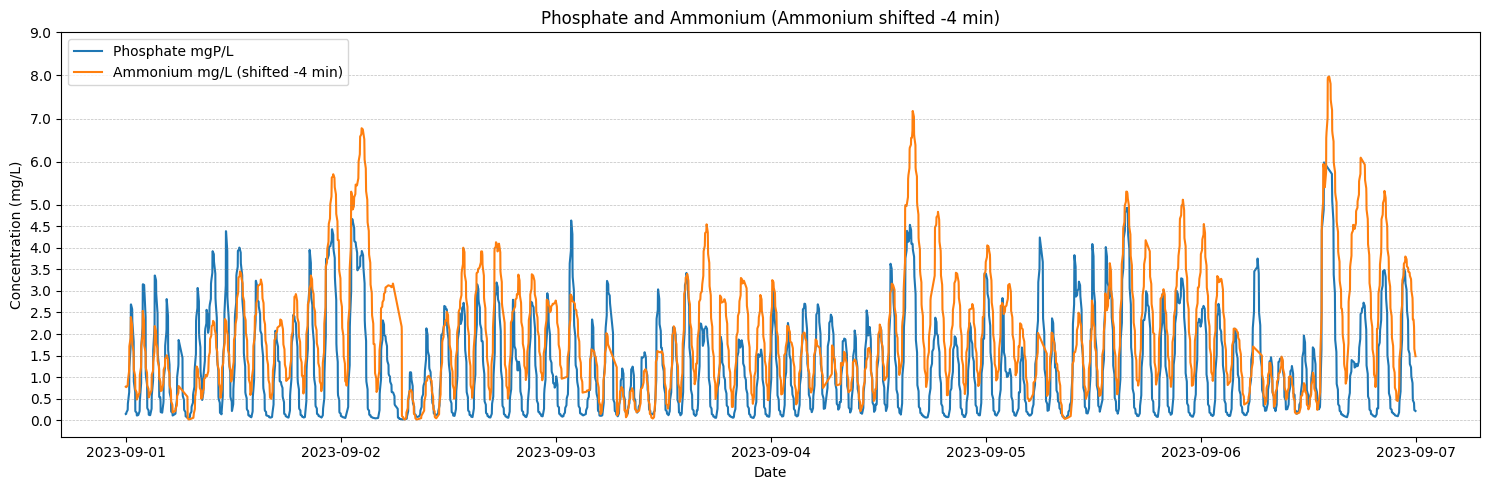

In [228]:
# Shift ammonium forward by 4 minutes (so it aligns with phosphate's response)
df['Ammonium_shifted'] = df['Ammonium mg/L'].shift(-4)

# Choose a time window to plot (e.g., a week)
start_date = '2023-09-01'
end_date = '2023-09-07'
mask = (df.index >= start_date) & (df.index <= end_date)

# ... your existing code ...
plt.figure(figsize=(15, 5))
plt.plot(df.index[mask], df['Phosphate mgP/L'][mask], label='Phosphate mgP/L')
plt.plot(df.index[mask], df['Ammonium_shifted'][mask], label='Ammonium mg/L (shifted -4 min)')

# Custom y-ticks: every 0.5 from 0 to 5, then 6, 7, 8, ...
y_max = plt.ylim()[1]
y_ticks = list(np.arange(0, 5.5, 0.5)) + list(np.arange(6, np.ceil(y_max) + 1, 1))
plt.yticks(y_ticks)

# Add horizontal lines at each tick
for y in y_ticks:
    plt.axhline(y, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

plt.legend()
plt.title('Phosphate and Ammonium (Ammonium shifted -4 min)')
plt.xlabel('Date')
plt.ylabel('Concentration (mg/L)')
plt.tight_layout()
plt.show()

In [229]:
# Define bin edges from 0 to 6 in steps of 0.5
bins = np.arange(0, 6.5, 0.5)  # [0.0, 0.5, 1.0, ..., 6.0]

# Bin the phosphate values
phos_binned = pd.cut(df['Phosphate mgP/L'], bins=bins, right=False)  # right=False means [a, b)

# Count the number of values in each bin
counts = phos_binned.value_counts().sort_index()

# Print the results
for interval, count in counts.items():
    print(f"{interval}: {count} measurements")

[0.0, 0.5): 134453 measurements
[0.5, 1.0): 86397 measurements
[1.0, 1.5): 69979 measurements
[1.5, 2.0): 58440 measurements
[2.0, 2.5): 46293 measurements
[2.5, 3.0): 35455 measurements
[3.0, 3.5): 26091 measurements
[3.5, 4.0): 19764 measurements
[4.0, 4.5): 12056 measurements
[4.5, 5.0): 8643 measurements
[5.0, 5.5): 6010 measurements
[5.5, 6.0): 21658 measurements


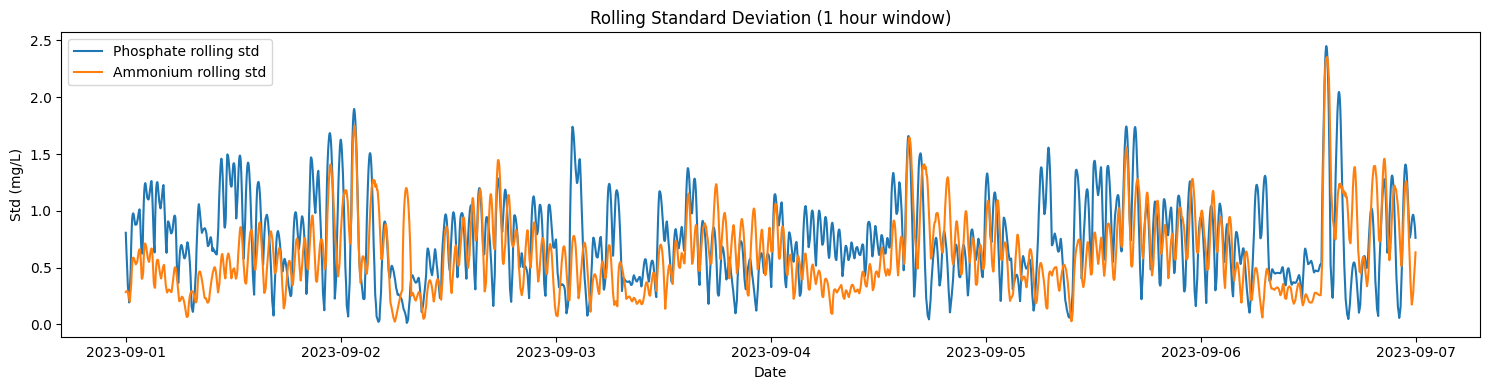

In [230]:
window = 60  # 1 hour if data is 1-minutely
df['phos_rolling_std'] = df['Phosphate mgP/L'].rolling(window).std()
df['ammo_rolling_std'] = df['Ammonium mg/L'].rolling(window).std()

plt.figure(figsize=(15, 4))
plt.plot(df.index[mask], df['phos_rolling_std'][mask], label='Phosphate rolling std')
plt.plot(df.index[mask], df['ammo_rolling_std'][mask], label='Ammonium rolling std')
plt.legend()
plt.title('Rolling Standard Deviation (1 hour window)')
plt.xlabel('Date')
plt.ylabel('Std (mg/L)')
plt.tight_layout()
plt.show()

In [231]:
print(df.columns)

Index(['influentFlow', 'datumEindeMeting', 'Ammonium mg/L', 'Nitrate mg/L',
       'Phosphate mgP/L', 'Oxygen_Mean', 'dayofweek', 'is_weekend', 'day_name',
       'is_low_phosphate', 'low_group', 'Ammonium_shifted', 'phos_rolling_std',
       'ammo_rolling_std'],
      dtype='object')


In [242]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# --- FIRST: Convert all numeric columns to proper numeric types ---
# This must be done BEFORE creating lag features
numeric_columns = ['influentFlow', 'Ammonium mg/L', 'Nitrate mg/L', 'Phosphate mgP/L', 'Oxygen_Mean']

for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        print(f"Converted {col} to numeric. Null values: {df[col].isnull().sum()}")

# --- Feature Engineering ---
df['phosphate_next_1h'] = df['Phosphate mgP/L'].shift(-60)

# Create lag features (now from properly numeric columns)
for lag in [1, 4, 5, 15, 30, 60, 180, 1440]:
    df[f'phosphate_lag_{lag}min'] = df['Phosphate mgP/L'].shift(lag)
    df[f'ammonium_lag_{lag}min'] = df['Ammonium mg/L'].shift(lag)

df['inflow_lag_4min'] = df['influentFlow'].shift(4)
df['inflow_lag_24h'] = df['influentFlow'].shift(1440)

# Rolling features
df['phosphate_rolling_mean_1h'] = df['Phosphate mgP/L'].rolling(60).mean()
df['phosphate_rolling_std_1/2h'] = df['Phosphate mgP/L'].rolling(30).std()
df['phosphate_rolling_std_1h'] = df['Phosphate mgP/L'].rolling(60).std()
df['ammonium_rolling_max_1h'] = df['Ammonium mg/L'].rolling(60).max()
df['ammonium_rolling_std_1h'] = df['Ammonium mg/L'].rolling(60).std() 
df['ammonium_rolling_min_1h'] = df['Ammonium mg/L'].rolling(60).min()

# Spike indicator
df['ammonium_spike'] = (df['ammonium_rolling_max_1h'] > 6).astype(int)

# Inflow bins
df['inflow_bin'] = pd.cut(df['influentFlow'], bins=[-np.inf, 4000, 7000, np.inf], labels=['low', 'mid', 'high'])

# Convert the datetime column to datetime type and set as index
df = df.reset_index()
df['datumBeginMeting'] = pd.to_datetime(df['datumBeginMeting'], format="%d-%m-%Y %H:%M")
df = df.set_index('datumBeginMeting')

# Time features
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

# One-hot encode inflow_bin
df = pd.get_dummies(df, columns=['inflow_bin'], drop_first=True)

# Ensure all expected dummy columns exist
for col in ['inflow_bin_mid', 'inflow_bin_high']:
    if col not in df.columns:
        df[col] = 0

# --- Select Features ---
FEATURES = [
    'Phosphate mgP/L',
    'Ammonium mg/L', 
    'phosphate_lag_5min',
    'phosphate_lag_30min',
    #'phosphate_lag_60min',
    #'phosphate_lag_180min',
    #'phosphate_lag_1440min',
    'ammonium_lag_5min',
    'ammonium_lag_30min',
   #'ammonium_lag_60min',
    #'ammonium_lag_180min',
    #'ammonium_lag_4min',
    #'ammonium_lag_1440min',
    'inflow_lag_4min', 
    'phosphate_rolling_mean_1h',
   # 'phosphate_rolling_std_1h',
    'phosphate_rolling_std_1/2h',
    'ammonium_rolling_std_1h',
    #'ammonium_rolling_min_1h',
   # 'ammonium_spike',
    'hour', 
    'is_weekend',
]

# Drop missing values
df_model = df.dropna(subset=FEATURES + ['phosphate_next_1h'])
X = df_model[FEATURES]
y = df_model['phosphate_next_1h']

# Remove duplicate columns if any
X = X.loc[:, ~X.columns.duplicated()]

# --- CRITICAL: Check and fix data types before XGBoost ---
print("Checking data types before XGBoost:")
print(X.dtypes)
print("\nColumns with object dtype:")
object_cols = X.select_dtypes(include='object').columns
print(object_cols.tolist())

# Convert any remaining object columns to numeric
for col in object_cols:
    print(f"Converting {col} from object to numeric...")
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Convert all bool columns to float
bool_cols = X.select_dtypes(include='bool').columns
X[bool_cols] = X[bool_cols].astype(float)

# Final check - ensure no object columns remain
print("\nFinal data types:")
print(X.dtypes)
print(f"Any object columns remaining: {X.select_dtypes(include='object').columns.tolist()}")

# Check for any remaining NaN values
print(f"\nNaN values per column:")
print(X.isnull().sum())

# Train/Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# --- XGBoost (Base Model) ---
model = XGBRegressor(
    subsample=0.6,
    n_estimators=200,
    max_depth=10,
    learning_rate=0.05,
    colsample_bytree=0.6,
    random_state=42
)

print("Training XGBoost model...")
model.fit(X_train, y_train)

# Continue with the rest of your code...
residuals = y_train - model.predict(X_train)

# --- Random Forest (First Residual Model) ---
residual_rf_model = RandomForestRegressor(
    n_estimators=50,
    min_samples_split=10,
    min_samples_leaf=1,
    max_features=None,
    max_depth=3,
    random_state=42
)
residual_rf_model.fit(X_train, residuals)

# Base model predictions
y_pred_base = model.predict(X_test)

# RMSE for base model only
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
print(f"Base Model RMSE: {rmse_base:.3f}")

# Residual model predictions
y_pred_rf_residual = residual_rf_model.predict(X_test)

# Final combined predictions
y_pred_final_rf = y_pred_base + y_pred_rf_residual

# RMSE for combined model
rmse_final_rf = np.sqrt(mean_squared_error(y_test, y_pred_final_rf))
print(f"Final RMSE (base + RF residual): {rmse_final_rf:.3f}")

# --- Feature Importances ---
importances = model.feature_importances_
importances_df = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print("\nFeature importances (1h ahead):")
print(importances_df)

# --- OVERFITTING CHECK (RMSE ONLY) ---
print("\n" + "="*50)
print("CHECKING FOR OVERFITTING (RMSE ONLY)")
print("="*50)

# 1. BASIC OVERFITTING CHECK: Compare Training vs Test RMSE
print("1. Training vs Test RMSE:")

# Get predictions on training data
y_pred_train = model.predict(X_train)

# Calculate RMSE for training
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = rmse_base  # Already calculated above

print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Difference: {test_rmse - train_rmse:.4f}")

# 2. OVERFITTING ANALYSIS (RMSE BASED)
print("\n2. Overfitting Analysis (RMSE-based):")
rmse_ratio = test_rmse / train_rmse
rmse_diff = test_rmse - train_rmse

print(f"RMSE Ratio (Test/Train): {rmse_ratio:.3f}")
print(f"RMSE Difference (Test - Train): {rmse_diff:.4f}")

if rmse_ratio > 1.2:  # Test RMSE is 20% higher than training
    print("🚨 STRONG OVERFITTING DETECTED!")
    print(f"   Test RMSE is {((rmse_ratio-1)*100):.1f}% higher than training")
elif rmse_ratio > 1.1:  # Test RMSE is 10% higher
    print("⚠️ MILD OVERFITTING DETECTED")
    print(f"   Test RMSE is {((rmse_ratio-1)*100):.1f}% higher than training")
elif rmse_ratio > 1.05:  # Test RMSE is 5% higher
    print("⚠️ SLIGHT OVERFITTING")
    print(f"   Test RMSE is {((rmse_ratio-1)*100):.1f}% higher than training")
else:
    print("✅ NO SIGNIFICANT OVERFITTING")
    print(f"   Test RMSE is only {((rmse_ratio-1)*100):.1f}% higher than training")

# 3. CROSS-VALIDATION CHECK (RMSE)
print("\n3. Cross-Validation RMSE Check:")
cv_scores = cross_val_score(model, X_train, y_train, cv=5, 
                           scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse = np.sqrt(-cv_scores)

print(f"Cross-Validation RMSE: {cv_rmse.mean():.4f} (±{cv_rmse.std():.4f})")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

cv_vs_train_ratio = cv_rmse.mean() / train_rmse
print(f"CV/Training RMSE Ratio: {cv_vs_train_ratio:.3f}")

if cv_vs_train_ratio > 1.15:
    print("⚠️ Cross-validation suggests overfitting")
elif cv_vs_train_ratio > 1.1:
    print("⚠️ Slight overfitting suggested by CV")
else:
    print("✅ Cross-validation confirms good generalization")

# 4. VISUAL OVERFITTING CHECK
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: RMSE Comparison
categories = ['Training', 'Test', 'CV Mean']
rmse_values = [train_rmse, test_rmse, cv_rmse.mean()]
colors = ['green', 'red' if test_rmse > train_rmse * 1.1 else 'orange', 'blue']

axes[0].bar(categories, rmse_values, color=colors, alpha=0.7)
axes[0].set_ylabel('RMSE')
axes[0].set_title('RMSE Comparison: Training vs Test vs CV')
for i, v in enumerate(rmse_values):
    axes[0].text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom')

# Plot 2: Actual vs Predicted with RMSE annotations
axes[1].scatter(y_train, y_pred_train, alpha=0.5, label=f'Training (RMSE: {train_rmse:.4f})', s=1)
axes[1].scatter(y_test, y_pred_base, alpha=0.5, label=f'Test (RMSE: {test_rmse:.4f})', s=1)
axes[1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')
axes[1].set_title('Actual vs Predicted')
axes[1].legend()

# Plot 3: Residuals comparison
train_residuals = y_train - y_pred_train
test_residuals = y_test - y_pred_base
axes[2].scatter(y_pred_train, train_residuals, alpha=0.5, label='Training', s=1)
axes[2].scatter(y_pred_base, test_residuals, alpha=0.5, label='Test', s=1)
axes[2].axhline(y=0, color='r', linestyle='--')
axes[2].set_xlabel('Predicted Values')
axes[2].set_ylabel('Residuals')
axes[2].set_title('Residuals Plot')
axes[2].legend()

plt.tight_layout()
plt.show()

# 5. SIMPLE OVERFITTING DIAGNOSIS
print("\n" + "="*30)
print("OVERFITTING DIAGNOSIS")
print("="*30)

if rmse_ratio > 1.2:
    print("🚨 SEVERE OVERFITTING")
    print("Action needed: Reduce model complexity")
    print("Suggestions:")
    print("- Lower max_depth (try 6-8)")
    print("- Reduce n_estimators (try 100-150)")
    print("- Add regularization (reg_alpha=1, reg_lambda=1)")
elif rmse_ratio > 1.1:
    print("⚠️ MODERATE OVERFITTING") 
    print("Action recommended: Add regularization")
    print("Suggestions:")
    print("- Add slight regularization")
    print("- Use early stopping")
    print("- Consider feature selection")
elif rmse_ratio > 1.05:
    print("⚠️ SLIGHT OVERFITTING")
    print("Action optional: Monitor with validation")
    print("Model is mostly fine, minor tuning could help")
else:
    print("✅ GOOD GENERALIZATION")
    print("Model is not overfitting")
    print("Focus on improving features or architecture")

print(f"\nSummary: Test RMSE is {((rmse_ratio-1)*100):.1f}% higher than Training RMSE")
print("="*50)

# --- Step 1: Align Predictions with y_test Index ---
# Convert all prediction arrays to Series with y_test index
y_pred_base = pd.Series(y_pred_base[:len(y_test)], index=y_test.index)
y_pred_final_rf = pd.Series(y_pred_final_rf[:len(y_test)], index=y_test.index)

# --- Step 2: Align Ammonium Data to y_test Index ---
df_model = df_model[~df_model.index.duplicated(keep='first')]
ammonium_1h = df_model['Ammonium mg/L'].reindex(y_test.index)

# --- Step 3: Define Plot Range ---
start_date = '2023-11-01'
end_date = '2023-12-05'
mask = (y_test.index >= start_date) & (y_test.index <= end_date)

# --- Step 4: Plot – Final Model vs Actual ---
plt.figure(figsize=(15, 5))
plt.plot(y_test.index[mask], y_test[mask], label='Actual Phosphate (1h ahead)')
plt.plot(y_test.index[mask], y_pred_final_rf[mask], label='Predicted Phosphate (1h ahead, base + RF residual)')
plt.legend()
plt.title('1-Hour-Ahead Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('mg/L')
plt.tight_layout()
plt.show()

# --- Step 5: Plot – Base vs Residual Prediction ---
plt.figure(figsize=(20, 8))
plt.plot(y_test.index[mask], y_test[mask], label='Actual')
plt.plot(y_test.index[mask], y_pred_base[mask], label='Base Prediction')
plt.plot(y_test.index[mask], y_pred_final_rf[mask], label='Base + RF Residual')
plt.plot(y_test.index[mask], ammonium_1h[mask], label='Ammonium (current)', color='green', alpha=0.5)
plt.legend()
plt.title('Phosphate 1-Hour-Ahead: Actual vs. Base vs. Base + RF Residual')
plt.xlabel('Date')
plt.ylabel('mg/L')
plt.tight_layout()
plt.show()

Converted influentFlow to numeric. Null values: 0
Converted Ammonium mg/L to numeric. Null values: 0
Converted Nitrate mg/L to numeric. Null values: 0
Converted Phosphate mgP/L to numeric. Null values: 0
Converted Oxygen_Mean to numeric. Null values: 0
Checking data types before XGBoost:
Phosphate mgP/L               float64
Ammonium mg/L                 float64
phosphate_lag_5min            float64
phosphate_lag_30min           float64
ammonium_lag_5min             float64
ammonium_lag_30min            float64
inflow_lag_4min               float64
phosphate_rolling_mean_1h     float64
phosphate_rolling_std_1/2h    float64
ammonium_rolling_std_1h       float64
hour                            int32
is_weekend                      int64
dtype: object

Columns with object dtype:
[]

Final data types:
Phosphate mgP/L               float64
Ammonium mg/L                 float64
phosphate_lag_5min            float64
phosphate_lag_30min           float64
ammonium_lag_5min             float64
a

NameError: name 'cross_val_score' is not defined

In [ ]:
# 1. Set thresholds
ammonium_spike_threshold = 6    # Ammonium spike threshold (mg/L)
phosphate_spike_threshold = 5   # Phosphate spike threshold (mgP/L)
window_minutes = 10              # Window after ammonium spike (in minutes)

# 2. Find ammonium spike times
ammonium_spike_mask = df['Ammonium mg/L'] > ammonium_spike_threshold
ammonium_spike_times = df.index[ammonium_spike_mask]

# 3. Check for phosphate spikes after ammonium spikes
count_phosphate_spikes = 0

for spike_time in ammonium_spike_times:
    # Get the window after the ammonium spike
    window = df.loc[spike_time : spike_time + pd.Timedelta(minutes=window_minutes)]
    # Check if any phosphate value in this window exceeds the threshold
    if (window['Phosphate mgP/L'] > phosphate_spike_threshold).any():
        count_phosphate_spikes += 1

total_spikes = len(ammonium_spike_times)
if total_spikes > 0:
    percent = 100 * count_phosphate_spikes / total_spikes
    print(f"{percent:.1f}% of ammonium spikes (> {ammonium_spike_threshold} mg/L) are followed by a phosphate spike (> {phosphate_spike_threshold} mgP/L) within {window_minutes} minutes.")
else:
    print("No ammonium spikes found.")

In [ ]:
# ENGINEERED COMPLEX FEATURE FOR PREDICTING LONG LOWS OF PHOSPHATE
high_risk_months = [4, 10, 11, 12]
high_risk_days = [0, 5]  # Monday=0, Saturday=5

df['high_influentFlow'] = (df['influentFlow'] > 2500).astype(int)
df['is_high_risk_month'] = df.index.month.isin(high_risk_months).astype(int)
df['is_early_morning'] = ((df.index.hour >= 0) & (df.index.hour <= 8)).astype(int)
df['is_high_risk_day'] = df.index.dayofweek.isin(high_risk_days).astype(int)
df['combo_risk_feature'] = (
    df[['high_influentFlow', 'is_high_risk_month', 'is_early_morning', 'is_high_risk_day']].sum(axis=1) >= 3
).astype(int)
